# Auto Graph Convolutional Network for ST deconvolution

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numexpr as ne
import numpy as np
import pandas as pd
import re
import seaborn as sns

import scipy
import scanpy
import tifffile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, NNConv, global_max_pool
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_scatter import scatter_mean
from torch import optim

import sklearn.neighbors as skgraph
from scipy import sparse as sp
import networkx as nx

import sys

# 1.1 Read the data

In [3]:
data_dir='/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/correct_version/5_Human_ovarian'
output_dir='/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/correct_version/5_Human_ovarian/output_result'

(41048, 30035, 3)


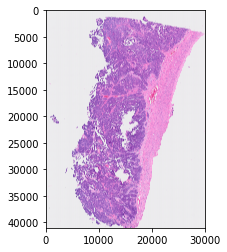

In [4]:
### 1.1 Read the image file

image_file = os.path.join(data_dir, '5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image.tif')
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()
plt.imshow(image_norm)
plt.show()

In [ ]:
### 1.2 Read the ST data

### 1.2.1 The gene expression matrix
gene_matrix = scanpy.read_mtx("/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/5_Human_ovarian/data/filtered_feature_bc_matrix/matrix.mtx")

### 1.2.2. The spatial barcodes matrix

barcodes = pd.read_csv('/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/5_Human_ovarian/data/filtered_feature_bc_matrix/barcodes.tsv', 
                       header=None)
barcodes

### 1.2.3. The gene features matrix

genes = pd.read_csv('/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/5_Human_ovarian/data/filtered_feature_bc_matrix/features.tsv', 
                       header=None, sep='\t')
genes

### 1.2.4 Read the spatial positions data
spatial = pd.read_csv(os.path.join(data_dir,'data', 'spatial', 'tissue_positions.csv'), index_col=0)
spatial

In [38]:
### 1.3 Read the HD-staining result or from other cell segmentation and feature extraction method

nuclei_data_df = pd.read_csv('/project/DPDS/Xiao_lab/shared/zhuoyu_wen/spatial_profiling/feature_vectors/results/10x_Genomics/5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image/(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image)_information_model40_image20.csv')

In [39]:
nuclei_data_df

,nucleus_id,nucleus_class,centroid_x0,centroid_y0,area,convex_area,eccentricity,extent,filled_area,major_axis_length,...,mask_feature_247,mask_feature_248,mask_feature_249,mask_feature_250,mask_feature_251,mask_feature_252,mask_feature_253,mask_feature_254,mask_feature_255,mask_feature_256
0,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,16035,57,1609,1631,0.528023,0.778046,1609,49.368783,...,0.638172,0.001287,0.067700,0.002586,0.046827,0.016204,0.025996,0.035663,0.029856,0.305576
1,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,15949,92,1479,1500,0.783045,0.763158,1479,55.272426,...,0.728006,0.009713,0.101069,0.000379,0.173253,0.033755,0.044094,0.075253,0.089260,0.269661
2,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,stroma,15927,28,926,943,0.854123,0.645296,926,47.824206,...,0.234811,0.002930,0.026560,0.016710,0.001363,0.042367,0.048907,0.000383,0.000547,0.137729
3,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,15966,71,978,1011,0.696526,0.756966,978,42.057786,...,0.530749,0.009651,0.065756,0.007254,0.015017,0.037435,0.033498,0.019046,0.055838,0.169642
4,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,15994,90,1259,1277,0.489100,0.773342,1259,43.018249,...,0.576939,0.008349,0.054109,0.010228,0.045466,0.014455,0.029350,0.017272,0.128874,0.276327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364658,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,stroma,16863,40944,1515,1559,0.702737,0.717330,1515,52.655006,...,0.246284,0.003384,0.051266,0.002767,0.002801,0.042497,0.060804,0.005522,0.000000,0.037923
364659,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,blood,16891,41006,820,845,0.663016,0.759259,820,37.750067,...,0.224713,0.009578,0.024974,0.004801,0.002446,0.021116,0.049722,0.005565,0.000000,0.019641
364660,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,blood,16914,40964,2112,2225,0.888688,0.700498,2112,77.526718,...,0.145999,0.001760,0.034504,0.002725,0.003656,0.061455,0.070237,0.009330,0.000000,0.022981
364661,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,blood,16836,40950,288,289,0.772019,0.935065,288,24.182075,...,0.415321,0.002220,0.025273,0.000121,0.000183,0.005847,0.014676,0.001624,0.000000,0.004537


In [40]:
nuclei_data_df['nucleus_class'].value_counts()

tumor                183160
stroma                73116
ductal epithelium     56383
blood                 26429
lymphocyte            13310
necrosis               8976
macrophage             3289
Name: nucleus_class, dtype: int64

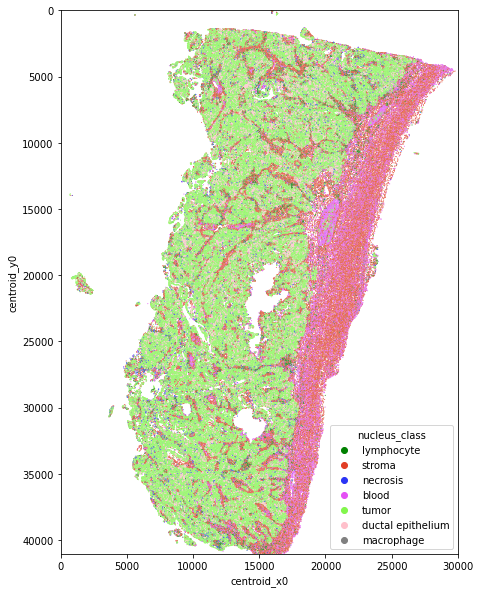

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

#0dd149
# Define your custom color palette
my_color_palette = ["green", "#E13E25", "#2A34F5", "#E450F5","#82F64C", "pink","grey"]

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=nuclei_data_df['centroid_x0'],
    y=nuclei_data_df['centroid_y0'],
    hue=nuclei_data_df['nucleus_class'],
    palette=my_color_palette,  # Assign the custom color palette
    s=1
)
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()


/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


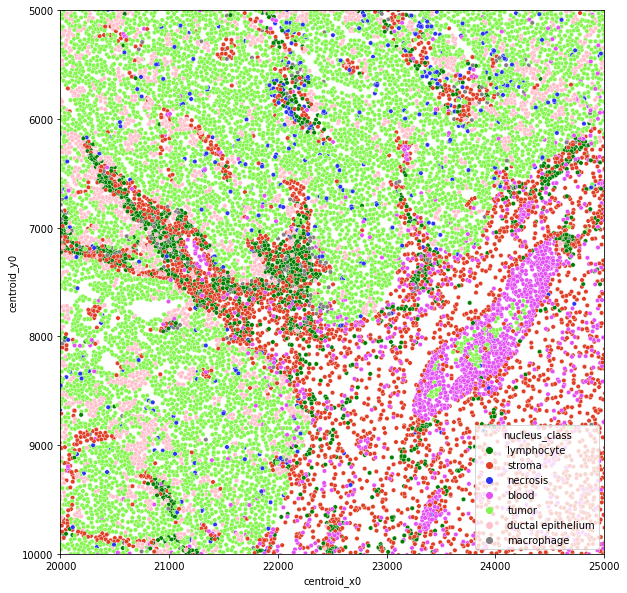

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

#0dd149
# Define your custom color palette
my_color_palette = ["green", "#E13E25", "#2A34F5", "#E450F5","#82F64C", "pink","grey"]

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=nuclei_data_df['centroid_x0'],
    y=nuclei_data_df['centroid_y0'],
    hue=nuclei_data_df['nucleus_class'],
    palette=my_color_palette,  # Assign the custom color palette
    s=20
)
plt.gca().set_aspect('equal')
plt.ylim(10000, 5000)
plt.xlim(20000, 25000)
plt.show()

#[5000:9000,8000:12000]

# 1.2 Data pre-processing

### 1.2.1 Pre-processing the gene expression matrix

In [15]:
count_df = pd.read_csv(os.path.join(output_dir, 'count_norm.csv'), index_col=0)
count_df

# Normalize count_df
count_stat = pd.read_csv(os.path.join(output_dir, 'count_stat.csv'), index_col=0)
count_stat

# Log2
'''
count_df = np.log2(count_df + 1)

# Normalize gene_stat by divided with max
count_max = np.log2(count_stat.loc['max', :].values + 1)
count_max[count_max < 1] = 1
'''
count_max = count_stat.loc['tile_95', :].values
count_max[count_max < 1] = 1
count_df = count_df/count_max

# Only keep count_stat with non_zero_p > 0.1
# count_df = count_df.loc[:, count_stat.loc['non_zero_p', :].values > 0.2]

In [16]:
count_df

,SIGIRR,NTS,PRKCQ,SLC66A1,NDUFS1,CFAP58,FOLH1,XRCC1,RBFOX3,FAM200A,...,HIST1H4B,ARFGAP2,RNPS1,ZNF343,RSPO2,ZKSCAN8,KANSL3,HSPA14,TBCE,TMSB15B
AACAATGTGCTCCGAG-1,0.884756,0.0,0.000000,0.767167,0.267907,0.0,0.000000,0.596940,0.0,0.000000,...,0.0,0.235796,1.077967,0.363220,0.0000,0.279368,1.063165,0.645868,0.649475,0.567332
AACACCATTCGCATAC-1,0.681495,0.0,0.000000,0.984868,1.031797,0.0,0.000000,0.638613,0.0,0.000000,...,0.0,0.302708,0.553546,0.000000,0.0000,0.358645,0.454954,0.276383,0.000000,0.000000
AACACGTTGATACCGC-1,0.251788,0.0,0.000000,0.363874,0.381213,0.0,0.000000,0.707835,0.0,0.000000,...,0.0,0.167760,0.920321,0.387627,25.3614,1.093179,1.008537,0.612682,0.577597,0.000000
AACACTCGTGAGCTTC-1,0.449934,0.0,0.624986,0.000000,0.510907,0.0,0.000000,0.442704,0.0,0.220979,...,0.0,0.449668,0.274095,0.808115,0.0000,0.355174,0.788466,0.547417,1.135352,0.000000
AACAGCCTCCTGACTA-1,0.537952,0.0,0.597799,0.621941,0.488682,0.0,0.635479,0.544431,0.0,0.422733,...,0.0,0.430108,0.524344,0.441693,0.0000,0.594518,0.592560,0.261802,0.493620,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGCTATCGGTGGC-1,0.595705,0.0,0.827471,0.000000,0.450955,0.0,0.000000,0.251199,0.0,0.000000,...,0.0,0.198451,0.362897,0.611389,0.0000,0.822928,0.447392,0.543578,0.819920,0.477480
TGTTGGCCTGTAGCGG-1,0.722263,0.0,0.000000,0.745560,0.702977,0.0,0.000000,0.464102,0.0,0.000000,...,0.0,0.274985,0.439995,0.635382,0.0000,0.814498,0.568272,0.376606,0.284032,0.000000
TGTTGGTGCGCACGAG-1,0.336292,0.0,0.000000,0.485995,0.763730,0.0,0.000000,0.378158,0.0,0.000000,...,0.0,0.000000,0.409731,0.690293,0.0000,0.530933,0.336754,0.409153,0.000000,0.000000
TGTTGGTGCGGAATCA-1,0.313239,0.0,0.580145,0.000000,0.711376,0.0,0.000000,0.410941,0.0,0.205125,...,0.0,0.695677,0.572466,1.071622,0.0000,0.659383,0.575061,0.508141,0.766468,0.000000


In [18]:
meta_df = pd.read_csv(os.path.join(output_dir, 'meta_df.csv'), index_col=0)
meta_df

,pxl_col_in_fullres,pxl_row_in_fullres
barcode,,
AACAATGTGCTCCGAG-1,4830,29958
AACACCATTCGCATAC-1,8366,15758
AACACGTTGATACCGC-1,17813,25910
AACACTCGTGAGCTTC-1,10504,27140
AACAGCCTCCTGACTA-1,12125,31887
...,...,...
TGTTGCTATCGGTGGC-1,12639,39153
TGTTGGCCTGTAGCGG-1,19523,11706
TGTTGGTGCGCACGAG-1,14069,6626


In [ ]:
### re-oder the spatial location index
### export the output to files
#meta_df = spatial.loc[count_norm_df.index.values, ['pxl_col_in_fullres', 'pxl_row_in_fullres']]  # [x0, y0]
#meta_df.to_csv(os.path.join(output_dir, 'meta_df.csv'))
#meta_df

## 1.2.2 pre-processing of the image

In [33]:
nn=(max(meta_df['pxl_row_in_fullres'])-min(meta_df['pxl_row_in_fullres'])+max(meta_df['pxl_col_in_fullres'])-min(meta_df['pxl_col_in_fullres']))/2
print(nn)
###with 11 mm capture areas
###the resolution is 
print(11*1000/nn)
### Cacluate the SPOT_RADIUS
# 55 um / 0.546 mpp / 2= 110 pixels
### the number is the different in meta_df column 
#mpp = 100/366
#print(mpp)

36071.0
0.3049541182667517


In [34]:

mpp = 100/366
SPOT_RADIUS = 30/mpp/2
print(mpp)
print('SPOT_RADIUS: {}'.format(SPOT_RADIUS))

0.273224043715847
SPOT_RADIUS: 54.89999999999999


## 1.2.2  Pre-processing nuclei_data_df

In [43]:
nuclei_data_df

,nucleus_id,nucleus_class,centroid_x0,centroid_y0,area,convex_area,eccentricity,extent,filled_area,major_axis_length,...,mask_feature_247,mask_feature_248,mask_feature_249,mask_feature_250,mask_feature_251,mask_feature_252,mask_feature_253,mask_feature_254,mask_feature_255,mask_feature_256
0,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,16035,57,1609,1631,0.528023,0.778046,1609,49.368783,...,0.638172,0.001287,0.067700,0.002586,0.046827,0.016204,0.025996,0.035663,0.029856,0.305576
1,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,15949,92,1479,1500,0.783045,0.763158,1479,55.272426,...,0.728006,0.009713,0.101069,0.000379,0.173253,0.033755,0.044094,0.075253,0.089260,0.269661
2,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,stroma,15927,28,926,943,0.854123,0.645296,926,47.824206,...,0.234811,0.002930,0.026560,0.016710,0.001363,0.042367,0.048907,0.000383,0.000547,0.137729
3,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,15966,71,978,1011,0.696526,0.756966,978,42.057786,...,0.530749,0.009651,0.065756,0.007254,0.015017,0.037435,0.033498,0.019046,0.055838,0.169642
4,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,lymphocyte,15994,90,1259,1277,0.489100,0.773342,1259,43.018249,...,0.576939,0.008349,0.054109,0.010228,0.045466,0.014455,0.029350,0.017272,0.128874,0.276327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364658,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,stroma,16863,40944,1515,1559,0.702737,0.717330,1515,52.655006,...,0.246284,0.003384,0.051266,0.002767,0.002801,0.042497,0.060804,0.005522,0.000000,0.037923
364659,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,blood,16891,41006,820,845,0.663016,0.759259,820,37.750067,...,0.224713,0.009578,0.024974,0.004801,0.002446,0.021116,0.049722,0.005565,0.000000,0.019641
364660,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,blood,16914,40964,2112,2225,0.888688,0.700498,2112,77.526718,...,0.145999,0.001760,0.034504,0.002725,0.003656,0.061455,0.070237,0.009330,0.000000,0.022981
364661,(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...,blood,16836,40950,288,289,0.772019,0.935065,288,24.182075,...,0.415321,0.002220,0.025273,0.000121,0.000183,0.005847,0.014676,0.001624,0.000000,0.004537


In [44]:
# Normalize nuclei_data_df
feature_names = [_ for _ in nuclei_data_df.columns.values[4:] if 'bbox' not in _ and 'orientation' not in _
                and 'probability_vector' not in _]
print("N features:", len(feature_names), feature_names[:20], "...")
# nuclei_data_norm_df = (nuclei_data_df.loc[:, feature_names] - np.mean(nuclei_data_df.loc[:, feature_names], axis=0))/\
#                         np.std(nuclei_data_df.loc[:, feature_names], axis=0)
nuclei_data_norm_df = nuclei_data_df.loc[:, feature_names]
feature_names_to_normalize = ['area', 'convex_area', 'eccentricity', 'extent', 'filled_area', 
                            'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity', 'probability']
nuclei_data_norm_df.loc[:, feature_names_to_normalize] = (nuclei_data_df.loc[:, feature_names_to_normalize] - \
                                                          np.mean(nuclei_data_df.loc[:, feature_names_to_normalize], axis=0))/\
                        np.std(nuclei_data_df.loc[:, feature_names_to_normalize], axis=0)

N features: 1290 ['area', 'convex_area', 'eccentricity', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity', 'probability', 'box_feature_1', 'box_feature_2', 'box_feature_3', 'box_feature_4', 'box_feature_5', 'box_feature_6', 'box_feature_7', 'box_feature_8', 'box_feature_9', 'box_feature_10'] ...


In [45]:
nuclei_data_df.loc[:, feature_names]

,area,convex_area,eccentricity,extent,filled_area,major_axis_length,minor_axis_length,perimeter,solidity,probability,...,mask_feature_247,mask_feature_248,mask_feature_249,mask_feature_250,mask_feature_251,mask_feature_252,mask_feature_253,mask_feature_254,mask_feature_255,mask_feature_256
0,1609,1631,0.528023,0.778046,1609,49.368783,41.925467,148.710678,0.986511,0.882472,...,0.638172,0.001287,0.067700,0.002586,0.046827,0.016204,0.025996,0.035663,0.029856,0.305576
1,1479,1500,0.783045,0.763158,1479,55.272426,34.377506,147.639610,0.986000,0.857166,...,0.728006,0.009713,0.101069,0.000379,0.173253,0.033755,0.044094,0.075253,0.089260,0.269661
2,926,943,0.854123,0.645296,926,47.824206,24.872012,120.468037,0.981972,0.765721,...,0.234811,0.002930,0.026560,0.016710,0.001363,0.042367,0.048907,0.000383,0.000547,0.137729
3,978,1011,0.696526,0.756966,978,42.057786,30.177775,118.911688,0.967359,0.762098,...,0.530749,0.009651,0.065756,0.007254,0.015017,0.037435,0.033498,0.019046,0.055838,0.169642
4,1259,1277,0.489100,0.773342,1259,43.018249,37.521699,130.468037,0.985904,0.750120,...,0.576939,0.008349,0.054109,0.010228,0.045466,0.014455,0.029350,0.017272,0.128874,0.276327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364658,1515,1559,0.702737,0.717330,1515,52.655006,37.461388,149.539105,0.971777,0.202561,...,0.246284,0.003384,0.051266,0.002767,0.002801,0.042497,0.060804,0.005522,0.000000,0.037923
364659,820,845,0.663016,0.759259,820,37.750067,28.259901,108.669048,0.970414,0.144793,...,0.224713,0.009578,0.024974,0.004801,0.002446,0.021116,0.049722,0.005565,0.000000,0.019641
364660,2112,2225,0.888688,0.700498,2112,77.526718,35.546958,192.468037,0.949213,0.133812,...,0.145999,0.001760,0.034504,0.002725,0.003656,0.061455,0.070237,0.009330,0.000000,0.022981
364661,288,289,0.772019,0.935065,288,24.182075,15.370106,62.727922,0.996540,0.088399,...,0.415321,0.002220,0.025273,0.000121,0.000183,0.005847,0.014676,0.001624,0.000000,0.004537


In [46]:
# Nucleus class numeric
temp = []
for i, _ in enumerate(nuclei_data_df['nucleus_class'].values):
    if _ == 'tumor':
        temp.append(1)
    elif _ == 'stroma':
        temp.append(2)
    elif _ == 'lymphocyte':
        temp.append(3)
    elif _ == 'blood':
        temp.append(4)
    elif _ == 'macrophage':
        temp.append(5)
    elif _ == 'necrosis':
        temp.append(6)
    elif _ == 'ductal epithelium':
        temp.append(7)
nuclei_data_df['nucleus_class_numeric'] = temp

In [47]:
# Add spot_id
from tqdm import tqdm
META_X = 'pxl_col_in_fullres'
META_Y = 'pxl_row_in_fullres'

cell_xs = nuclei_data_df['centroid_x0'].values
cell_ys = nuclei_data_df['centroid_y0'].values
n_cells = []
for index in tqdm(meta_df.index.values):
    x = meta_df.loc[index, META_X]
    y = meta_df.loc[index, META_Y]
    distance_square = (cell_xs - x) ** 2 + (cell_ys - y) ** 2
    nuclei_data_df.loc[distance_square <= SPOT_RADIUS ** 2, 'spot_id'] = index
    n_cells.append(np.sum(distance_square <= SPOT_RADIUS ** 2))

100%|██████████| 4674/4674 [00:41<00:00, 111.76it/s]


# 1.2.3 Select gene of interest

In [24]:
#marker_df=pd.read_csv('/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset//marker_gene/combined_df.csv',
#                  header=0, sep=',', index_col=0 )

In [25]:
#marker_df

,Gene,Ensembl_ID,Num_Probesets,Codewords,Annotation,Ensembl ID,Ensemble ID
0,ABCC9,ENSG00000069431,8,1,VLMC,NaN,NaN
1,ADAMTS12,ENSG00000151388,8,1,VLMC,NaN,NaN
2,ADAMTS16,ENSG00000145536,8,1,L4 IT,NaN,NaN
3,ADAMTS3,ENSG00000156140,8,1,L6 IT,NaN,NaN
4,ADRA1A,ENSG00000120907,8,1,Sncg,NaN,NaN
...,...,...,...,...,...,...,...
2168,VOPP1,ENSG00000154978,7,1,B cells,NaN,NaN
2170,WARS,ENSG00000140105,8,1,Endothelial cells,NaN,NaN
2171,ZEB1,ENSG00000148516,8,1,Breast cancer,NaN,NaN
2172,ZEB2,ENSG00000169554,8,1,Breast cancer,NaN,NaN


In [26]:
#genes_keep = []
#for index, row in marker_df.iterrows():
#    ensembl_id = row['Ensembl_ID']
#    if (genes.iloc[:, 0] == ensembl_id).any():
#        genes_keep.append(row['Gene'])

#print(len(genes_keep), 'found')


683 found


In [27]:
#genes_keep = [_ for _ in genes_keep if _ in count_df.columns.values]
#print(len(genes_keep), 'kept after removing 0s')

683 kept after removing 0s


In [28]:
#count_df_old = count_df.copy()
#count_df = count_df.loc[:, genes_keep]

In [70]:
count_df

,SIGIRR,NTS,PRKCQ,SLC66A1,NDUFS1,CFAP58,FOLH1,XRCC1,RBFOX3,FAM200A,...,HIST1H4B,ARFGAP2,RNPS1,ZNF343,RSPO2,ZKSCAN8,KANSL3,HSPA14,TBCE,TMSB15B
AACAATGTGCTCCGAG-1,0.884756,0.0,0.000000,0.767167,0.267907,0.0,0.000000,0.596940,0.0,0.000000,...,0.0,0.235796,1.077967,0.363220,0.0000,0.279368,1.063165,0.645868,0.649475,0.567332
AACACCATTCGCATAC-1,0.681495,0.0,0.000000,0.984868,1.031797,0.0,0.000000,0.638613,0.0,0.000000,...,0.0,0.302708,0.553546,0.000000,0.0000,0.358645,0.454954,0.276383,0.000000,0.000000
AACACGTTGATACCGC-1,0.251788,0.0,0.000000,0.363874,0.381213,0.0,0.000000,0.707835,0.0,0.000000,...,0.0,0.167760,0.920321,0.387627,25.3614,1.093179,1.008537,0.612682,0.577597,0.000000
AACACTCGTGAGCTTC-1,0.449934,0.0,0.624986,0.000000,0.510907,0.0,0.000000,0.442704,0.0,0.220979,...,0.0,0.449668,0.274095,0.808115,0.0000,0.355174,0.788466,0.547417,1.135352,0.000000
AACAGCCTCCTGACTA-1,0.537952,0.0,0.597799,0.621941,0.488682,0.0,0.635479,0.544431,0.0,0.422733,...,0.0,0.430108,0.524344,0.441693,0.0000,0.594518,0.592560,0.261802,0.493620,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGCTATCGGTGGC-1,0.595705,0.0,0.827471,0.000000,0.450955,0.0,0.000000,0.251199,0.0,0.000000,...,0.0,0.198451,0.362897,0.611389,0.0000,0.822928,0.447392,0.543578,0.819920,0.477480
TGTTGGCCTGTAGCGG-1,0.722263,0.0,0.000000,0.745560,0.702977,0.0,0.000000,0.464102,0.0,0.000000,...,0.0,0.274985,0.439995,0.635382,0.0000,0.814498,0.568272,0.376606,0.284032,0.000000
TGTTGGTGCGCACGAG-1,0.336292,0.0,0.000000,0.485995,0.763730,0.0,0.000000,0.378158,0.0,0.000000,...,0.0,0.000000,0.409731,0.690293,0.0000,0.530933,0.336754,0.409153,0.000000,0.000000
TGTTGGTGCGGAATCA-1,0.313239,0.0,0.580145,0.000000,0.711376,0.0,0.000000,0.410941,0.0,0.205125,...,0.0,0.695677,0.572466,1.071622,0.0000,0.659383,0.575061,0.508141,0.766468,0.000000


# 2)  Run the model

# 2.1 Data loader

In [48]:
# Hyperparameters
PATCH_SIZE = 250
SPOT_RADIUS = SPOT_RADIUS
N_CELL_CLASS = 7

device = 'cuda:2'

In [49]:
def get_edge_type(edge, cell_type):
    """
    Args: 
        edge: (in_cell_index, out_cell_index)
        
    Returns:
        edge type index.
        0: 1-1; 1: 1-2; 2: 1-3; 3: 1-4; 
        4: 2-1; 5: 2-2; 6: 2-3; 7: 2-4; 
        8: 3-1; 9: 3-2; 10: 3-3; 11: 3-4;
        12: 4-1; 13: 4-2; 14: 4-3; 15: 4-4
    """
    # mapping = {"1-1": 0, "1-2": 1, "1-3": 2, "1-4": 3, "1-5": 4, "1-6": 5, "1-7": 6, 
    #                "2-1": 7, "2-2": 8, "2-3": 9, "2-4": 10, "2-5": 11, "2-6": 12, "2-7": 13,
    #                "3-1": 14, "3-2": 15, "3-3": 16, "3-4": 17, 
    #                "4-1": 12, "4-2": 13, "4-3": 14, "4-4": 15}
    # return mapping['{}-{}'.format(cell_type[edge[0]], cell_type[edge[1]])]
    return int((cell_type[edge[0]] - 1) * N_CELL_CLASS + cell_type[edge[1]] - 1)

def get_nuclei_orientation_diff(edge, nuclei_orientation):
    return np.abs(np.cos(nuclei_orientation[edge[0]] - nuclei_orientation[edge[1]]))

class NucleiData(Data):
    """Add some attributes to Data object.
    
    Args:
        * All args mush be torch.tensor. So string is not supported.
        x: Matrix for nodes
        edge_index: 2*N matrix
        edge_attr: edge type
        y: Label
        spot_id: spot_id
    """
    def __init__(self, x=None, edge_index=None, edge_attr=None, y=None, pos=None, 
                 cell_type=None,
                 cell_id=None,
                 # spot_id=None, 
                 coord_x=None, coord_y=None):
        """cell_id: index in nucleus_data_df
        """
        super().__init__(x, edge_index, edge_attr, y, pos)
        self.cell_type = cell_type
        self.cell_id = cell_id
        # self.spot_id = spot_id
        self.coord_x = coord_x
        self.coord_y = coord_y
        
    def __repr__(self):
        info = ['{}={}'.format(key, self.size_repr(item)) for key, item in self]
        return '{}({})'.format(self.__class__.__name__, ', '.join(info))
    
    @staticmethod
    def size_repr(value):
        if torch.is_tensor(value):
            return list(value.size())
        elif isinstance(value, int) or isinstance(value, float) or isinstance(value, str):
            return [1]
        else:
            raise ValueError('Unsupported attribute type.')

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes, meta_df, nuclei_data_df, nuclei_data_norm_df, feature_names, augmentation=False):
        """
        Args:
            indexes: list of info_df.index
            info_df: information (meta_df)
            augmentation: True for augmentation
        """
        self.indexes = indexes
        self.meta_df = meta_df
        self.nuclei_data_df = nuclei_data_df
        self.nuclei_data_norm_df = nuclei_data_norm_df
        self.feature_names = feature_names
        self.augmentation = augmentation
        
        self.cell_xs = nuclei_data_df['centroid_x0'].values
        self.cell_ys = nuclei_data_df['centroid_y0'].values
        
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes)
    
    def __getitem__(self, index):
        """Generate one item of data.
        """
        return self.__data_generation(index)
    
    def __data_generation(self, index):
        """Generation & augmentation
        """
        index = self.indexes[index]
        
        additional_size = 0
        
        while True:
            # Increase patch size until get 8 neighbors included
            
            # Get patch centered with the spot
            coord_x_start = self.meta_df.loc[index, META_X] - PATCH_SIZE/2 - additional_size/2
            if self.augmentation:
                coord_x_start += int(np.random.randint(SPOT_RADIUS) - SPOT_RADIUS/2)
            coord_x_end = coord_x_start + PATCH_SIZE + additional_size/2
            coord_y_start = self.meta_df.loc[index, META_Y] - PATCH_SIZE/2 - additional_size/2
            if self.augmentation:
                coord_y_start += int(np.random.randint(SPOT_RADIUS) - SPOT_RADIUS/2)
            coord_y_end = coord_y_start + PATCH_SIZE + additional_size/2
            # expr = "(self.cell_xs >= coord_x_start) & (self.cell_xs <= coord_x_end) " +\
            #        "& (self.cell_ys >= coord_y_start) & (self.cell_ys <= coord_y_end)"
            # select = ne.evaluate(expr)
            select = np.logical_and(np.logical_and(self.cell_xs >= coord_x_start, self.cell_xs <= coord_x_end), 
                                    np.logical_and(self.cell_ys >= coord_y_start, self.cell_ys <= coord_y_end))
            patch_summary = self.nuclei_data_df.loc[select, :]
            patch_summary_norm = self.nuclei_data_norm_df.loc[select, :]

            # Create 8 nearest neighbors graph
            if len(patch_summary) == 0:
                return None, None, None, None
            elif len(patch_summary) <= 8:
                additional_size += 20
                # graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['centroid_x0', 'centroid_y0']]), 
                #                              n_neighbors=len(patch_summary)-1, mode='distance')
            else:
                graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['centroid_x0', 'centroid_y0']]), 
                                             n_neighbors=8, mode='distance')
                break
                
        I, J, V = sp.find(graph)
        edges = list(zip(I, J, 1/V))
        edge_index = np.transpose(np.array(edges)[:, 0:2])
        x = np.array(patch_summary_norm.loc[:, self.feature_names])
        cell_type = np.array(patch_summary['nucleus_class_numeric'])
        orientation = np.array(patch_summary['orientation'])

        # Edge features
        edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
        nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
        edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))
        
        data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                          edge_index=torch.tensor(edge_index, dtype=torch.long),
                          edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                          # y=torch.tensor([[y]], dtype=torch.long),
                          cell_type = torch.tensor(cell_type, dtype=torch.long),
                          cell_id = torch.tensor(patch_summary.index.values, dtype=torch.long),
                          coord_x=torch.tensor([[coord_x_start]]), 
                          coord_y=torch.tensor([[coord_y_start]]))
        
        # spot_ids
        spot_ids = patch_summary['spot_id'].values
        spot_xs = self.meta_df[META_X]
        spot_ys = self.meta_df[META_Y]
        expr = "(spot_xs >= coord_x_start + SPOT_RADIUS) & (spot_xs <= coord_x_end - SPOT_RADIUS) " +\
               "& (spot_ys >= coord_y_start + SPOT_RADIUS) & (spot_ys <= coord_y_end - SPOT_RADIUS)"
        spot_ids_set = self.meta_df.index.values[ne.evaluate(expr)]
        spot_ids_set = [_ for _ in spot_ids_set if np.sum(spot_ids == _) > 0]  # Only keep the spots with cells
        spot_counts = torch.tensor(np.array(count_df.loc[spot_ids_set, :]), dtype=torch.float)
        
        # Augmentation
        if self.augmentation:
            # Aug x
            # torch.seed()
            data.x += torch.randn_like(data.x) / 100
            # Aug edge_attr[:, 1] (orientation)
            # torch.seed()
            data.edge_attr[:, 1] += torch.randn_like(data.edge_attr[:, 1]) / 100
            data.edge_attr[:, 1] = torch.clamp(data.edge_attr[:, 1], 0, 1)
            # Aug edge_attr[:, 2] (1/V)
            # torch.seed()
            data.edge_attr[:, 2] += torch.randn_like(data.edge_attr[:, 2]) / 10000
            data.edge_attr[:, 2] = torch.clamp(data.edge_attr[:, 2], 0, 1)
        else:
            data.edge_attr[:, 2] = torch.clamp(data.edge_attr[:, 2], 0, 1)
            
        return data, spot_ids, spot_ids_set, spot_counts

In [50]:
train_set = Dataset(indexes=meta_df.index.values, 
                    meta_df=meta_df, 
                    nuclei_data_df=nuclei_data_df, 
                    nuclei_data_norm_df=nuclei_data_norm_df, 
                    feature_names=feature_names, 
                    augmentation=True)

In [51]:
train_set[2]

(NucleiData(cell_id=[26], cell_type=[26], coord_x=[1, 1], coord_y=[1, 1], edge_attr=[208, 3], edge_index=[2, 208], x=[26, 1290]),
 array(['AACACGTTGATACCGC-1', nan, nan, nan, nan, 'AACACGTTGATACCGC-1',
        nan, nan, nan, nan, 'AACACGTTGATACCGC-1', nan, nan, nan, nan,
        'AACACGTTGATACCGC-1', 'AACACGTTGATACCGC-1', 'AACACGTTGATACCGC-1',
        'AACACGTTGATACCGC-1', nan, nan, nan, nan, nan, nan, nan],
       dtype=object),
 ['AACACGTTGATACCGC-1'],
 tensor([[0.2518, 0.0000, 0.0000,  ..., 0.6127, 0.5776, 0.0000]]))

# 2.2 GCN model

In [52]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.neighbors as skgraph
from scipy import sparse as sp
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, NNConv, global_max_pool
from torch_geometric.data import Data
from torch_scatter import scatter_mean

import sys

In [53]:
class EdgeNN(nn.Module):
    """
    Design: embedding according to edge type, and then modulated by edge features.
    """
    def __init__(self, in_channels, out_channels, n_edge_types=N_CELL_CLASS ** 2):
        super(EdgeNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.edge_type_embedding = nn.Embedding(n_edge_types, out_channels)
        self.fc_h = nn.Linear(in_channels, out_channels)
        self.fc_g = nn.Linear(in_channels, out_channels)
        # self.bn = nn.BatchNorm(out_channels, eps=0.001)
        
    def forward(self, x):
        """
        Args:
            x: [batch_size, n_edges, 1(edge type) + in_channels]
        
        return: [batch_size, out_channels]
        """
        y = self.edge_type_embedding(x[..., 0].clone().detach().type(torch.long).to(device))
        h = self.fc_h(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        g = self.fc_g(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        y = y * h + g
        # x = self.bn(x)
        return F.relu(y, inplace=True)

class NucleiNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, batch=True, edge_features=2, n_edge_types=N_CELL_CLASS ** 2):
        """
        Args:
            in_channels: No. of node features
            out_channels: No. of output node features (e.g., No. classes for classification)
            batch: True if from DataLoader; False if single Data object
            edge_features: No. of edge features (excluding edge type)
            n_edge_types: No. of edge types
        """
        super(NucleiNet, self).__init__()
        self.batch=batch
        
        self.conv1 = NNConv(in_channels, 100, EdgeNN(edge_features, in_channels*100, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv2 = NNConv(100, 500, EdgeNN(edge_features, 100*500, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        # self.conv3 = NNConv(200, out_channels, EdgeNN(edge_features, 200*out_channels, n_edge_types=n_edge_types), 
        #                     aggr='mean', root_weight=True, bias=True)
        self.linear3 = torch.nn.Linear(500, out_channels)
        
    def forward(self, data):
        """
        Args:
            data: Data in torch_geometric.data
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv3(x, edge_index, edge_attr)
        x = self.linear3(x)
        x = F.relu(x)
        '''
        if self.batch:
            x = global_max_pool(x, batch=data.batch).to(device)
        else:
            x = global_max_pool(x, batch=torch.tensor(np.zeros(x.shape[0]), dtype=torch.long).to(device))
        '''
        '''
        gate_1 = torch.eq(data.cell_type, 1).clone().detach().requires_grad_(False).type(torch.long).to(device)
        gate_2 = torch.eq(data.cell_type, 2).clone().detach().requires_grad_(False).type(torch.long).to(device)
        gate_4 = torch.eq(data.cell_type, 4).clone().detach().requires_grad_(False).type(torch.long).to(device)
        gate = gate_1 | gate_2 | gate_4
        # print(np.unique(data.batch.cpu().numpy()))  ## [0, 1, 2, ... BATCH_SIZE-1]
        # print(gate * data.batch)  ## [[0]s, [1]s, .... [BATCH_SIZE - 1]s]
        if self.batch:
            _batch_size = data.batch[-1] + 1
            x = scatter_mean(x, gate * (data.batch+1), dim=0).to(device)[1:_batch_size+1, :]  # Keep the batches (0 is False in gate)
            # print(x.shape)  ## [BATCH_SIZE, 2]
        else:
            x = scatter_mean(x, gate, dim=0).to(device)[1, :]
            # print(x.shape)  ## [2]
        '''
        return x  # shape[N cells, N genes]

# 2.3 Train

In [54]:
model = NucleiNet(len(feature_names), count_df.shape[1], batch=False).to(device)

In [55]:
model.train()



NucleiNet(
  (conv1): NNConv(1290, 100)
  (conv2): NNConv(100, 500)
  (linear3): Linear(in_features=500, out_features=18061, bias=True)
)

In [56]:
import os

model_dir = output_dir + "/models/DESTINY_all_marker_genes_wo_log_zhuoyu"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [57]:
loss_hist = []
loss_hist_epoch = []
loss_lowest = 10000

In [58]:
learning_rate = 0.01  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.005
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)
optimizer = optim.Adadelta(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(300):
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 38233.82421875
Batch 100, loss: 42.27725601196289
Batch 200, loss: 38.4868278503418
Batch 400, loss: 26.063207626342773
Batch 500, loss: 60.32221221923828
Batch 600, loss: 97.19420623779297
Batch 700, loss: 45.6268310546875
Batch 800, loss: 54.476593017578125
Batch 900, loss: 43.317726135253906
Batch 1000, loss: 84.02947235107422
Batch 1100, loss: 67.07893371582031
Batch 1200, loss: 43.080772399902344
Batch 1300, loss: 27.871440887451172
Batch 1400, loss: 53.21341323852539
Batch 1500, loss: 26.731794357299805
Batch 1600, loss: 61.159942626953125
Batch 1700, loss: 24.7315731048584
Batch 1800, loss: 54.05398178100586
Batch 1900, loss: 31.093183517456055
Batch 2000, loss: 47.70842361450195
Batch 2100, loss: 25.499862670898438
Batch 2200, loss: 48.451290130615234
Batch 2300, loss: 40.89004135131836
Batch 2400, loss: 43.62379455566406
Batch 2500, loss: 40.489051818847656
Batch 2600, loss: 38.90990447998047
Batch 2700, loss: 44.22842025756836
Batch 2800, loss: 5

Batch 4200, loss: 41.89403533935547
Batch 4300, loss: 43.00029754638672
Batch 4400, loss: 35.8024787902832
Batch 4500, loss: 36.72317123413086
Batch 4600, loss: 29.536998748779297
Epoch 4, loss: 45.194621111156394
Saving epoch 4
Start epoch: 5
Batch 0, loss: 43.98530197143555
Batch 100, loss: 23.825151443481445
Batch 200, loss: 71.00320434570312
Batch 300, loss: 44.342567443847656
Batch 400, loss: 43.99293899536133
Batch 600, loss: 30.056480407714844
Batch 700, loss: 35.79303741455078
Batch 800, loss: 41.40937423706055
Batch 900, loss: 70.47947692871094
Batch 1000, loss: 42.18653106689453
Batch 1100, loss: 57.76683807373047
Batch 1200, loss: 43.145782470703125
Batch 1300, loss: 50.11248016357422
Batch 1400, loss: 70.22946166992188
Batch 1500, loss: 50.36227035522461
Batch 1600, loss: 40.929603576660156
Batch 1700, loss: 36.7899055480957
Batch 1800, loss: 44.66075897216797
Batch 1900, loss: 35.913639068603516
Batch 2000, loss: 60.096920013427734
Batch 2100, loss: 44.52672576904297
Batch

Batch 3500, loss: 45.49713897705078
Batch 3600, loss: 43.8053092956543
Batch 3700, loss: 44.28761672973633
Batch 3800, loss: 40.562828063964844
Batch 3900, loss: 29.532756805419922
Batch 4000, loss: 28.069320678710938
Batch 4100, loss: 25.309654235839844
Batch 4200, loss: 40.98960876464844
Batch 4300, loss: 47.43794631958008
Batch 4400, loss: 26.50682830810547
Batch 4500, loss: 37.753997802734375
Batch 4600, loss: 38.92184829711914
Epoch 9, loss: 45.19372441830184
Saving epoch 9
Start epoch: 10
Batch 0, loss: 45.5700569152832
Batch 100, loss: 22.819597244262695
Batch 200, loss: 28.670438766479492
Batch 300, loss: 25.83797264099121
Batch 400, loss: 36.511531829833984
Batch 500, loss: 29.60447883605957
Batch 600, loss: 42.102699279785156
Batch 700, loss: 57.087284088134766
Batch 800, loss: 60.759796142578125
Batch 900, loss: 27.93291473388672
Batch 1000, loss: 82.95965576171875
Batch 1100, loss: 34.391380310058594
Batch 1300, loss: 51.682579040527344
Batch 1400, loss: 27.247663497924805


Batch 2900, loss: 29.489213943481445
Batch 3000, loss: 45.83220291137695
Batch 3100, loss: 45.18468475341797
Batch 3200, loss: 32.29310989379883
Batch 3300, loss: 34.48224639892578
Batch 3400, loss: 50.16316223144531
Batch 3600, loss: 45.08742141723633
Batch 3700, loss: 40.79106140136719
Batch 3800, loss: 48.03815841674805
Batch 3900, loss: 46.17674255371094
Batch 4000, loss: 44.39937210083008
Batch 4100, loss: 40.75404357910156
Batch 4200, loss: 49.9096794128418
Batch 4300, loss: 47.674556732177734
Batch 4400, loss: 45.36595153808594
Batch 4500, loss: 32.316383361816406
Batch 4600, loss: 59.3437614440918
Epoch 14, loss: 45.11225332162934
Saving epoch 14
Start epoch: 15
Batch 0, loss: 24.425559997558594
Batch 100, loss: 45.35715103149414
Batch 200, loss: 59.583168029785156
Batch 300, loss: 62.43243408203125
Batch 400, loss: 45.995635986328125
Batch 500, loss: 43.588565826416016
Batch 600, loss: 33.324073791503906
Batch 700, loss: 53.943115234375
Batch 800, loss: 40.849365234375
Batch 9

Batch 2200, loss: 44.912315368652344
Batch 2300, loss: 46.06916046142578
Batch 2400, loss: 38.56782913208008
Batch 2500, loss: 66.2553939819336
Batch 2600, loss: 47.4655876159668
Batch 2700, loss: 46.285240173339844
Batch 2800, loss: 61.94912338256836
Batch 2900, loss: 25.883350372314453
Batch 3000, loss: 24.388225555419922
Batch 3100, loss: 26.2573184967041
Batch 3200, loss: 24.365468978881836
Batch 3300, loss: 37.595523834228516
Batch 3400, loss: 43.11545181274414
Batch 3500, loss: 40.19392013549805
Batch 3600, loss: 42.56571960449219
Batch 3700, loss: 50.34115219116211
Batch 3800, loss: 47.387550354003906
Batch 3900, loss: 26.081100463867188
Batch 4000, loss: 47.70563888549805
Batch 4100, loss: 44.05570983886719
Batch 4200, loss: 43.47841262817383
Batch 4300, loss: 45.87122344970703
Batch 4400, loss: 37.61654281616211
Batch 4500, loss: 39.024112701416016
Batch 4600, loss: 41.681182861328125
Epoch 19, loss: 43.30073822462451
Saving epoch 19
Start epoch: 20
Batch 100, loss: 55.6633186

Batch 1600, loss: 40.96122741699219
Batch 1700, loss: 41.639503479003906
Batch 1800, loss: 83.1506576538086
Batch 1900, loss: 36.2783317565918
Batch 2000, loss: 28.58249855041504
Batch 2100, loss: 29.536542892456055
Batch 2200, loss: 20.56526756286621
Batch 2300, loss: 39.677635192871094
Batch 2400, loss: 24.915990829467773
Batch 2500, loss: 46.39060974121094
Batch 2600, loss: 44.641639709472656
Batch 2700, loss: 42.377891540527344
Batch 2800, loss: 41.89007568359375
Batch 2900, loss: 40.01455307006836
Batch 3000, loss: 44.14663314819336
Batch 3100, loss: 35.153778076171875
Batch 3200, loss: 37.797489166259766
Batch 3300, loss: 57.74004364013672
Batch 3400, loss: 70.24908447265625
Batch 3500, loss: 39.873783111572266
Batch 3600, loss: 41.34989547729492
Batch 3700, loss: 67.0353775024414
Batch 3800, loss: 46.424686431884766
Batch 3900, loss: 24.193035125732422
Batch 4000, loss: 36.92018508911133
Batch 4100, loss: 40.24403762817383
Batch 4200, loss: 28.154272079467773
Batch 4300, loss: 4

Batch 600, loss: 41.47937774658203
Batch 700, loss: 36.940242767333984
Batch 800, loss: 55.89776611328125
Batch 900, loss: 37.556095123291016
Batch 1000, loss: 39.34925079345703
Batch 1100, loss: 55.092464447021484
Batch 1200, loss: 24.914840698242188
Batch 1300, loss: 23.11760139465332
Batch 1400, loss: 40.2409553527832
Batch 1500, loss: 25.16196632385254
Batch 1600, loss: 39.017181396484375
Batch 1700, loss: 27.303848266601562
Batch 1800, loss: 37.28544235229492
Batch 1900, loss: 54.941707611083984
Batch 2000, loss: 45.393898010253906
Batch 2100, loss: 57.207115173339844
Batch 2200, loss: 42.398704528808594
Batch 2300, loss: 25.290605545043945
Batch 2400, loss: 40.43099594116211
Batch 2500, loss: 58.973873138427734
Batch 2600, loss: 53.37345504760742
Batch 2700, loss: 51.860748291015625
Batch 2800, loss: 34.0694694519043
Batch 2900, loss: 43.21660614013672
Batch 3000, loss: 37.85565948486328
Batch 3100, loss: 37.61970901489258
Batch 3200, loss: 36.725345611572266
Batch 3300, loss: 38

Batch 4100, loss: 44.62242889404297
Batch 4200, loss: 45.93487548828125
Batch 4300, loss: 32.35193634033203
Batch 4400, loss: 56.017433166503906
Batch 4500, loss: 37.71828842163086
Batch 4600, loss: 59.56869125366211
Epoch 33, loss: 42.442954257600704
Saving epoch 33
Start epoch: 34
Batch 0, loss: 47.29804611206055
Batch 100, loss: 22.807926177978516
Batch 200, loss: 28.854156494140625
Batch 300, loss: 24.160030364990234
Batch 500, loss: 56.68730926513672
Batch 600, loss: 55.24576187133789
Batch 700, loss: 24.251630783081055
Batch 800, loss: 37.769935607910156
Batch 900, loss: 26.3403263092041
Batch 1000, loss: 55.99980926513672
Batch 1100, loss: 42.62894821166992
Batch 1300, loss: 26.420658111572266
Batch 1400, loss: 39.18967056274414
Batch 1500, loss: 70.42178344726562
Batch 1600, loss: 42.04722595214844
Batch 1700, loss: 41.084716796875
Batch 1800, loss: 70.47924041748047
Batch 1900, loss: 26.018714904785156
Batch 2000, loss: 28.744670867919922
Batch 2100, loss: 38.34513854980469
Ba

Batch 3100, loss: 28.776212692260742
Batch 3200, loss: 41.82600021362305
Batch 3300, loss: 33.32781219482422
Batch 3400, loss: 38.31386184692383
Batch 3600, loss: 38.3823127746582
Batch 3700, loss: 58.81017303466797
Batch 3800, loss: 37.06800079345703
Batch 3900, loss: 34.68301773071289
Batch 4000, loss: 22.872352600097656
Batch 4100, loss: 22.65148162841797
Batch 4200, loss: 30.59709358215332
Batch 4300, loss: 32.851497650146484
Batch 4400, loss: 31.948572158813477
Batch 4500, loss: 81.57938385009766
Batch 4600, loss: 42.01211166381836
Epoch 38, loss: 42.33480286740215
Saving epoch 38
Start epoch: 39
Batch 0, loss: 40.71196746826172
Batch 100, loss: 43.966041564941406
Batch 200, loss: 37.82127380371094
Batch 300, loss: 25.11824607849121
Batch 400, loss: 41.05195999145508
Batch 500, loss: 65.85536193847656
Batch 600, loss: 28.929763793945312
Batch 700, loss: 33.43397521972656
Batch 800, loss: 59.62363052368164
Batch 1000, loss: 52.25559997558594
Batch 1100, loss: 44.70138168334961
Batc

Batch 2300, loss: 43.66849899291992
Batch 2400, loss: 24.590557098388672
Batch 2500, loss: 43.752174377441406
Batch 2600, loss: 33.28074264526367
Batch 2700, loss: 42.44499969482422
Batch 2800, loss: 65.64569091796875
Batch 2900, loss: 32.9263916015625
Batch 3000, loss: 43.75648880004883
Batch 3100, loss: 38.45318603515625
Batch 3200, loss: 57.321380615234375
Batch 3300, loss: 83.46981811523438
Batch 3400, loss: 39.42927551269531
Batch 3500, loss: 64.70214080810547
Batch 3600, loss: 35.323028564453125
Batch 3800, loss: 33.65065002441406
Batch 3900, loss: 42.73328399658203
Batch 4000, loss: 32.227657318115234
Batch 4100, loss: 43.46305847167969
Batch 4200, loss: 32.65803146362305
Batch 4300, loss: 60.446144104003906
Batch 4400, loss: 34.73233413696289
Batch 4500, loss: 39.03527069091797
Batch 4600, loss: 88.91671752929688
Epoch 43, loss: 42.20294715120596
Saving epoch 43
Start epoch: 44
Batch 0, loss: 37.62838363647461
Batch 100, loss: 69.66251373291016
Batch 200, loss: 46.1440582275390

Batch 1300, loss: 53.568016052246094
Batch 1400, loss: 33.26329040527344
Batch 1500, loss: 45.50430679321289
Batch 1700, loss: 65.46583557128906
Batch 1800, loss: 31.338804244995117
Batch 1900, loss: 58.80615234375
Batch 2000, loss: 45.207698822021484
Batch 2100, loss: 29.135459899902344
Batch 2200, loss: 73.9405517578125
Batch 2300, loss: 46.49515914916992
Batch 2400, loss: 40.633026123046875
Batch 2500, loss: 72.09413146972656
Batch 2600, loss: 36.78357696533203
Batch 2700, loss: 32.37602996826172
Batch 2800, loss: 78.39988708496094
Batch 2900, loss: 39.12914276123047
Batch 3000, loss: 39.8636474609375
Batch 3100, loss: 34.32685852050781
Batch 3200, loss: 48.99127197265625
Batch 3300, loss: 39.05120849609375
Batch 3400, loss: 36.25339889526367
Batch 3500, loss: 60.29391860961914
Batch 3600, loss: 57.1856575012207
Batch 3700, loss: 55.34078598022461
Batch 3800, loss: 34.85148620605469
Batch 3900, loss: 38.88050842285156
Batch 4000, loss: 22.061683654785156
Batch 4100, loss: 81.5793762

Batch 600, loss: 42.12773895263672
Batch 800, loss: 39.196956634521484
Batch 900, loss: 57.29438018798828
Batch 1000, loss: 37.249595642089844
Batch 1100, loss: 42.309967041015625
Batch 1200, loss: 51.6380729675293
Batch 1300, loss: 83.39153289794922
Batch 1400, loss: 54.63980484008789
Batch 1500, loss: 40.33274841308594
Batch 1600, loss: 37.7513542175293
Batch 1700, loss: 38.412841796875
Batch 1800, loss: 41.392845153808594
Batch 1900, loss: 54.95212173461914
Batch 2000, loss: 44.81915283203125
Batch 2100, loss: 39.98054885864258
Batch 2200, loss: 33.60470962524414
Batch 2300, loss: 36.858089447021484
Batch 2400, loss: 40.72265625
Batch 2500, loss: 24.07719612121582
Batch 2600, loss: 22.615537643432617
Batch 2700, loss: 24.197328567504883
Batch 2800, loss: 53.314971923828125
Batch 2900, loss: 33.927589416503906
Batch 3000, loss: 43.609596252441406
Batch 3100, loss: 38.562255859375
Batch 3200, loss: 55.26332092285156
Batch 3300, loss: 19.702667236328125
Batch 3400, loss: 43.24612045288

Batch 4500, loss: 42.18335723876953
Batch 4600, loss: 38.97846984863281
Epoch 57, loss: 41.763832257226845
Saving epoch 57
Start epoch: 58
Batch 0, loss: 44.22232437133789
Batch 100, loss: 44.116363525390625
Batch 200, loss: 40.05106735229492
Batch 300, loss: 37.814090728759766
Batch 400, loss: 38.38591003417969
Batch 500, loss: 39.38217544555664
Batch 600, loss: 32.92535400390625
Batch 700, loss: 38.44062042236328
Batch 800, loss: 39.72239685058594
Batch 900, loss: 27.048763275146484
Batch 1000, loss: 36.996559143066406
Batch 1100, loss: 39.23103332519531
Batch 1200, loss: 34.74696350097656
Batch 1300, loss: 27.194664001464844
Batch 1400, loss: 54.32255935668945
Batch 1500, loss: 72.64839172363281
Batch 1600, loss: 63.45199203491211
Batch 1700, loss: 45.133140563964844
Batch 1800, loss: 33.31703567504883
Batch 1900, loss: 40.19671630859375
Batch 2000, loss: 75.61927795410156
Batch 2200, loss: 29.776212692260742
Batch 2300, loss: 35.563236236572266
Batch 2400, loss: 40.26461410522461
B

Batch 3800, loss: 64.81922149658203
Batch 3900, loss: 42.587581634521484
Batch 4000, loss: 33.55264663696289
Batch 4100, loss: 23.94266700744629
Batch 4200, loss: 45.760562896728516
Batch 4300, loss: 39.271907806396484
Batch 4400, loss: 53.189884185791016
Batch 4500, loss: 44.53776931762695
Batch 4600, loss: 39.2761116027832
Epoch 62, loss: 41.609060799972966
Saving epoch 62
Start epoch: 63
Batch 0, loss: 70.41339111328125
Batch 100, loss: 26.069345474243164
Batch 200, loss: 35.864620208740234
Batch 300, loss: 33.2193603515625
Batch 400, loss: 23.950775146484375
Batch 500, loss: 20.346107482910156
Batch 600, loss: 34.387962341308594
Batch 700, loss: 44.066078186035156
Batch 800, loss: 32.03223419189453
Batch 900, loss: 25.005868911743164
Batch 1000, loss: 41.172630310058594
Batch 1100, loss: 34.21510314941406
Batch 1200, loss: 41.37278747558594
Batch 1300, loss: 34.87376022338867
Batch 1400, loss: 35.64833450317383
Batch 1500, loss: 29.0042724609375
Batch 1600, loss: 37.18090057373047


Batch 2800, loss: 38.37337112426758
Batch 2900, loss: 55.584190368652344
Batch 3000, loss: 32.33818054199219
Batch 3100, loss: 42.515560150146484
Batch 3200, loss: 37.22638702392578
Batch 3300, loss: 56.342620849609375
Batch 3400, loss: 74.49301147460938
Batch 3500, loss: 32.12120819091797
Batch 3600, loss: 42.590118408203125
Batch 3700, loss: 33.47986602783203
Batch 3800, loss: 52.76782989501953
Batch 3900, loss: 25.225486755371094
Batch 4000, loss: 26.282930374145508
Batch 4100, loss: 36.454978942871094
Batch 4200, loss: 24.59913444519043
Batch 4300, loss: 59.88031768798828
Batch 4400, loss: 34.29990005493164
Batch 4500, loss: 58.62831497192383
Batch 4600, loss: 35.70494842529297
Epoch 67, loss: 41.516644875261136
Saving epoch 67
Start epoch: 68
Batch 0, loss: 45.8497200012207
Batch 100, loss: 39.09370040893555
Batch 200, loss: 32.01780319213867
Batch 300, loss: 27.688392639160156
Batch 400, loss: 42.40377426147461
Batch 500, loss: 32.34934997558594
Batch 600, loss: 21.65272903442382

Batch 1600, loss: 50.882781982421875
Batch 1700, loss: 50.87574005126953
Batch 1800, loss: 36.60789108276367
Batch 1900, loss: 21.02207374572754
Batch 2000, loss: 34.29341125488281
Batch 2100, loss: 36.868568420410156
Batch 2200, loss: 55.072235107421875
Batch 2300, loss: 38.331295013427734
Batch 2400, loss: 28.818098068237305
Batch 2500, loss: 61.050926208496094
Batch 2600, loss: 25.32025909423828
Batch 2700, loss: 31.018627166748047
Batch 2800, loss: 40.001365661621094
Batch 2900, loss: 57.10331726074219
Batch 3000, loss: 34.31702423095703
Batch 3100, loss: 68.38014221191406
Batch 3200, loss: 31.89634132385254
Batch 3300, loss: 33.796356201171875
Batch 3400, loss: 29.390880584716797
Batch 3500, loss: 35.69316864013672
Batch 3600, loss: 31.75324821472168
Batch 3700, loss: 32.28816223144531
Batch 3800, loss: 93.53346252441406
Batch 3900, loss: 38.022499084472656
Batch 4000, loss: 46.88983154296875
Batch 4100, loss: 37.91541290283203
Batch 4200, loss: 37.449806213378906
Batch 4300, loss

Batch 4600, loss: 37.774959564208984
Epoch 77, loss: 41.32715955044612
Saving epoch 77
Start epoch: 78
Batch 0, loss: 27.952199935913086
Batch 100, loss: 23.916297912597656
Batch 200, loss: 27.00271987915039
Batch 300, loss: 36.11842727661133
Batch 400, loss: 49.73170471191406
Batch 500, loss: 27.83737564086914
Batch 600, loss: 37.32525634765625
Batch 700, loss: 24.252531051635742
Batch 800, loss: 38.773250579833984
Batch 900, loss: 27.843839645385742
Batch 1000, loss: 39.05125045776367
Batch 1100, loss: 39.94496536254883
Batch 1200, loss: 35.27313995361328
Batch 1300, loss: 39.56946563720703
Batch 1400, loss: 72.8226089477539
Batch 1500, loss: 48.85630798339844
Batch 1600, loss: 46.151878356933594
Batch 1700, loss: 42.694454193115234
Batch 1800, loss: 55.60784912109375
Batch 1900, loss: 40.07905578613281
Batch 2000, loss: 27.144115447998047
Batch 2100, loss: 54.380470275878906
Batch 2200, loss: 37.69190979003906
Batch 2300, loss: 37.70777130126953
Batch 2400, loss: 37.49629592895508
B

Batch 3700, loss: 36.721065521240234
Batch 3800, loss: 66.817138671875
Batch 3900, loss: 32.4718132019043
Batch 4000, loss: 21.33965492248535
Batch 4100, loss: 25.74915313720703
Batch 4200, loss: 54.932613372802734
Batch 4300, loss: 46.16313171386719
Batch 4400, loss: 38.45407485961914
Batch 4500, loss: 47.87820816040039
Batch 4600, loss: 44.060176849365234
Epoch 82, loss: 41.27679327605656
Saving epoch 82
Start epoch: 83
Batch 0, loss: 23.490848541259766
Batch 100, loss: 27.25299835205078
Batch 200, loss: 25.097787857055664
Batch 300, loss: 46.49833297729492
Batch 400, loss: 49.61246109008789
Batch 500, loss: 46.53420639038086
Batch 600, loss: 70.1808090209961
Batch 700, loss: 45.799888610839844
Batch 800, loss: 67.86175537109375
Batch 900, loss: 30.471691131591797
Batch 1000, loss: 43.67988204956055
Batch 1100, loss: 136.21095275878906
Batch 1200, loss: 69.24366760253906
Batch 1300, loss: 26.982666015625
Batch 1400, loss: 37.540828704833984
Batch 1500, loss: 27.131092071533203
Batch 

Batch 2700, loss: 48.43678665161133
Batch 2800, loss: 43.58205032348633
Batch 2900, loss: 36.52212142944336
Batch 3000, loss: 31.84492301940918
Batch 3100, loss: 27.763656616210938
Batch 3200, loss: 41.73166275024414
Batch 3300, loss: 34.883766174316406
Batch 3400, loss: 33.898162841796875
Batch 3500, loss: 38.802921295166016
Batch 3600, loss: 37.48646545410156
Batch 3700, loss: 41.87605667114258
Batch 3800, loss: 25.64791488647461
Batch 3900, loss: 35.82014083862305
Batch 4000, loss: 73.3399429321289
Batch 4100, loss: 38.22374725341797
Batch 4200, loss: 42.40761947631836
Batch 4300, loss: 38.91031265258789
Batch 4400, loss: 59.22909927368164
Batch 4500, loss: 34.738136291503906
Batch 4600, loss: 74.00718688964844
Epoch 87, loss: 41.20647553831648
Saving epoch 87
Start epoch: 88
Batch 0, loss: 33.24979019165039
Batch 100, loss: 40.76773452758789
Batch 200, loss: 33.409664154052734
Batch 300, loss: 23.519224166870117
Batch 500, loss: 45.233585357666016
Batch 600, loss: 32.17661666870117

Batch 1900, loss: 42.1251220703125
Batch 2000, loss: 89.14803314208984
Batch 2100, loss: 25.854549407958984
Batch 2200, loss: 36.49773406982422
Batch 2300, loss: 40.073280334472656
Batch 2400, loss: 25.95258140563965
Batch 2500, loss: 35.006141662597656
Batch 2600, loss: 32.32012176513672
Batch 2700, loss: 35.050960540771484
Batch 2800, loss: 36.24666213989258
Batch 2900, loss: 74.04463195800781
Batch 3000, loss: 37.540916442871094
Batch 3100, loss: 40.229164123535156
Batch 3200, loss: 39.23603439331055
Batch 3300, loss: 39.6800537109375
Batch 3400, loss: 71.92672729492188
Batch 3500, loss: 39.32562255859375
Batch 3600, loss: 38.76591110229492
Batch 3700, loss: 25.711641311645508
Batch 3800, loss: 23.804777145385742
Batch 3900, loss: 40.990779876708984
Batch 4000, loss: 33.246978759765625
Batch 4100, loss: 43.26150131225586
Batch 4200, loss: 38.7890625
Batch 4400, loss: 41.07280349731445
Batch 4500, loss: 36.130096435546875
Batch 4600, loss: 30.767148971557617
Epoch 92, loss: 41.162927

Batch 900, loss: 55.8708381652832
Batch 1000, loss: 53.991485595703125
Batch 1100, loss: 32.30437088012695
Batch 1200, loss: 20.370718002319336
Batch 1300, loss: 36.705284118652344
Batch 1400, loss: 34.349666595458984
Batch 1500, loss: 34.18302917480469
Batch 1600, loss: 52.21221923828125
Batch 1700, loss: 33.02971649169922
Batch 1800, loss: 21.1624813079834
Batch 1900, loss: 26.043832778930664
Batch 2000, loss: 41.73691177368164
Batch 2100, loss: 25.0792179107666
Batch 2200, loss: 33.4075813293457
Batch 2300, loss: 42.45817565917969
Batch 2400, loss: 38.594879150390625
Batch 2500, loss: 46.13349914550781
Batch 2600, loss: 40.196678161621094
Batch 2800, loss: 20.126672744750977
Batch 2900, loss: 38.70697784423828
Batch 3000, loss: 42.43825149536133
Batch 3100, loss: 35.42832946777344
Batch 3200, loss: 40.0439338684082
Batch 3300, loss: 35.3386344909668
Batch 3400, loss: 25.558366775512695
Batch 3500, loss: 80.38760375976562
Batch 3600, loss: 39.793609619140625
Batch 3700, loss: 41.8132

Batch 400, loss: 39.17766571044922
Batch 500, loss: 63.48515319824219
Batch 600, loss: 42.12214279174805
Batch 700, loss: 33.02938461303711
Batch 800, loss: 33.10392761230469
Batch 900, loss: 42.607452392578125
Batch 1000, loss: 37.05810546875
Batch 1100, loss: 48.6422004699707
Batch 1200, loss: 23.598310470581055
Batch 1300, loss: 41.049102783203125
Batch 1400, loss: 39.73915481567383
Batch 1500, loss: 35.161624908447266
Batch 1600, loss: 33.501190185546875
Batch 1700, loss: 30.63152503967285
Batch 1800, loss: 34.12592697143555
Batch 1900, loss: 67.72740173339844
Batch 2000, loss: 41.13787078857422
Batch 2100, loss: 60.589813232421875
Batch 2200, loss: 68.23358154296875
Batch 2300, loss: 21.185712814331055
Batch 2400, loss: 40.032012939453125
Batch 2500, loss: 50.85891342163086
Batch 2600, loss: 35.70173263549805
Batch 2700, loss: 70.3001480102539
Batch 2800, loss: 34.91135025024414
Batch 2900, loss: 34.44182205200195
Batch 3000, loss: 41.020599365234375
Batch 3100, loss: 39.825511932

Batch 4100, loss: 37.80646514892578
Batch 4200, loss: 21.146751403808594
Batch 4300, loss: 26.33805274963379
Batch 4400, loss: 36.90727233886719
Batch 4500, loss: 35.3800163269043
Batch 4600, loss: 80.6596908569336
Epoch 106, loss: 41.061447192363964
Saving epoch 106
Start epoch: 107
Batch 0, loss: 21.176944732666016
Batch 100, loss: 33.41720962524414
Batch 200, loss: 59.093467712402344
Batch 300, loss: 36.736351013183594
Batch 400, loss: 26.094297409057617
Batch 500, loss: 38.712032318115234
Batch 600, loss: 23.90460777282715
Batch 700, loss: 36.79403305053711
Batch 800, loss: 25.8511962890625
Batch 900, loss: 34.3822135925293
Batch 1000, loss: 31.449464797973633
Batch 1100, loss: 30.54387664794922
Batch 1200, loss: 27.265283584594727
Batch 1300, loss: 42.3929443359375
Batch 1400, loss: 36.19009017944336
Batch 1500, loss: 45.68954849243164
Batch 1600, loss: 37.4924201965332
Batch 1700, loss: 35.3058967590332
Batch 1800, loss: 38.25191116333008
Batch 1900, loss: 35.95181655883789
Batch

Batch 2800, loss: 47.61163330078125
Batch 2900, loss: 41.752174377441406
Batch 3000, loss: 37.3548583984375
Batch 3100, loss: 43.47960662841797
Batch 3200, loss: 41.035804748535156
Batch 3400, loss: 36.87321853637695
Batch 3500, loss: 20.107507705688477
Batch 3600, loss: 32.957008361816406
Batch 3700, loss: 42.21357345581055
Batch 3800, loss: 43.75354766845703
Batch 3900, loss: 36.82006072998047
Batch 4000, loss: 22.583627700805664
Batch 4100, loss: 25.62965202331543
Batch 4200, loss: 22.278945922851562
Batch 4500, loss: 37.95880126953125
Batch 4600, loss: 41.76446533203125
Epoch 111, loss: 41.04911534401746
Saving epoch 111
Start epoch: 112
Batch 0, loss: 42.097103118896484
Batch 100, loss: 43.50640106201172
Batch 200, loss: 39.48379898071289
Batch 300, loss: 57.71767044067383
Batch 400, loss: 35.021427154541016
Batch 500, loss: 32.04551696777344
Batch 600, loss: 36.853946685791016
Batch 700, loss: 39.123233795166016
Batch 800, loss: 32.94799041748047
Batch 1000, loss: 43.476440429687

Batch 2000, loss: 27.408620834350586
Batch 2100, loss: 23.441062927246094
Batch 2200, loss: 43.84064483642578
Batch 2300, loss: 22.488258361816406
Batch 2400, loss: 34.397430419921875
Batch 2600, loss: 35.297298431396484
Batch 2700, loss: 38.102989196777344
Batch 2800, loss: 24.130470275878906
Batch 2900, loss: 22.386554718017578
Batch 3000, loss: 24.34475326538086
Batch 3100, loss: 39.93119812011719
Batch 3200, loss: 37.37982177734375
Batch 3300, loss: 22.761741638183594
Batch 3400, loss: 36.64874267578125
Batch 3500, loss: 31.606096267700195
Batch 3600, loss: 30.95840835571289
Batch 3700, loss: 40.110355377197266
Batch 3800, loss: 33.6060676574707
Batch 3900, loss: 38.247291564941406
Batch 4000, loss: 56.88466262817383
Batch 4100, loss: 34.08396530151367
Batch 4200, loss: 55.95571517944336
Batch 4400, loss: 30.27818489074707
Batch 4500, loss: 27.896373748779297
Batch 4600, loss: 35.26877212524414
Epoch 116, loss: 41.03804032733681
Saving epoch 116
Start epoch: 117
Batch 0, loss: 26.0

Batch 1200, loss: 28.514930725097656
Batch 1300, loss: 75.47026062011719
Batch 1400, loss: 38.21949768066406
Batch 1500, loss: 34.17354965209961
Batch 1600, loss: 57.192466735839844
Batch 1700, loss: 41.96949768066406
Batch 1800, loss: 43.06537628173828
Batch 2000, loss: 40.43260955810547
Batch 2100, loss: 70.47950744628906
Batch 2200, loss: 59.28182601928711
Batch 2300, loss: 24.093915939331055
Batch 2400, loss: 34.47201919555664
Batch 2500, loss: 49.44770812988281
Batch 2700, loss: 32.62425231933594
Batch 2800, loss: 41.197200775146484
Batch 2900, loss: 44.73794937133789
Batch 3000, loss: 39.130699157714844
Batch 3100, loss: 37.26338577270508
Batch 3200, loss: 25.676738739013672
Batch 3300, loss: 31.575016021728516
Batch 3400, loss: 38.18134689331055
Batch 3500, loss: 39.792537689208984
Batch 3600, loss: 38.03036117553711
Batch 3700, loss: 35.047611236572266
Batch 3900, loss: 36.3087043762207
Batch 4000, loss: 36.65224075317383
Batch 4100, loss: 22.302814483642578
Batch 4200, loss: 3

Batch 200, loss: 26.155975341796875
Batch 300, loss: 66.04060363769531
Batch 400, loss: 57.71482467651367
Batch 500, loss: 31.146833419799805
Batch 600, loss: 27.52113914489746
Batch 700, loss: 29.587099075317383
Batch 800, loss: 21.635520935058594
Batch 900, loss: 40.054378509521484
Batch 1000, loss: 36.75608825683594
Batch 1100, loss: 58.16815948486328
Batch 1200, loss: 45.50730895996094
Batch 1300, loss: 32.87421798706055
Batch 1400, loss: 71.27561950683594
Batch 1500, loss: 34.99592590332031
Batch 1600, loss: 36.83534240722656
Batch 1700, loss: 21.043676376342773
Batch 1800, loss: 37.366424560546875
Batch 1900, loss: 39.47405242919922
Batch 2000, loss: 53.23013687133789
Batch 2100, loss: 22.199459075927734
Batch 2200, loss: 66.8173828125
Batch 2300, loss: 56.036521911621094
Batch 2400, loss: 59.98003387451172
Batch 2500, loss: 31.052282333374023
Batch 2600, loss: 25.497406005859375
Batch 2700, loss: 73.33154296875
Batch 2900, loss: 23.387414932250977
Batch 3000, loss: 64.4015121459

Batch 4100, loss: 35.193939208984375
Batch 4200, loss: 42.18483352661133
Batch 4300, loss: 35.2285041809082
Batch 4400, loss: 21.837623596191406
Batch 4500, loss: 36.00110626220703
Batch 4600, loss: 42.87501525878906
Epoch 130, loss: 41.01119156270897
Saving epoch 130
Start epoch: 131
Batch 0, loss: 66.87284088134766
Batch 100, loss: 36.419166564941406
Batch 200, loss: 37.08783721923828
Batch 300, loss: 30.876657485961914
Batch 400, loss: 23.857437133789062
Batch 500, loss: 35.950408935546875
Batch 600, loss: 63.98826217651367
Batch 700, loss: 35.23766326904297
Batch 800, loss: 35.612430572509766
Batch 900, loss: 32.9978141784668
Batch 1000, loss: 28.234529495239258
Batch 1100, loss: 39.17465591430664
Batch 1200, loss: 22.70380210876465
Batch 1300, loss: 65.59486389160156
Batch 1400, loss: 39.9377555847168
Batch 1500, loss: 32.700653076171875
Batch 1600, loss: 22.75277328491211
Batch 1700, loss: 41.699649810791016
Batch 1800, loss: 48.17550277709961
Batch 1900, loss: 43.083168029785156

Batch 2700, loss: 25.716798782348633
Batch 2800, loss: 40.5451545715332
Batch 2900, loss: 74.09325408935547
Batch 3000, loss: 56.54513168334961
Batch 3100, loss: 32.97393798828125
Batch 3200, loss: 54.38522720336914
Batch 3300, loss: 39.989322662353516
Batch 3400, loss: 78.8063735961914
Batch 3600, loss: 26.936840057373047
Batch 3700, loss: 38.30949783325195
Batch 3800, loss: 67.93445587158203
Batch 3900, loss: 22.64799690246582
Batch 4000, loss: 21.621427536010742
Batch 4100, loss: 21.031707763671875
Batch 4200, loss: 26.542264938354492
Batch 4300, loss: 53.148521423339844
Batch 4400, loss: 29.754486083984375
Batch 4500, loss: 38.70813751220703
Batch 4600, loss: 56.97287368774414
Epoch 135, loss: 40.99442646221007
Saving epoch 135
Start epoch: 136
Batch 0, loss: 67.83914947509766
Batch 100, loss: 26.787992477416992
Batch 200, loss: 44.95310592651367
Batch 300, loss: 26.898025512695312
Batch 400, loss: 29.177417755126953
Batch 500, loss: 23.73668098449707
Batch 600, loss: 72.5045471191

Batch 1500, loss: 25.64200210571289
Batch 1600, loss: 50.235748291015625
Batch 1700, loss: 29.348310470581055
Batch 1900, loss: 21.64229393005371
Batch 2000, loss: 40.86154556274414
Batch 2100, loss: 46.54737854003906
Batch 2200, loss: 42.00447082519531
Batch 2300, loss: 43.284481048583984
Batch 2400, loss: 60.84009552001953
Batch 2500, loss: 42.20139694213867
Batch 2600, loss: 33.33740997314453
Batch 2700, loss: 37.048770904541016
Batch 2800, loss: 51.483787536621094
Batch 2900, loss: 86.83760833740234
Batch 3000, loss: 36.230255126953125
Batch 3100, loss: 76.97931671142578
Batch 3200, loss: 65.54716491699219
Batch 3300, loss: 21.754322052001953
Batch 3400, loss: 29.032045364379883
Batch 3500, loss: 62.282161712646484
Batch 3600, loss: 23.46503257751465
Batch 3700, loss: 30.579360961914062
Batch 3800, loss: 31.450042724609375
Batch 3900, loss: 44.91895294189453
Batch 4000, loss: 65.57646179199219
Batch 4100, loss: 36.947635650634766
Batch 4300, loss: 50.66933059692383
Batch 4400, loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 2100, loss: 29.74797821044922
Batch 2200, loss: 38.90333938598633
Batch 2300, loss: 34.77124786376953
Batch 2400, loss: 36.611324310302734
Batch 2500, loss: 60.888790130615234
Batch 2600, loss: 37.23933792114258
Batch 2700, loss: 37.52853775024414
Batch 2800, loss: 25.472549438476562
Batch 2900, loss: 35.88346481323242
Batch 3000, loss: 33.25547790527344
Batch 3100, loss: 56.593997955322266
Batch 3200, loss: 30.291439056396484
Batch 3300, loss: 20.756683349609375
Batch 3400, loss: 53.723697662353516
Batch 3500, loss: 63.56591033935547
Batch 3600, loss: 47.87643051147461
Batch 3700, loss: 30.756202697753906
Batch 3800, loss: 67.99484252929688
Batch 3900, loss: 37.889156341552734
Batch 4000, loss: 72.61627960205078
Batch 4100, loss: 43.86322021484375
Batch 4200, loss: 73.22053527832031
Batch 4300, loss: 50.69173049926758
Batch 4400, loss: 47.1172981262207
Batch 4500, loss: 33.07083511352539
Batch 4600, loss: 78.80081176757812
Epoch 159, loss: 40.95458320695097
Start epoch: 160
Batc

Batch 1100, loss: 93.19538116455078
Batch 1200, loss: 34.72574234008789
Batch 1300, loss: 56.61608123779297
Batch 1400, loss: 38.439083099365234
Batch 1500, loss: 35.893577575683594
Batch 1600, loss: 33.29574203491211
Batch 1700, loss: 27.713607788085938
Batch 1800, loss: 37.49488067626953
Batch 1900, loss: 48.09895324707031
Batch 2000, loss: 61.852294921875
Batch 2100, loss: 36.6471061706543
Batch 2200, loss: 36.01735305786133
Batch 2300, loss: 25.987300872802734
Batch 2400, loss: 34.564735412597656
Batch 2600, loss: 36.382408142089844
Batch 2700, loss: 32.37624740600586
Batch 2800, loss: 47.87413024902344
Batch 2900, loss: 81.88282775878906
Batch 3000, loss: 31.92509651184082
Batch 3100, loss: 36.02423858642578
Batch 3200, loss: 33.90313720703125
Batch 3300, loss: 35.44182205200195
Batch 3400, loss: 30.279449462890625
Batch 3500, loss: 50.930015563964844
Batch 3600, loss: 44.11394119262695
Batch 3700, loss: 21.633773803710938
Batch 3800, loss: 35.83823013305664
Batch 3900, loss: 42.3

Batch 200, loss: 66.85260009765625
Batch 300, loss: 21.093860626220703
Batch 400, loss: 44.90153503417969
Batch 500, loss: 75.10220336914062
Batch 600, loss: 61.96781921386719
Batch 700, loss: 25.352386474609375
Batch 800, loss: 43.34499740600586
Batch 900, loss: 25.643733978271484
Batch 1000, loss: 48.66508865356445
Batch 1100, loss: 64.18033599853516
Batch 1200, loss: 38.503177642822266
Batch 1300, loss: 39.00377655029297
Batch 1400, loss: 36.02964401245117
Batch 1500, loss: 36.90751647949219
Batch 1600, loss: 22.55508041381836
Batch 1700, loss: 41.405235290527344
Batch 1800, loss: 45.810951232910156
Batch 1900, loss: 62.239479064941406
Batch 2000, loss: 33.381534576416016
Batch 2100, loss: 50.73956298828125
Batch 2200, loss: 25.0120849609375
Batch 2300, loss: 42.13957977294922
Batch 2400, loss: 25.680023193359375
Batch 2500, loss: 37.071563720703125
Batch 2600, loss: 59.70513153076172
Batch 2700, loss: 36.46635818481445
Batch 2800, loss: 38.876220703125
Batch 2900, loss: 24.51299476

Batch 4000, loss: 27.29315757751465
Batch 4100, loss: 39.16875076293945
Batch 4200, loss: 47.9956169128418
Batch 4300, loss: 78.90153503417969
Batch 4400, loss: 38.42770767211914
Batch 4500, loss: 55.788333892822266
Batch 4600, loss: 20.83843994140625
Epoch 173, loss: 40.94901525740221
Start epoch: 174
Batch 0, loss: 49.98743438720703
Batch 100, loss: 31.933895111083984
Batch 200, loss: 36.27717971801758
Batch 300, loss: 63.57924270629883
Batch 400, loss: 41.192291259765625
Batch 500, loss: 59.35478973388672
Batch 600, loss: 37.47230529785156
Batch 700, loss: 44.4102668762207
Batch 800, loss: 28.4111328125
Batch 900, loss: 55.553321838378906
Batch 1000, loss: 23.005483627319336
Batch 1100, loss: 34.68010330200195
Batch 1200, loss: 52.69486999511719
Batch 1300, loss: 36.096351623535156
Batch 1400, loss: 21.345054626464844
Batch 1500, loss: 38.896240234375
Batch 1600, loss: 45.381378173828125
Batch 1700, loss: 42.13262939453125
Batch 1800, loss: 26.82132339477539
Batch 1900, loss: 34.447

Batch 3000, loss: 31.01759910583496
Batch 3100, loss: 31.09852409362793
Batch 3200, loss: 44.52500915527344
Batch 3300, loss: 33.42893600463867
Batch 3400, loss: 39.41859436035156
Batch 3500, loss: 34.20391082763672
Batch 3600, loss: 37.619110107421875
Batch 3700, loss: 50.88928985595703
Batch 3800, loss: 59.58715057373047
Batch 3900, loss: 53.484642028808594
Batch 4000, loss: 29.39850616455078
Batch 4100, loss: 37.39201736450195
Batch 4200, loss: 30.502382278442383
Batch 4300, loss: 28.201440811157227
Batch 4400, loss: 33.901031494140625
Batch 4500, loss: 21.686492919921875
Batch 4600, loss: 38.50950241088867
Epoch 178, loss: 40.944230594462496
Saving epoch 178
Start epoch: 179
Batch 0, loss: 19.661548614501953
Batch 100, loss: 34.19503402709961
Batch 200, loss: 37.83005142211914
Batch 300, loss: 28.252059936523438
Batch 400, loss: 67.37188720703125
Batch 500, loss: 67.1277084350586
Batch 600, loss: 36.16506576538086
Batch 700, loss: 39.29856872558594
Batch 800, loss: 51.7332534790039

Batch 2500, loss: 20.215255737304688
Batch 2600, loss: 28.22484588623047
Batch 2700, loss: 37.635318756103516
Batch 2800, loss: 40.68103790283203
Batch 2900, loss: 23.741680145263672
Batch 3000, loss: 35.056514739990234
Batch 3100, loss: 45.38239288330078
Batch 3200, loss: 35.58220672607422
Batch 3300, loss: 37.19707489013672
Batch 3400, loss: 21.37885093688965
Batch 3500, loss: 27.978870391845703
Batch 3600, loss: 33.529266357421875
Batch 3700, loss: 38.69007110595703
Batch 3800, loss: 61.961936950683594
Batch 3900, loss: 64.78425598144531
Batch 4000, loss: 35.41287612915039
Batch 4100, loss: 45.276485443115234
Batch 4200, loss: 37.776641845703125
Batch 4300, loss: 61.49557113647461
Batch 4400, loss: 27.477848052978516
Batch 4500, loss: 48.421775817871094
Batch 4600, loss: 40.238319396972656
Epoch 183, loss: 40.94066812333065
Start epoch: 184
Batch 0, loss: 30.438682556152344
Batch 100, loss: 44.65966796875
Batch 200, loss: 24.075000762939453
Batch 300, loss: 45.74534225463867
Batch 4

Batch 1500, loss: 58.74671173095703
Batch 1600, loss: 25.259780883789062
Batch 1700, loss: 62.09844207763672
Batch 1800, loss: 24.85269546508789
Batch 1900, loss: 38.00943374633789
Batch 2000, loss: 40.29679489135742
Batch 2100, loss: 53.83647155761719
Batch 2200, loss: 68.86038970947266
Batch 2300, loss: 51.02663803100586
Batch 2400, loss: 39.801876068115234
Batch 2500, loss: 41.14008712768555
Batch 2600, loss: 37.446533203125
Batch 2700, loss: 21.374372482299805
Batch 2800, loss: 24.95913314819336
Batch 2900, loss: 53.99124526977539
Batch 3000, loss: 46.187217712402344
Batch 3100, loss: 41.38790512084961
Batch 3200, loss: 39.672096252441406
Batch 3300, loss: 26.6512508392334
Batch 3400, loss: 36.956729888916016
Batch 3500, loss: 21.953170776367188
Batch 3600, loss: 37.1042594909668
Batch 3700, loss: 51.64632797241211
Batch 3800, loss: 58.7230224609375
Batch 3900, loss: 40.937713623046875
Batch 4000, loss: 43.318809509277344
Batch 4100, loss: 36.546546936035156
Batch 4200, loss: 41.51

Epoch 193, loss: 40.93475550035754
Start epoch: 194
Batch 0, loss: 31.55726432800293
Batch 100, loss: 60.690486907958984
Batch 200, loss: 24.8027286529541
Batch 300, loss: 36.06344985961914
Batch 400, loss: 24.3813419342041
Batch 500, loss: 36.03013610839844
Batch 600, loss: 47.676448822021484
Batch 700, loss: 35.603858947753906
Batch 800, loss: 60.797096252441406
Batch 900, loss: 51.608787536621094
Batch 1000, loss: 58.99219512939453
Batch 1100, loss: 24.93329429626465
Batch 1200, loss: 23.89179229736328
Batch 1300, loss: 38.64577865600586
Batch 1400, loss: 37.982242584228516
Batch 1500, loss: 25.207599639892578
Batch 1600, loss: 34.43260955810547
Batch 1700, loss: 39.2603645324707
Batch 1800, loss: 21.55045509338379
Batch 1900, loss: 35.89301681518555
Batch 2000, loss: 38.72918701171875
Batch 2100, loss: 38.29751205444336
Batch 2200, loss: 26.431926727294922
Batch 2300, loss: 38.17704391479492
Batch 2400, loss: 52.89513397216797
Batch 2500, loss: 37.295284271240234
Batch 2600, loss: 

Batch 4000, loss: 51.11455154418945
Batch 4100, loss: 20.923625946044922
Batch 4200, loss: 39.24208450317383
Batch 4300, loss: 40.86299133300781
Batch 4400, loss: 64.17139434814453
Batch 4500, loss: 34.23789978027344
Batch 4600, loss: 33.39830780029297
Epoch 198, loss: 40.930610819996886
Saving epoch 198
Start epoch: 199
Batch 0, loss: 37.78534698486328
Batch 100, loss: 36.76163101196289
Batch 200, loss: 33.41594696044922
Batch 300, loss: 37.12961196899414
Batch 400, loss: 34.15443420410156
Batch 500, loss: 37.950260162353516
Batch 600, loss: 49.05829620361328
Batch 700, loss: 34.587646484375
Batch 800, loss: 36.63774490356445
Batch 900, loss: 30.240934371948242
Batch 1000, loss: 40.23882293701172
Batch 1100, loss: 31.218320846557617
Batch 1300, loss: 67.8975830078125
Batch 1400, loss: 37.16911697387695
Batch 1500, loss: 42.888736724853516
Batch 1600, loss: 63.25282287597656
Batch 1700, loss: 40.22038269042969
Batch 1800, loss: 58.2827262878418
Batch 1900, loss: 31.199438095092773
Batc

Batch 3100, loss: 36.40315246582031
Batch 3200, loss: 38.33644104003906
Batch 3300, loss: 43.36838912963867
Batch 3400, loss: 41.89764404296875
Batch 3500, loss: 19.6038761138916
Batch 3600, loss: 28.24268913269043
Batch 3700, loss: 72.06922149658203
Batch 3800, loss: 50.3162727355957
Batch 3900, loss: 23.424043655395508
Batch 4000, loss: 41.49686050415039
Batch 4100, loss: 23.352998733520508
Batch 4200, loss: 59.7567138671875
Batch 4400, loss: 35.591983795166016
Batch 4500, loss: 23.539960861206055
Batch 4600, loss: 25.662565231323242
Epoch 203, loss: 40.92878704167822
Start epoch: 204
Batch 0, loss: 22.857948303222656
Batch 100, loss: 22.588031768798828
Batch 200, loss: 59.18337631225586
Batch 300, loss: 47.620426177978516
Batch 400, loss: 44.87437057495117
Batch 500, loss: 40.4941520690918
Batch 600, loss: 36.86835479736328
Batch 700, loss: 75.2591552734375
Batch 800, loss: 24.64965057373047
Batch 900, loss: 70.9420166015625
Batch 1000, loss: 28.160194396972656
Batch 1100, loss: 40.

Batch 2000, loss: 24.70587921142578
Batch 2100, loss: 21.82227897644043
Batch 2200, loss: 48.298221588134766
Batch 2300, loss: 39.111690521240234
Batch 2400, loss: 42.525020599365234
Batch 2500, loss: 36.291786193847656
Batch 2600, loss: 35.863094329833984
Batch 2700, loss: 36.37218475341797
Batch 2800, loss: 39.16279983520508
Batch 2900, loss: 35.87944030761719
Batch 3000, loss: 38.13013458251953
Batch 3100, loss: 25.813400268554688
Batch 3200, loss: 45.649742126464844
Batch 3300, loss: 41.542484283447266
Batch 3400, loss: 35.797630310058594
Batch 3500, loss: 24.059486389160156
Batch 3600, loss: 39.755489349365234
Batch 3700, loss: 52.22355270385742
Batch 3800, loss: 50.45654296875
Batch 3900, loss: 42.30691909790039
Batch 4000, loss: 57.552738189697266
Batch 4100, loss: 35.570987701416016
Batch 4200, loss: 61.487220764160156
Batch 4300, loss: 62.067134857177734
Batch 4400, loss: 31.145334243774414
Batch 4500, loss: 31.694385528564453
Batch 4600, loss: 36.47144317626953
Epoch 208, los

Batch 1200, loss: 87.02910614013672
Batch 1300, loss: 79.83208465576172
Batch 1400, loss: 36.97518539428711
Batch 1500, loss: 23.438251495361328
Batch 1600, loss: 30.73122215270996
Batch 1700, loss: 28.82590675354004
Batch 1800, loss: 63.44851303100586
Batch 1900, loss: 70.64913940429688
Batch 2000, loss: 36.484439849853516
Batch 2100, loss: 36.22964096069336
Batch 2200, loss: 31.254121780395508
Batch 2300, loss: 36.57957458496094
Batch 2400, loss: 50.421112060546875
Batch 2500, loss: 35.713993072509766
Batch 2600, loss: 37.97162628173828
Batch 2800, loss: 51.58148956298828
Batch 2900, loss: 39.17767333984375
Batch 3000, loss: 54.96531677246094
Batch 3100, loss: 39.95223617553711
Batch 3200, loss: 39.59178161621094
Batch 3300, loss: 40.113548278808594
Batch 3400, loss: 23.035600662231445
Batch 3500, loss: 35.5030632019043
Batch 3600, loss: 54.09408187866211
Batch 3700, loss: 38.30363464355469
Batch 3800, loss: 39.795501708984375
Batch 3900, loss: 25.38643455505371
Batch 4000, loss: 39.

Batch 600, loss: 50.45497512817383
Batch 700, loss: 53.3660888671875
Batch 800, loss: 45.215415954589844
Batch 900, loss: 41.82373809814453
Batch 1000, loss: 36.460853576660156
Batch 1100, loss: 38.31648635864258
Batch 1200, loss: 67.16253662109375
Batch 1300, loss: 30.158138275146484
Batch 1400, loss: 32.71174240112305
Batch 1500, loss: 37.75688934326172
Batch 1600, loss: 82.46488952636719
Batch 1700, loss: 35.81438446044922
Batch 1800, loss: 36.65922546386719
Batch 1900, loss: 34.52770233154297
Batch 2000, loss: 27.279577255249023
Batch 2100, loss: 25.997724533081055
Batch 2200, loss: 42.05659103393555
Batch 2300, loss: 64.0740966796875
Batch 2400, loss: 61.14137649536133
Batch 2500, loss: 22.62848472595215
Batch 2600, loss: 60.0008430480957
Batch 2700, loss: 52.67344665527344
Batch 2800, loss: 38.535850524902344
Batch 2900, loss: 48.791194915771484
Batch 3000, loss: 41.750205993652344
Batch 3100, loss: 31.83086585998535
Batch 3200, loss: 33.10898971557617
Batch 3300, loss: 40.484855

Batch 100, loss: 21.057601928710938
Batch 200, loss: 24.227558135986328
Batch 300, loss: 46.92152786254883
Batch 400, loss: 79.91848754882812
Batch 500, loss: 40.613136291503906
Batch 600, loss: 36.109004974365234
Batch 700, loss: 38.90531539916992
Batch 800, loss: 37.51885986328125
Batch 900, loss: 58.7661018371582
Batch 1000, loss: 38.380279541015625
Batch 1100, loss: 39.38739776611328
Batch 1200, loss: 25.0858211517334
Batch 1300, loss: 23.274829864501953
Batch 1400, loss: 31.16703987121582
Batch 1500, loss: 39.16163635253906
Batch 1600, loss: 24.19741439819336
Batch 1700, loss: 51.988529205322266
Batch 1800, loss: 44.73542022705078
Batch 1900, loss: 39.151123046875
Batch 2000, loss: 71.2269515991211
Batch 2100, loss: 60.26081848144531
Batch 2200, loss: 21.467592239379883
Batch 2300, loss: 42.16653823852539
Batch 2400, loss: 26.196115493774414
Batch 2500, loss: 27.714067459106445
Batch 2600, loss: 38.409244537353516
Batch 2700, loss: 22.840538024902344
Batch 2800, loss: 34.943572998

Batch 3900, loss: 36.92021560668945
Batch 4000, loss: 32.4012336730957
Batch 4100, loss: 37.79910659790039
Batch 4200, loss: 33.84517288208008
Batch 4300, loss: 110.81868743896484
Batch 4400, loss: 20.57725715637207
Batch 4500, loss: 43.94535827636719
Batch 4600, loss: 40.21142578125
Epoch 227, loss: 40.90732024601167
Start epoch: 228
Batch 0, loss: 36.54094696044922
Batch 100, loss: 34.11293029785156
Batch 200, loss: 74.48809814453125
Batch 300, loss: 34.89945983886719
Batch 400, loss: 44.17524337768555
Batch 500, loss: 22.747926712036133
Batch 600, loss: 29.283363342285156
Batch 700, loss: 31.224674224853516
Batch 800, loss: 54.633914947509766
Batch 900, loss: 24.915388107299805
Batch 1000, loss: 50.623966217041016
Batch 1100, loss: 46.49135971069336
Batch 1200, loss: 37.044532775878906
Batch 1300, loss: 38.059120178222656
Batch 1400, loss: 40.07086944580078
Batch 1500, loss: 35.19639205932617
Batch 1600, loss: 39.80223083496094
Batch 1700, loss: 23.633596420288086
Batch 1900, loss: 

Batch 2600, loss: 33.555442810058594
Batch 2700, loss: 40.16123580932617
Batch 2800, loss: 63.691307067871094
Batch 2900, loss: 36.43117904663086
Batch 3000, loss: 44.04578399658203
Batch 3100, loss: 36.57085418701172
Batch 3200, loss: 39.745567321777344
Batch 3300, loss: 37.94556427001953
Batch 3400, loss: 47.13071823120117
Batch 3500, loss: 31.666481018066406
Batch 3600, loss: 73.5010757446289
Batch 3700, loss: 32.15104293823242
Batch 3800, loss: 35.03681564331055
Batch 3900, loss: 66.49877166748047
Batch 4000, loss: 43.72964096069336
Batch 4100, loss: 23.289554595947266
Batch 4200, loss: 56.2545051574707
Batch 4300, loss: 54.73784255981445
Batch 4400, loss: 86.24917602539062
Batch 4500, loss: 41.64741897583008
Batch 4600, loss: 29.50234031677246
Epoch 232, loss: 40.90373629290827
Saving epoch 232
Start epoch: 233
Batch 0, loss: 50.6093864440918
Batch 100, loss: 54.75002670288086
Batch 200, loss: 33.827571868896484
Batch 300, loss: 43.31995391845703
Batch 400, loss: 71.1471176147461


Batch 1600, loss: 20.974639892578125
Batch 1700, loss: 38.33196258544922
Batch 1800, loss: 34.143280029296875
Batch 1900, loss: 49.975616455078125
Batch 2000, loss: 21.427017211914062
Batch 2100, loss: 28.548154830932617
Batch 2200, loss: 22.470977783203125
Batch 2300, loss: 25.33435821533203
Batch 2400, loss: 59.242088317871094
Batch 2500, loss: 50.17739486694336
Batch 2600, loss: 32.83641815185547
Batch 2700, loss: 46.3189811706543
Batch 2800, loss: 22.21021842956543
Batch 2900, loss: 34.26187515258789
Batch 3000, loss: 40.17701721191406
Batch 3100, loss: 33.49637222290039
Batch 3200, loss: 35.91071319580078
Batch 3300, loss: 23.30817222595215
Batch 3400, loss: 24.723724365234375
Batch 3500, loss: 66.02462768554688
Batch 3600, loss: 37.393375396728516
Batch 3700, loss: 28.150630950927734
Batch 3900, loss: 25.553905487060547
Batch 4000, loss: 22.971820831298828
Batch 4100, loss: 37.48789596557617
Batch 4200, loss: 36.338661193847656
Batch 4300, loss: 33.34083557128906
Batch 4400, loss

Batch 900, loss: 72.05564880371094
Batch 1000, loss: 31.44243049621582
Batch 1100, loss: 35.34767532348633
Batch 1200, loss: 21.428205490112305
Batch 1300, loss: 40.22196578979492
Batch 1400, loss: 36.72124481201172
Batch 1500, loss: 38.33610916137695
Batch 1600, loss: 37.534828186035156
Batch 1700, loss: 136.42681884765625
Batch 1800, loss: 66.8148422241211
Batch 1900, loss: 60.299102783203125
Batch 2100, loss: 39.754913330078125
Batch 2200, loss: 37.04255294799805
Batch 2300, loss: 39.00697326660156
Batch 2400, loss: 37.03923416137695
Batch 2500, loss: 40.78508758544922
Batch 2600, loss: 50.582130432128906
Batch 2700, loss: 54.08799743652344
Batch 2800, loss: 48.99938201904297
Batch 2900, loss: 36.4122200012207
Batch 3000, loss: 38.91959762573242
Batch 3100, loss: 48.39106369018555
Batch 3200, loss: 67.36427307128906
Batch 3300, loss: 32.58657455444336
Batch 3400, loss: 40.82052993774414
Batch 3500, loss: 33.49210739135742
Batch 3600, loss: 51.15648651123047
Batch 3700, loss: 42.4504

Batch 0, loss: 37.724735260009766
Batch 100, loss: 39.575775146484375
Batch 200, loss: 22.859268188476562
Batch 300, loss: 23.18202018737793
Batch 400, loss: 78.44623565673828
Batch 500, loss: 49.21074676513672
Batch 700, loss: 27.630592346191406
Batch 800, loss: 65.8240966796875
Batch 900, loss: 34.23602294921875
Batch 1000, loss: 34.99394226074219
Batch 1100, loss: 36.986228942871094
Batch 1200, loss: 57.59169006347656
Batch 1300, loss: 30.822233200073242
Batch 1400, loss: 30.51974868774414
Batch 1600, loss: 41.69929504394531
Batch 1700, loss: 26.280181884765625
Batch 1800, loss: 39.31605529785156
Batch 1900, loss: 28.51658821105957
Batch 2000, loss: 83.96823120117188
Batch 2100, loss: 40.11852264404297
Batch 2200, loss: 46.91265106201172
Batch 2300, loss: 37.34770584106445
Batch 2400, loss: 26.183361053466797
Batch 2500, loss: 32.25973129272461
Batch 2600, loss: 49.726890563964844
Batch 2700, loss: 32.182064056396484
Batch 2800, loss: 31.576913833618164
Batch 2900, loss: 46.39812850

Batch 4200, loss: 35.05111312866211
Batch 4300, loss: 35.345008850097656
Batch 4400, loss: 24.71532440185547
Batch 4500, loss: 24.516996383666992
Batch 4600, loss: 35.084007263183594
Epoch 251, loss: 40.88041867774342
Start epoch: 252
Batch 0, loss: 33.17881393432617
Batch 100, loss: 31.490320205688477
Batch 200, loss: 29.14182472229004
Batch 300, loss: 27.82721519470215
Batch 400, loss: 61.07339096069336
Batch 500, loss: 39.304344177246094
Batch 600, loss: 31.83869171142578
Batch 700, loss: 22.69353675842285
Batch 800, loss: 26.63722038269043
Batch 900, loss: 47.81068420410156
Batch 1000, loss: 36.438899993896484
Batch 1100, loss: 37.25093460083008
Batch 1200, loss: 69.92257690429688
Batch 1300, loss: 21.98954200744629
Batch 1400, loss: 38.72825622558594
Batch 1500, loss: 33.49090576171875
Batch 1600, loss: 32.56778335571289
Batch 1700, loss: 36.149539947509766
Batch 1800, loss: 35.016971588134766
Batch 1900, loss: 37.63131332397461
Batch 2000, loss: 37.919498443603516
Batch 2100, los

Batch 3000, loss: 38.910667419433594
Batch 3100, loss: 24.251708984375
Batch 3200, loss: 42.453948974609375
Batch 3300, loss: 38.28733444213867
Batch 3400, loss: 41.4703483581543
Batch 3500, loss: 36.20830535888672
Batch 3600, loss: 57.84922409057617
Batch 3700, loss: 34.25358963012695
Batch 3800, loss: 34.114234924316406
Batch 3900, loss: 36.248470306396484
Batch 4000, loss: 51.245994567871094
Batch 4100, loss: 36.786067962646484
Batch 4200, loss: 34.83325958251953
Batch 4300, loss: 36.55622863769531
Batch 4400, loss: 44.85888671875
Batch 4500, loss: 38.590660095214844
Batch 4600, loss: 25.890830993652344
Epoch 256, loss: 40.871139023968276
Saving epoch 256
Start epoch: 257
Batch 0, loss: 37.784767150878906
Batch 100, loss: 34.283966064453125
Batch 200, loss: 42.71904754638672
Batch 300, loss: 38.40937042236328
Batch 400, loss: 38.66872787475586
Batch 500, loss: 19.363550186157227
Batch 600, loss: 33.88593292236328
Batch 700, loss: 39.08258056640625
Batch 800, loss: 32.30247116088867


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [59]:
learning_rate = 0.01  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.005
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)
optimizer = optim.Adadelta(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(200):
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 68.10530090332031
Batch 100, loss: 37.62282180786133
Batch 200, loss: 35.327178955078125
Batch 300, loss: 57.42432403564453
Batch 400, loss: 36.50235366821289
Batch 500, loss: 42.16041564941406
Batch 600, loss: 32.38080596923828
Batch 700, loss: 38.485836029052734
Batch 800, loss: 38.22721862792969
Batch 900, loss: 33.186100006103516
Batch 1000, loss: 169.19700622558594
Batch 1100, loss: 57.118289947509766
Batch 1200, loss: 25.901416778564453
Batch 1300, loss: 39.40019989013672
Batch 1400, loss: 39.37998580932617
Batch 1500, loss: 31.86956024169922
Batch 1600, loss: 82.20053100585938
Batch 1700, loss: 32.65925598144531
Batch 1800, loss: 35.36570358276367
Batch 1900, loss: 22.394428253173828
Batch 2000, loss: 52.70030975341797
Batch 2100, loss: 32.764747619628906
Batch 2200, loss: 46.80137252807617
Batch 2300, loss: 73.63874053955078
Batch 2400, loss: 35.23423385620117
Batch 2500, loss: 42.63053512573242
Batch 2600, loss: 35.46516418457031
Batch 2700, loss:

Batch 3700, loss: 61.895751953125
Batch 3800, loss: 80.68502044677734
Batch 4000, loss: 37.38622283935547
Batch 4100, loss: 38.79108428955078
Batch 4200, loss: 33.028987884521484
Batch 4300, loss: 38.827659606933594
Batch 4400, loss: 34.75518798828125
Batch 4500, loss: 42.409385681152344
Batch 4600, loss: 35.00212860107422
Epoch 4, loss: 40.83343052059353
Start epoch: 5
Batch 0, loss: 67.88801574707031
Batch 100, loss: 35.05143356323242
Batch 200, loss: 37.679473876953125
Batch 300, loss: 37.095298767089844
Batch 400, loss: 20.487003326416016
Batch 500, loss: 24.108610153198242
Batch 600, loss: 67.94905090332031
Batch 700, loss: 41.916507720947266
Batch 800, loss: 37.09367370605469
Batch 900, loss: 34.04533767700195
Batch 1000, loss: 21.21430778503418
Batch 1100, loss: 38.289424896240234
Batch 1200, loss: 72.76720428466797
Batch 1300, loss: 24.650474548339844
Batch 1400, loss: 32.050479888916016
Batch 1500, loss: 53.479610443115234
Batch 1600, loss: 36.02241134643555
Batch 1700, loss: 

Batch 3000, loss: 60.7409553527832
Batch 3100, loss: 38.182823181152344
Batch 3200, loss: 51.57826614379883
Batch 3300, loss: 30.810482025146484
Batch 3400, loss: 41.44801330566406
Batch 3500, loss: 58.59453582763672
Batch 3600, loss: 88.46076965332031
Batch 3700, loss: 29.427703857421875
Batch 3800, loss: 40.44191360473633
Batch 3900, loss: 22.34471321105957
Batch 4000, loss: 23.52027130126953
Batch 4100, loss: 36.72222900390625
Batch 4200, loss: 31.405574798583984
Batch 4300, loss: 24.870481491088867
Batch 4400, loss: 22.247751235961914
Batch 4500, loss: 33.96394729614258
Batch 4600, loss: 40.46286392211914
Epoch 9, loss: 40.83086448533104
Start epoch: 10
Batch 0, loss: 41.27052688598633
Batch 100, loss: 70.32720947265625
Batch 200, loss: 33.66611862182617
Batch 300, loss: 36.04075241088867
Batch 400, loss: 35.841514587402344
Batch 500, loss: 39.25095748901367
Batch 600, loss: 31.100522994995117
Batch 700, loss: 38.5838737487793
Batch 800, loss: 77.11817169189453
Batch 900, loss: 60.

Batch 2000, loss: 60.84117889404297
Batch 2100, loss: 38.30437469482422
Batch 2200, loss: 38.16547775268555
Batch 2400, loss: 25.407405853271484
Batch 2500, loss: 34.008155822753906
Batch 2600, loss: 38.997535705566406
Batch 2700, loss: 43.04187774658203
Batch 2800, loss: 35.387672424316406
Batch 2900, loss: 33.80635452270508
Batch 3000, loss: 24.43330192565918
Batch 3100, loss: 36.81911849975586
Batch 3200, loss: 37.896217346191406
Batch 3300, loss: 22.27783966064453
Batch 3400, loss: 67.90798950195312
Batch 3500, loss: 36.85441970825195
Batch 3600, loss: 47.468528747558594
Batch 3800, loss: 21.637887954711914
Batch 3900, loss: 33.23975372314453
Batch 4000, loss: 35.78756332397461
Batch 4100, loss: 89.08882141113281
Batch 4200, loss: 37.4163818359375
Batch 4300, loss: 50.18325424194336
Batch 4400, loss: 36.02754592895508
Batch 4500, loss: 58.76953125
Batch 4600, loss: 39.00973892211914
Epoch 14, loss: 40.8229450631452
Saving epoch 14
Start epoch: 15
Batch 0, loss: 47.152828216552734
B

Batch 1100, loss: 43.03541946411133
Batch 1200, loss: 21.563276290893555
Batch 1300, loss: 34.509761810302734
Batch 1400, loss: 56.945396423339844
Batch 1500, loss: 20.583683013916016
Batch 1600, loss: 38.90508270263672
Batch 1700, loss: 36.421199798583984
Batch 1800, loss: 32.9284553527832
Batch 1900, loss: 30.594900131225586
Batch 2000, loss: 37.060203552246094
Batch 2100, loss: 40.902992248535156
Batch 2200, loss: 35.81167984008789
Batch 2300, loss: 54.28849411010742
Batch 2400, loss: 22.52268409729004
Batch 2500, loss: 63.47908401489258
Batch 2600, loss: 44.357269287109375
Batch 2700, loss: 32.17879867553711
Batch 2800, loss: 32.51283264160156
Batch 2900, loss: 34.407623291015625
Batch 3000, loss: 25.033611297607422
Batch 3100, loss: 35.779850006103516
Batch 3200, loss: 38.70924377441406
Batch 3300, loss: 36.397377014160156
Batch 3400, loss: 37.240543365478516
Batch 3500, loss: 32.730987548828125
Batch 3600, loss: 63.19227981567383
Batch 3700, loss: 80.62753295898438
Batch 3800, lo

Batch 100, loss: 36.447811126708984
Batch 200, loss: 37.82006072998047
Batch 300, loss: 46.72532272338867
Batch 400, loss: 39.23052215576172
Batch 500, loss: 35.775150299072266
Batch 600, loss: 30.3465518951416
Batch 700, loss: 36.151161193847656
Batch 800, loss: 72.4590835571289
Batch 900, loss: 31.116899490356445
Batch 1000, loss: 63.03104019165039
Batch 1100, loss: 44.022953033447266
Batch 1200, loss: 37.31972122192383
Batch 1300, loss: 32.33860397338867
Batch 1500, loss: 34.52379608154297
Batch 1600, loss: 44.20281982421875
Batch 1700, loss: 37.66258239746094
Batch 1800, loss: 31.29039764404297
Batch 1900, loss: 49.42570877075195
Batch 2000, loss: 25.068029403686523
Batch 2200, loss: 33.28544235229492
Batch 2300, loss: 39.46302032470703
Batch 2400, loss: 25.393844604492188
Batch 2500, loss: 24.01041030883789
Batch 2700, loss: 54.99551773071289
Batch 2800, loss: 50.879417419433594
Batch 2900, loss: 35.717933654785156
Batch 3000, loss: 70.69200897216797
Batch 3100, loss: 23.629043579

Batch 100, loss: 38.229835510253906
Batch 200, loss: 59.33055114746094
Batch 300, loss: 34.25181198120117
Batch 400, loss: 23.8607234954834
Batch 500, loss: 23.005399703979492
Batch 600, loss: 39.83354568481445
Batch 700, loss: 29.810787200927734
Batch 800, loss: 22.320030212402344
Batch 900, loss: 36.83710479736328
Batch 1000, loss: 73.28596496582031
Batch 1100, loss: 33.68667984008789
Batch 1200, loss: 66.2234878540039
Batch 1300, loss: 56.95303726196289
Batch 1400, loss: 36.394386291503906
Batch 1500, loss: 26.73117446899414
Batch 1600, loss: 28.311046600341797
Batch 1700, loss: 37.38365936279297
Batch 1800, loss: 59.34956741333008
Batch 1900, loss: 57.13603973388672
Batch 2000, loss: 42.707481384277344
Batch 2100, loss: 37.93153381347656
Batch 2200, loss: 34.07748031616211
Batch 2300, loss: 20.75254249572754
Batch 2400, loss: 56.45066452026367
Batch 2500, loss: 65.88844299316406
Batch 2600, loss: 22.3935604095459
Batch 2700, loss: 34.9320068359375
Batch 2800, loss: 36.7303161621093

Batch 3900, loss: 51.412742614746094
Batch 4000, loss: 85.71070861816406
Batch 4200, loss: 25.291671752929688
Batch 4300, loss: 117.54388427734375
Batch 4400, loss: 57.84840393066406
Batch 4500, loss: 46.461448669433594
Batch 4600, loss: 37.70075988769531
Epoch 33, loss: 40.81562641664711
Start epoch: 34
Batch 0, loss: 24.355775833129883
Batch 100, loss: 28.367483139038086
Batch 200, loss: 29.809839248657227
Batch 300, loss: 32.691734313964844
Batch 400, loss: 67.8575668334961
Batch 500, loss: 49.11307907104492
Batch 600, loss: 43.865177154541016
Batch 700, loss: 24.63897705078125
Batch 800, loss: 32.831363677978516
Batch 900, loss: 23.34521484375
Batch 1000, loss: 37.86417770385742
Batch 1100, loss: 34.82666015625
Batch 1200, loss: 49.423336029052734
Batch 1300, loss: 36.9334716796875
Batch 1400, loss: 36.25043487548828
Batch 1500, loss: 65.79881286621094
Batch 1600, loss: 21.827884674072266
Batch 1700, loss: 61.9079704284668
Batch 1800, loss: 35.617733001708984
Batch 1900, loss: 33.2

Batch 3300, loss: 37.07912826538086
Batch 3400, loss: 23.589820861816406
Batch 3500, loss: 33.26600646972656
Batch 3600, loss: 36.6961555480957
Batch 3700, loss: 44.576663970947266
Batch 3800, loss: 46.41536331176758
Batch 3900, loss: 43.524410247802734
Batch 4000, loss: 38.169403076171875
Batch 4100, loss: 36.5397834777832
Batch 4200, loss: 36.8922233581543
Batch 4300, loss: 32.75354766845703
Batch 4400, loss: 29.328022003173828
Batch 4500, loss: 40.155662536621094
Batch 4600, loss: 33.84132766723633
Epoch 38, loss: 40.81347802846131
Start epoch: 39
Batch 0, loss: 42.974273681640625
Batch 100, loss: 34.59320831298828
Batch 200, loss: 35.64418411254883
Batch 300, loss: 60.221439361572266
Batch 400, loss: 24.221599578857422
Batch 500, loss: 22.943206787109375
Batch 600, loss: 25.48937225341797
Batch 700, loss: 24.305971145629883
Batch 800, loss: 23.70236587524414
Batch 900, loss: 68.77210235595703
Batch 1000, loss: 75.83148956298828
Batch 1100, loss: 37.34086608886719
Batch 1200, loss: 

Batch 2400, loss: 37.685546875
Batch 2500, loss: 45.19044876098633
Batch 2600, loss: 35.196311950683594
Batch 2700, loss: 35.73125076293945
Batch 2800, loss: 38.950626373291016
Batch 2900, loss: 48.1825065612793
Batch 3100, loss: 39.791690826416016
Batch 3200, loss: 19.812936782836914
Batch 3300, loss: 49.678768157958984
Batch 3400, loss: 41.9583625793457
Batch 3500, loss: 50.508636474609375
Batch 3600, loss: 35.65496063232422
Batch 3700, loss: 45.46953582763672
Batch 3800, loss: 40.7611083984375
Batch 3900, loss: 39.457122802734375
Batch 4000, loss: 44.853477478027344
Batch 4100, loss: 70.3360595703125
Batch 4200, loss: 37.92568588256836
Batch 4300, loss: 45.34038162231445
Batch 4400, loss: 32.02235412597656
Batch 4500, loss: 37.17483139038086
Batch 4600, loss: 60.20331573486328
Epoch 43, loss: 40.80997023465695
Start epoch: 44
Batch 0, loss: 34.970237731933594
Batch 100, loss: 34.514068603515625
Batch 200, loss: 31.728992462158203
Batch 300, loss: 66.36858367919922
Batch 500, loss: 2

Batch 2400, loss: 39.38119888305664
Batch 2500, loss: 42.114112854003906
Batch 2700, loss: 75.53702545166016
Batch 2800, loss: 37.761287689208984
Batch 2900, loss: 36.828617095947266
Batch 3000, loss: 54.552001953125
Batch 3100, loss: 24.547996520996094
Batch 3200, loss: 51.38726043701172
Batch 3300, loss: 78.65806579589844
Batch 3400, loss: 34.59103012084961
Batch 3500, loss: 22.41268539428711
Batch 3600, loss: 27.786460876464844
Batch 3700, loss: 37.545074462890625
Batch 3800, loss: 25.391132354736328
Batch 3900, loss: 24.712068557739258
Batch 4000, loss: 43.61713790893555
Batch 4100, loss: 29.503450393676758
Batch 4200, loss: 31.54364013671875
Batch 4300, loss: 58.369083404541016
Batch 4400, loss: 36.08769607543945
Batch 4500, loss: 23.591583251953125
Batch 4600, loss: 34.326419830322266
Epoch 48, loss: 40.808455888624884
Start epoch: 49
Batch 100, loss: 48.1591682434082
Batch 200, loss: 23.826215744018555
Batch 300, loss: 67.65478515625
Batch 400, loss: 24.61496925354004
Batch 500,

Batch 1600, loss: 38.4847526550293
Batch 1700, loss: 85.47566223144531
Batch 1800, loss: 69.02635192871094
Batch 1900, loss: 25.460100173950195
Batch 2000, loss: 36.11910629272461
Batch 2100, loss: 34.1352653503418
Batch 2200, loss: 74.90116119384766
Batch 2300, loss: 29.305130004882812
Batch 2400, loss: 26.453649520874023
Batch 2500, loss: 38.66300964355469
Batch 2600, loss: 75.67867279052734
Batch 2700, loss: 32.625335693359375
Batch 2800, loss: 39.78527069091797
Batch 2900, loss: 44.434303283691406
Batch 3000, loss: 44.6895637512207
Batch 3100, loss: 67.76205444335938
Batch 3200, loss: 51.31338882446289
Batch 3300, loss: 41.40233612060547
Batch 3400, loss: 40.1444091796875
Batch 3500, loss: 69.72444915771484
Batch 3600, loss: 32.377044677734375
Batch 3700, loss: 27.301267623901367
Batch 3800, loss: 59.0538215637207
Batch 3900, loss: 28.281700134277344
Batch 4000, loss: 34.86191940307617
Batch 4100, loss: 34.2220573425293
Batch 4200, loss: 47.19822692871094
Batch 4300, loss: 45.44529

Batch 1000, loss: 57.535789489746094
Batch 1100, loss: 43.63719940185547
Batch 1200, loss: 35.56108093261719
Batch 1300, loss: 46.04468536376953
Batch 1400, loss: 37.94676208496094
Batch 1500, loss: 29.711523056030273
Batch 1600, loss: 84.30471801757812
Batch 1700, loss: 40.21002197265625
Batch 1800, loss: 38.41404342651367
Batch 1900, loss: 41.356937408447266
Batch 2000, loss: 25.86135482788086
Batch 2100, loss: 32.56208419799805
Batch 2200, loss: 36.099098205566406
Batch 2300, loss: 36.26887512207031
Batch 2400, loss: 33.250816345214844
Batch 2500, loss: 30.588138580322266
Batch 2600, loss: 23.456636428833008
Batch 2700, loss: 65.35911560058594
Batch 2800, loss: 31.712669372558594
Batch 2900, loss: 25.873029708862305
Batch 3000, loss: 34.13676452636719
Batch 3100, loss: 34.75231170654297
Batch 3200, loss: 36.11688995361328
Batch 3300, loss: 25.325986862182617
Batch 3400, loss: 39.02213668823242
Batch 3500, loss: 25.41949462890625
Batch 3600, loss: 38.396881103515625
Batch 3700, loss:

Epoch 62, loss: 40.80136085550648
Saving epoch 62
Start epoch: 63
Batch 0, loss: 48.65074157714844
Batch 100, loss: 57.0927619934082
Batch 200, loss: 43.12142562866211
Batch 300, loss: 31.219655990600586
Batch 400, loss: 34.094093322753906
Batch 500, loss: 33.218135833740234
Batch 600, loss: 35.77210998535156
Batch 700, loss: 30.923166275024414
Batch 800, loss: 22.224605560302734
Batch 900, loss: 37.625946044921875
Batch 1000, loss: 43.000633239746094
Batch 1100, loss: 40.514461517333984
Batch 1200, loss: 25.92524528503418
Batch 1300, loss: 36.910614013671875
Batch 1400, loss: 65.57858276367188
Batch 1500, loss: 44.42277526855469
Batch 1600, loss: 34.10753631591797
Batch 1700, loss: 23.498929977416992
Batch 1800, loss: 25.646915435791016
Batch 2000, loss: 35.640892028808594
Batch 2100, loss: 64.9377212524414
Batch 2200, loss: 57.4953498840332
Batch 2300, loss: 54.95240020751953
Batch 2400, loss: 37.93646240234375
Batch 2500, loss: 29.314977645874023
Batch 2600, loss: 31.077844619750977

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 3200, loss: 39.084129333496094
Batch 3300, loss: 30.624649047851562
Batch 3500, loss: 36.110992431640625
Batch 3700, loss: 26.41693687438965
Batch 3800, loss: 30.739107131958008
Batch 3900, loss: 37.71213912963867
Batch 4000, loss: 26.18279457092285
Batch 4100, loss: 21.08535385131836
Batch 4200, loss: 36.89398956298828
Batch 4300, loss: 29.213363647460938
Batch 4400, loss: 32.83204650878906
Batch 4500, loss: 37.188499450683594
Batch 4600, loss: 39.43450927734375
Epoch 153, loss: 40.49045831657997
Saving epoch 153
Start epoch: 154
Batch 0, loss: 34.50962448120117
Batch 100, loss: 45.72576904296875
Batch 200, loss: 39.566768646240234
Batch 300, loss: 24.133089065551758
Batch 400, loss: 37.24116897583008
Batch 500, loss: 28.721630096435547
Batch 600, loss: 37.334136962890625
Batch 800, loss: 30.26706314086914
Batch 900, loss: 28.643983840942383
Batch 1000, loss: 57.96637725830078
Batch 1100, loss: 56.805908203125
Batch 1200, loss: 43.92778778076172
Batch 1300, loss: 32.136573791503

KeyboardInterrupt: 

In [62]:
learning_rate = 0.01  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.005
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)
optimizer = optim.Adadelta(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(100):
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 68.63380432128906
Batch 100, loss: 43.59660339355469
Batch 200, loss: 35.93482208251953
Batch 300, loss: 31.587474822998047
Batch 400, loss: 38.78756332397461
Batch 500, loss: 36.7444953918457
Batch 600, loss: 24.040185928344727
Batch 700, loss: 38.434783935546875
Batch 800, loss: 48.977012634277344
Batch 900, loss: 39.21125411987305
Batch 1000, loss: 34.596946716308594
Batch 1200, loss: 32.68941879272461
Batch 1300, loss: 36.47986602783203
Batch 1400, loss: 45.60373306274414
Batch 1500, loss: 36.366085052490234
Batch 1600, loss: 36.93655776977539
Batch 1700, loss: 42.89679718017578
Batch 1800, loss: 29.8441104888916
Batch 1900, loss: 36.76700210571289
Batch 2000, loss: 36.67033004760742
Batch 2100, loss: 31.91136360168457
Batch 2200, loss: 36.94198226928711
Batch 2300, loss: 38.100440979003906
Batch 2400, loss: 23.72183609008789
Batch 2500, loss: 45.02621841430664
Batch 2600, loss: 39.76661682128906
Batch 2700, loss: 54.42242431640625
Batch 2800, loss: 26

Batch 3800, loss: 33.27995300292969
Batch 3900, loss: 32.06977081298828
Batch 4100, loss: 22.644390106201172
Batch 4200, loss: 38.01526641845703
Batch 4300, loss: 22.53191375732422
Batch 4400, loss: 34.06901931762695
Batch 4500, loss: 31.888195037841797
Batch 4600, loss: 34.17743682861328
Epoch 4, loss: 40.47546726751811
Saving epoch 4
Start epoch: 5
Batch 0, loss: 21.880126953125
Batch 100, loss: 21.750030517578125
Batch 200, loss: 26.268333435058594
Batch 300, loss: 36.56639099121094
Batch 400, loss: 35.1881217956543
Batch 500, loss: 42.28927993774414
Batch 600, loss: 69.63720703125
Batch 700, loss: 36.17976379394531
Batch 800, loss: 23.004013061523438
Batch 900, loss: 40.79164123535156
Batch 1000, loss: 19.585254669189453
Batch 1100, loss: 32.16691970825195
Batch 1200, loss: 70.81473541259766
Batch 1300, loss: 36.987754821777344
Batch 1400, loss: 21.727519989013672
Batch 1500, loss: 65.8803939819336
Batch 1600, loss: 44.22589874267578
Batch 1700, loss: 69.9332275390625
Batch 1800, l

Batch 3000, loss: 38.1523323059082
Batch 3100, loss: 30.223777770996094
Batch 3300, loss: 22.57244873046875
Batch 3400, loss: 70.120849609375
Batch 3500, loss: 43.62342834472656
Batch 3700, loss: 25.448619842529297
Batch 3800, loss: 23.26587677001953
Batch 3900, loss: 25.33950424194336
Batch 4000, loss: 18.8118839263916
Batch 4100, loss: 34.839324951171875
Batch 4200, loss: 47.43452835083008
Batch 4300, loss: 68.97818756103516
Batch 4400, loss: 35.8642578125
Batch 4500, loss: 72.47725677490234
Batch 4600, loss: 20.608749389648438
Epoch 9, loss: 40.467682531067744
Saving epoch 9
Start epoch: 10
Batch 0, loss: 23.25189208984375
Batch 100, loss: 31.672609329223633
Batch 200, loss: 39.015289306640625
Batch 300, loss: 33.9066047668457
Batch 400, loss: 64.129150390625
Batch 500, loss: 58.60609436035156
Batch 600, loss: 31.484052658081055
Batch 700, loss: 39.3503532409668
Batch 800, loss: 59.680885314941406
Batch 900, loss: 32.71552658081055
Batch 1000, loss: 36.979095458984375
Batch 1100, lo

Batch 2100, loss: 32.5154914855957
Batch 2200, loss: 45.03709411621094
Batch 2300, loss: 35.53395080566406
Batch 2400, loss: 61.69664764404297
Batch 2500, loss: 50.922550201416016
Batch 2600, loss: 58.53893280029297
Batch 2700, loss: 32.59468460083008
Batch 2800, loss: 36.81568145751953
Batch 2900, loss: 36.7321891784668
Batch 3000, loss: 67.22911071777344
Batch 3100, loss: 35.682003021240234
Batch 3200, loss: 76.22502136230469
Batch 3400, loss: 34.867271423339844
Batch 3500, loss: 32.45915603637695
Batch 3600, loss: 35.94347381591797
Batch 3700, loss: 44.47187042236328
Batch 3800, loss: 24.51097869873047
Batch 3900, loss: 30.464771270751953
Batch 4000, loss: 46.692955017089844
Batch 4100, loss: 35.81723403930664
Batch 4200, loss: 34.84965133666992
Batch 4300, loss: 36.20127868652344
Batch 4400, loss: 75.08570861816406
Batch 4500, loss: 83.1317367553711
Batch 4600, loss: 62.26023864746094
Epoch 14, loss: 40.46653880269328
Start epoch: 15
Batch 0, loss: 50.906307220458984
Batch 100, los

Batch 1000, loss: 43.58024597167969
Batch 1100, loss: 37.648780822753906
Batch 1200, loss: 35.83934783935547
Batch 1300, loss: 49.384056091308594
Batch 1400, loss: 23.978124618530273
Batch 1500, loss: 32.981380462646484
Batch 1600, loss: 46.23063659667969
Batch 1700, loss: 78.7957534790039
Batch 1800, loss: 21.94753074645996
Batch 1900, loss: 35.53520202636719
Batch 2000, loss: 31.926055908203125
Batch 2100, loss: 39.195594787597656
Batch 2200, loss: 32.3377685546875
Batch 2300, loss: 34.604408264160156
Batch 2400, loss: 30.494611740112305
Batch 2500, loss: 38.697418212890625
Batch 2600, loss: 27.442556381225586
Batch 2700, loss: 31.670269012451172
Batch 2800, loss: 35.485015869140625
Batch 2900, loss: 41.43590545654297
Batch 3000, loss: 34.795379638671875
Batch 3100, loss: 54.14140319824219
Batch 3200, loss: 33.53093338012695
Batch 3300, loss: 47.288673400878906
Batch 3400, loss: 36.5771598815918
Batch 3500, loss: 37.60197067260742
Batch 3600, loss: 54.36865234375
Batch 3700, loss: 32

Batch 100, loss: 50.658424377441406
Batch 200, loss: 46.806800842285156
Batch 300, loss: 30.296627044677734
Batch 400, loss: 20.146270751953125
Batch 500, loss: 29.847320556640625
Batch 600, loss: 34.323795318603516
Batch 700, loss: 24.561382293701172
Batch 800, loss: 27.181848526000977
Batch 900, loss: 82.71759796142578
Batch 1000, loss: 25.201534271240234
Batch 1100, loss: 36.558231353759766
Batch 1200, loss: 43.483856201171875
Batch 1300, loss: 36.56531524658203
Batch 1400, loss: 45.28676986694336
Batch 1500, loss: 47.32606506347656
Batch 1600, loss: 34.462501525878906
Batch 1700, loss: 43.56874084472656
Batch 1800, loss: 41.68824768066406
Batch 1900, loss: 30.31618309020996
Batch 2000, loss: 36.009403228759766
Batch 2100, loss: 37.93244934082031
Batch 2200, loss: 36.15911865234375
Batch 2300, loss: 33.57589340209961
Batch 2400, loss: 35.34321594238281
Batch 2500, loss: 33.25527572631836
Batch 2600, loss: 31.69171142578125
Batch 2700, loss: 64.62596130371094
Batch 2800, loss: 75.445

Batch 3700, loss: 45.08277893066406
Batch 3800, loss: 25.168392181396484
Batch 3900, loss: 33.77580261230469
Batch 4000, loss: 38.237159729003906
Batch 4200, loss: 72.89556121826172
Batch 4300, loss: 42.77055740356445
Batch 4400, loss: 41.48406219482422
Batch 4500, loss: 57.95130920410156
Batch 4600, loss: 39.03982162475586
Epoch 28, loss: 40.44916843016259
Saving epoch 28
Start epoch: 29
Batch 100, loss: 32.03591537475586
Batch 200, loss: 36.45497131347656
Batch 300, loss: 78.73519897460938
Batch 400, loss: 37.168304443359375
Batch 500, loss: 43.3755989074707
Batch 600, loss: 62.091732025146484
Batch 700, loss: 35.816062927246094
Batch 800, loss: 24.631349563598633
Batch 900, loss: 29.722393035888672
Batch 1000, loss: 86.254150390625
Batch 1100, loss: 41.66592025756836
Batch 1200, loss: 40.2712287902832
Batch 1300, loss: 80.72335052490234
Batch 1400, loss: 34.325340270996094
Batch 1500, loss: 41.671485900878906
Batch 1600, loss: 36.45345687866211
Batch 1700, loss: 33.832603454589844
B

Batch 3300, loss: 44.73680114746094
Batch 3400, loss: 35.67412185668945
Batch 3500, loss: 51.5479736328125
Batch 3700, loss: 72.52654266357422
Batch 3800, loss: 21.490638732910156
Batch 3900, loss: 47.357757568359375
Batch 4100, loss: 34.627113342285156
Batch 4200, loss: 62.2573127746582
Batch 4300, loss: 39.15311050415039
Batch 4400, loss: 31.141599655151367
Batch 4500, loss: 32.98707580566406
Batch 4600, loss: 35.92587661743164
Epoch 33, loss: 40.44155221391366
Saving epoch 33
Start epoch: 34
Batch 0, loss: 40.43101119995117
Batch 100, loss: 32.4053955078125
Batch 200, loss: 33.087547302246094
Batch 300, loss: 41.679664611816406
Batch 400, loss: 69.82762145996094
Batch 500, loss: 32.20167541503906
Batch 600, loss: 72.49424743652344
Batch 700, loss: 70.98927307128906
Batch 800, loss: 33.709232330322266
Batch 900, loss: 77.4773178100586
Batch 1000, loss: 37.5047607421875
Batch 1100, loss: 25.262359619140625
Batch 1300, loss: 34.238929748535156
Batch 1400, loss: 34.70746612548828
Batch 

Batch 3000, loss: 21.625335693359375
Batch 3100, loss: 68.17877960205078
Batch 3200, loss: 32.4163703918457
Batch 3300, loss: 49.014408111572266
Batch 3400, loss: 36.6037712097168
Batch 3500, loss: 36.069297790527344
Batch 3600, loss: 30.337688446044922
Batch 3700, loss: 41.097225189208984
Batch 3800, loss: 67.15381622314453
Batch 3900, loss: 31.78820037841797
Batch 4000, loss: 36.92919921875
Batch 4100, loss: 33.90854263305664
Batch 4200, loss: 39.848941802978516
Batch 4300, loss: 41.09579849243164
Batch 4400, loss: 38.50283432006836
Batch 4500, loss: 31.494707107543945
Batch 4600, loss: 36.35014724731445
Epoch 38, loss: 40.440286981383615
Saving epoch 38
Start epoch: 39
Batch 0, loss: 70.88789367675781
Batch 100, loss: 31.09976577758789
Batch 200, loss: 37.097251892089844
Batch 300, loss: 35.043087005615234
Batch 400, loss: 35.81244659423828
Batch 500, loss: 28.838151931762695
Batch 600, loss: 28.615718841552734
Batch 700, loss: 58.651100158691406
Batch 900, loss: 34.45894241333008
B

Batch 2100, loss: 25.36231803894043
Batch 2200, loss: 39.57070541381836
Batch 2300, loss: 36.70787048339844
Batch 2400, loss: 33.0157470703125
Batch 2500, loss: 35.952335357666016
Batch 2600, loss: 63.77873992919922
Batch 2700, loss: 25.82477569580078
Batch 2800, loss: 67.82524108886719
Batch 2900, loss: 66.1957015991211
Batch 3000, loss: 34.19386291503906
Batch 3100, loss: 51.94607925415039
Batch 3200, loss: 57.670902252197266
Batch 3300, loss: 43.0653076171875
Batch 3400, loss: 34.21879577636719
Batch 3500, loss: 34.50468826293945
Batch 3600, loss: 33.858402252197266
Batch 3700, loss: 27.351770401000977
Batch 3800, loss: 38.504730224609375
Batch 3900, loss: 35.85042190551758
Batch 4000, loss: 65.20745086669922
Batch 4100, loss: 38.79423904418945
Batch 4200, loss: 34.43720626831055
Batch 4300, loss: 59.13097381591797
Batch 4400, loss: 29.346397399902344
Batch 4500, loss: 36.12176513671875
Batch 4600, loss: 32.11963653564453
Epoch 43, loss: 40.43983345191631
Start epoch: 44
Batch 0, lo

Batch 1300, loss: 22.75404167175293
Batch 1400, loss: 27.107738494873047
Batch 1500, loss: 50.24087905883789
Batch 1600, loss: 62.12939453125
Batch 1700, loss: 68.8999252319336
Batch 1800, loss: 27.434917449951172
Batch 1900, loss: 31.205821990966797
Batch 2000, loss: 34.7880859375
Batch 2100, loss: 29.4793758392334
Batch 2200, loss: 31.206890106201172
Batch 2300, loss: 29.40390968322754
Batch 2400, loss: 36.307701110839844
Batch 2500, loss: 24.36237144470215
Batch 2600, loss: 44.866092681884766
Batch 2700, loss: 33.44688415527344
Batch 2800, loss: 40.571834564208984
Batch 2900, loss: 32.32466125488281
Batch 3000, loss: 33.2375602722168
Batch 3100, loss: 35.17715072631836
Batch 3200, loss: 62.55231475830078
Batch 3300, loss: 65.83690643310547
Batch 3400, loss: 53.374969482421875
Batch 3500, loss: 96.55996704101562
Batch 3600, loss: 40.06182098388672
Batch 3700, loss: 33.28069305419922
Batch 3800, loss: 39.736167907714844
Batch 3900, loss: 35.6673583984375
Batch 4000, loss: 43.190608978

Batch 100, loss: 48.2816047668457
Batch 200, loss: 23.757081985473633
Batch 300, loss: 25.75567626953125
Batch 400, loss: 36.50425338745117
Batch 500, loss: 82.92308807373047
Batch 600, loss: 92.53952026367188
Batch 700, loss: 22.60538673400879
Batch 800, loss: 37.11448669433594
Batch 900, loss: 30.499664306640625
Batch 1000, loss: 31.889101028442383
Batch 1200, loss: 23.09665870666504
Batch 1300, loss: 38.48128890991211
Batch 1400, loss: 35.31111526489258
Batch 1500, loss: 36.20966720581055
Batch 1600, loss: 33.23109817504883
Batch 1700, loss: 37.81144714355469
Batch 1800, loss: 42.69817352294922
Batch 1900, loss: 73.480712890625
Batch 2000, loss: 20.132858276367188
Batch 2100, loss: 33.98465347290039
Batch 2200, loss: 96.15188598632812
Batch 2300, loss: 36.779205322265625
Batch 2400, loss: 43.70145034790039
Batch 2500, loss: 40.55812454223633
Batch 2600, loss: 35.350547790527344
Batch 2700, loss: 46.13689041137695
Batch 2800, loss: 41.251869201660156
Batch 2900, loss: 23.243728637695

Batch 4000, loss: 19.654176712036133
Batch 4100, loss: 39.7048225402832
Batch 4200, loss: 26.274776458740234
Batch 4300, loss: 62.412349700927734
Batch 4400, loss: 68.73377990722656
Batch 4500, loss: 33.38689422607422
Batch 4600, loss: 32.52442169189453
Epoch 57, loss: 40.42669140411586
Saving epoch 57
Start epoch: 58
Batch 0, loss: 64.26277923583984
Batch 100, loss: 54.02373504638672
Batch 200, loss: 33.241695404052734
Batch 300, loss: 38.082855224609375
Batch 400, loss: 41.00364303588867
Batch 500, loss: 39.749820709228516
Batch 600, loss: 36.58280944824219
Batch 700, loss: 63.55025100708008
Batch 800, loss: 32.00892639160156
Batch 900, loss: 51.71163558959961
Batch 1000, loss: 34.65370178222656
Batch 1100, loss: 37.64017868041992
Batch 1200, loss: 27.106613159179688
Batch 1300, loss: 18.72907066345215
Batch 1400, loss: 62.42542266845703
Batch 1500, loss: 39.74473190307617
Batch 1600, loss: 20.436710357666016
Batch 1700, loss: 25.331003189086914
Batch 1800, loss: 37.2941780090332
Bat

Batch 2900, loss: 31.57848358154297
Batch 3000, loss: 26.24085807800293
Batch 3100, loss: 40.26954650878906
Batch 3200, loss: 24.496212005615234
Batch 3300, loss: 95.89083862304688
Batch 3400, loss: 40.367042541503906
Batch 3500, loss: 28.79891014099121
Batch 3600, loss: 39.52953338623047
Batch 3700, loss: 74.55561828613281
Batch 3800, loss: 22.66981315612793
Batch 3900, loss: 59.2216796875
Batch 4000, loss: 33.01346206665039
Batch 4100, loss: 46.19890594482422
Batch 4200, loss: 23.43984031677246
Batch 4300, loss: 43.01210403442383
Batch 4400, loss: 31.789339065551758
Batch 4500, loss: 39.19508361816406
Batch 4600, loss: 37.70722198486328
Epoch 62, loss: 40.42524634369051
Start epoch: 63
Batch 0, loss: 30.278331756591797
Batch 100, loss: 45.969566345214844
Batch 200, loss: 38.72993469238281
Batch 300, loss: 45.346248626708984
Batch 400, loss: 37.058349609375
Batch 500, loss: 49.81599426269531
Batch 600, loss: 24.876331329345703
Batch 700, loss: 35.329856872558594
Batch 800, loss: 75.34

Batch 1900, loss: 26.14840316772461
Batch 2000, loss: 26.207239151000977
Batch 2100, loss: 40.92821502685547
Batch 2200, loss: 29.378509521484375
Batch 2300, loss: 32.061065673828125
Batch 2400, loss: 46.636844635009766
Batch 2500, loss: 23.539165496826172
Batch 2600, loss: 41.2890739440918
Batch 2700, loss: 36.24158477783203
Batch 2800, loss: 28.310691833496094
Batch 2900, loss: 51.7756462097168
Batch 3000, loss: 25.702173233032227
Batch 3100, loss: 83.10385131835938
Batch 3200, loss: 37.02029037475586
Batch 3300, loss: 34.32713317871094
Batch 3400, loss: 37.31647491455078
Batch 3500, loss: 52.14531326293945
Batch 3700, loss: 72.73841857910156
Batch 3800, loss: 22.52629852294922
Batch 4000, loss: 37.012516021728516
Batch 4100, loss: 46.35544967651367
Batch 4200, loss: 48.284854888916016
Batch 4300, loss: 47.7778434753418
Batch 4400, loss: 41.10118865966797
Batch 4500, loss: 37.31400680541992
Batch 4600, loss: 20.156047821044922
Epoch 67, loss: 40.42322255295948
Start epoch: 68
Batch 0

Batch 1300, loss: 22.979848861694336
Batch 1400, loss: 30.264102935791016
Batch 1500, loss: 30.916961669921875
Batch 1600, loss: 34.354637145996094
Batch 1700, loss: 41.856624603271484
Batch 1800, loss: 37.8582649230957
Batch 1900, loss: 30.193349838256836
Batch 2000, loss: 29.773265838623047
Batch 2100, loss: 65.33760070800781
Batch 2200, loss: 30.595714569091797
Batch 2300, loss: 20.26187515258789
Batch 2400, loss: 33.50905990600586
Batch 2500, loss: 29.621091842651367
Batch 2600, loss: 21.453662872314453
Batch 2700, loss: 38.38220977783203
Batch 2800, loss: 30.136310577392578
Batch 2900, loss: 20.557708740234375
Batch 3000, loss: 39.45723342895508
Batch 3100, loss: 20.588340759277344
Batch 3200, loss: 47.461360931396484
Batch 3300, loss: 36.514652252197266
Batch 3400, loss: 38.06112289428711
Batch 3500, loss: 36.60239028930664
Batch 3600, loss: 33.910789489746094
Batch 3700, loss: 46.246917724609375
Batch 3800, loss: 57.756935119628906
Batch 3900, loss: 53.86677551269531
Batch 4000,

Batch 500, loss: 33.85127639770508
Batch 600, loss: 24.777149200439453
Batch 700, loss: 75.28718566894531
Batch 800, loss: 27.090618133544922
Batch 900, loss: 25.028371810913086
Batch 1000, loss: 36.3050422668457
Batch 1200, loss: 63.55009078979492
Batch 1300, loss: 26.063199996948242
Batch 1400, loss: 28.719148635864258
Batch 1500, loss: 35.081546783447266
Batch 1600, loss: 71.01231384277344
Batch 1700, loss: 56.45734786987305
Batch 1800, loss: 34.35710906982422
Batch 1900, loss: 41.970699310302734
Batch 2000, loss: 36.05469512939453
Batch 2100, loss: 36.13299560546875
Batch 2200, loss: 49.97591781616211
Batch 2300, loss: 34.17704772949219
Batch 2400, loss: 20.95761489868164
Batch 2500, loss: 21.664207458496094
Batch 2600, loss: 31.707616806030273
Batch 2700, loss: 24.44960594177246
Batch 2800, loss: 51.30070877075195
Batch 2900, loss: 36.33253860473633
Batch 3000, loss: 44.97270584106445
Batch 3100, loss: 34.00472640991211
Batch 3200, loss: 30.724355697631836
Batch 3300, loss: 41.586

Batch 100, loss: 27.117076873779297
Batch 200, loss: 71.9245376586914
Batch 300, loss: 39.110042572021484
Batch 400, loss: 54.872154235839844
Batch 600, loss: 38.139984130859375
Batch 700, loss: 35.663883209228516
Batch 800, loss: 22.304061889648438
Batch 900, loss: 22.267230987548828
Batch 1000, loss: 44.309024810791016
Batch 1100, loss: 37.78754806518555
Batch 1200, loss: 47.89417266845703
Batch 1300, loss: 31.764850616455078
Batch 1400, loss: 35.04484939575195
Batch 1500, loss: 22.530529022216797
Batch 1600, loss: 22.97455596923828
Batch 1700, loss: 74.61064147949219
Batch 1800, loss: 25.168806076049805
Batch 1900, loss: 24.019371032714844
Batch 2000, loss: 32.15531539916992
Batch 2100, loss: 61.70075988769531
Batch 2200, loss: 39.568359375
Batch 2300, loss: 32.07076644897461
Batch 2400, loss: 41.95935821533203
Batch 2500, loss: 37.592926025390625
Batch 2600, loss: 25.50156021118164
Batch 2700, loss: 52.68825912475586
Batch 2800, loss: 23.42079734802246
Batch 2900, loss: 39.25593948

Batch 4000, loss: 35.280574798583984
Batch 4100, loss: 34.61104202270508
Batch 4200, loss: 22.079790115356445
Batch 4300, loss: 42.426361083984375
Batch 4400, loss: 34.63290786743164
Batch 4500, loss: 39.696353912353516
Batch 4600, loss: 33.586219787597656
Epoch 86, loss: 40.40768951426114
Saving epoch 86
Start epoch: 87
Batch 0, loss: 50.589752197265625
Batch 100, loss: 35.43366622924805
Batch 200, loss: 42.50333023071289
Batch 400, loss: 37.72639083862305
Batch 500, loss: 23.272613525390625
Batch 600, loss: 47.36676788330078
Batch 700, loss: 57.81208801269531
Batch 800, loss: 43.82049560546875
Batch 900, loss: 46.35433578491211
Batch 1000, loss: 39.83879852294922
Batch 1100, loss: 47.887046813964844
Batch 1200, loss: 51.74149703979492
Batch 1300, loss: 36.08775329589844
Batch 1400, loss: 47.99602508544922
Batch 1500, loss: 40.73720169067383
Batch 1600, loss: 23.80057144165039
Batch 1700, loss: 59.099937438964844
Batch 1800, loss: 41.27611541748047
Batch 1900, loss: 22.276613235473633

Batch 2800, loss: 32.93278503417969
Batch 2900, loss: 32.78974914550781
Batch 3000, loss: 44.0152473449707
Batch 3100, loss: 35.80183792114258
Batch 3200, loss: 41.414424896240234
Batch 3300, loss: 35.75838088989258
Batch 3400, loss: 33.13407516479492
Batch 3500, loss: 46.256874084472656
Batch 3600, loss: 32.020931243896484
Batch 3700, loss: 40.41233825683594
Batch 3800, loss: 56.7004280090332
Batch 3900, loss: 37.024169921875
Batch 4000, loss: 29.35430145263672
Batch 4100, loss: 36.55961608886719
Batch 4200, loss: 30.953105926513672
Batch 4300, loss: 38.98143768310547
Batch 4400, loss: 25.372737884521484
Batch 4500, loss: 31.86887550354004
Batch 4600, loss: 30.56534194946289
Epoch 91, loss: 40.405449973072095
Saving epoch 91
Start epoch: 92
Batch 0, loss: 30.244749069213867
Batch 100, loss: 41.69855880737305
Batch 200, loss: 21.301740646362305
Batch 300, loss: 19.80103302001953
Batch 400, loss: 32.81509017944336
Batch 500, loss: 40.62483596801758
Batch 600, loss: 61.8451042175293
Batc

Batch 1500, loss: 43.10596466064453
Batch 1600, loss: 33.242149353027344
Batch 1700, loss: 33.88140869140625
Batch 1800, loss: 67.83767700195312
Batch 1900, loss: 44.05194854736328
Batch 2000, loss: 26.353607177734375
Batch 2100, loss: 35.2293815612793
Batch 2200, loss: 39.746002197265625
Batch 2300, loss: 36.24128723144531
Batch 2400, loss: 28.69906997680664
Batch 2500, loss: 32.70822525024414
Batch 2600, loss: 34.934837341308594
Batch 2700, loss: 20.47293472290039
Batch 2800, loss: 33.95598220825195
Batch 2900, loss: 43.003501892089844
Batch 3000, loss: 23.348222732543945
Batch 3100, loss: 63.03538131713867
Batch 3200, loss: 52.490753173828125
Batch 3400, loss: 36.53654861450195
Batch 3500, loss: 67.61715698242188
Batch 3600, loss: 38.24275207519531
Batch 3800, loss: 48.36494827270508
Batch 3900, loss: 28.092342376708984
Batch 4000, loss: 33.4753303527832
Batch 4100, loss: 33.03636169433594
Batch 4200, loss: 31.402212142944336
Batch 4400, loss: 35.580684661865234
Batch 4500, loss: 62

In [63]:
learning_rate = 0.001  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.001
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(200):
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 37.85283279418945
Batch 100, loss: 37.02397537231445
Batch 200, loss: 21.310182571411133
Batch 300, loss: 33.889122009277344
Batch 400, loss: 39.51261901855469
Batch 500, loss: 29.52461814880371
Batch 600, loss: 29.140451431274414
Batch 700, loss: 69.99556732177734
Batch 800, loss: 39.778656005859375
Batch 1000, loss: 60.585506439208984
Batch 1100, loss: 53.278236389160156
Batch 1300, loss: 58.652488708496094
Batch 1400, loss: 37.45165252685547
Batch 1500, loss: 76.06214141845703
Batch 1600, loss: 25.61807632446289
Batch 1700, loss: 80.45245361328125
Batch 1800, loss: 19.234403610229492
Batch 1900, loss: 52.22168731689453
Batch 2000, loss: 27.458276748657227
Batch 2100, loss: 49.44010543823242
Batch 2200, loss: 27.253427505493164
Batch 2300, loss: 36.90697479248047
Batch 2400, loss: 32.527400970458984
Batch 2500, loss: 37.409488677978516
Batch 2600, loss: 55.80366134643555
Batch 2700, loss: 33.17695617675781
Batch 2800, loss: 34.27823257446289
Batch 2900, 

Batch 3800, loss: 39.25452423095703
Batch 3900, loss: 69.14539337158203
Batch 4000, loss: 27.077091217041016
Batch 4100, loss: 75.0050048828125
Batch 4200, loss: 29.960336685180664
Batch 4300, loss: 40.99062728881836
Batch 4400, loss: 35.69526672363281
Batch 4500, loss: 31.955074310302734
Batch 4600, loss: 53.3325309753418
Epoch 4, loss: 38.776515107793365
Saving epoch 4
Start epoch: 5
Batch 0, loss: 34.354278564453125
Batch 100, loss: 74.23936462402344
Batch 200, loss: 30.37594223022461
Batch 300, loss: 32.64793395996094
Batch 400, loss: 24.1860408782959
Batch 500, loss: 35.25056076049805
Batch 600, loss: 24.24137306213379
Batch 700, loss: 88.4621353149414
Batch 800, loss: 51.75727081298828
Batch 900, loss: 38.0527229309082
Batch 1000, loss: 53.133113861083984
Batch 1100, loss: 34.00912094116211
Batch 1200, loss: 38.87173080444336
Batch 1300, loss: 46.467254638671875
Batch 1400, loss: 32.250221252441406
Batch 1500, loss: 32.049861907958984
Batch 1600, loss: 31.620651245117188
Batch 17

Batch 3100, loss: 29.712060928344727
Batch 3200, loss: 34.81320571899414
Batch 3300, loss: 61.42707443237305
Batch 3400, loss: 60.020606994628906
Batch 3500, loss: 30.321989059448242
Batch 3600, loss: 47.4416389465332
Batch 3700, loss: 65.01224517822266
Batch 3800, loss: 39.0573616027832
Batch 3900, loss: 30.707752227783203
Batch 4100, loss: 68.78751373291016
Batch 4200, loss: 31.576486587524414
Batch 4300, loss: 46.97261047363281
Batch 4400, loss: 69.08647155761719
Batch 4500, loss: 28.94685935974121
Batch 4600, loss: 30.581512451171875
Epoch 9, loss: 38.767701026753244
Start epoch: 10
Batch 0, loss: 28.258201599121094
Batch 100, loss: 35.558258056640625
Batch 200, loss: 32.32260513305664
Batch 300, loss: 32.69475555419922
Batch 400, loss: 36.0997314453125
Batch 500, loss: 24.905351638793945
Batch 600, loss: 34.53899383544922
Batch 700, loss: 38.20552062988281
Batch 800, loss: 37.74599075317383
Batch 900, loss: 32.29124069213867
Batch 1000, loss: 74.02318572998047
Batch 1100, loss: 28

Batch 1500, loss: 77.6772232055664
Batch 1600, loss: 24.854875564575195
Batch 1700, loss: 59.92621612548828
Batch 1800, loss: 27.778959274291992
Batch 1900, loss: 34.53999328613281
Batch 2000, loss: 20.131196975708008
Batch 2100, loss: 47.05190658569336
Batch 2200, loss: 42.50089645385742
Batch 2300, loss: 33.02619171142578
Batch 2500, loss: 19.283466339111328
Batch 2600, loss: 38.85801315307617
Batch 2700, loss: 87.01453399658203
Batch 2800, loss: 28.353145599365234
Batch 2900, loss: 28.571542739868164
Batch 3000, loss: 32.661502838134766
Batch 3100, loss: 29.871505737304688
Batch 3200, loss: 35.09966278076172
Batch 3300, loss: 53.147178649902344
Batch 3400, loss: 33.996097564697266
Batch 3500, loss: 36.10843276977539
Batch 3600, loss: 33.86116027832031
Batch 3700, loss: 33.686614990234375
Batch 3800, loss: 68.28556060791016
Batch 3900, loss: 28.692649841308594
Batch 4000, loss: 34.824951171875
Batch 4100, loss: 25.36737060546875
Batch 4200, loss: 39.5040168762207
Batch 4300, loss: 45

Batch 600, loss: 46.72323226928711
Batch 700, loss: 67.54502868652344
Batch 900, loss: 46.700157165527344
Batch 1000, loss: 21.16780662536621
Batch 1100, loss: 30.766395568847656
Batch 1200, loss: 24.07499885559082
Batch 1300, loss: 34.43932342529297
Batch 1400, loss: 26.28360939025879
Batch 1500, loss: 20.736730575561523
Batch 1600, loss: 31.473186492919922
Batch 1700, loss: 42.799217224121094
Batch 1800, loss: 33.16154861450195
Batch 1900, loss: 31.15480613708496
Batch 2000, loss: 31.791597366333008
Batch 2100, loss: 34.50802230834961
Batch 2200, loss: 50.69549560546875
Batch 2300, loss: 19.95509147644043
Batch 2400, loss: 20.04781150817871
Batch 2500, loss: 29.835880279541016
Batch 2600, loss: 27.290090560913086
Batch 2700, loss: 36.97529602050781
Batch 2800, loss: 28.33953857421875
Batch 2900, loss: 58.45627212524414
Batch 3000, loss: 33.092247009277344
Batch 3100, loss: 35.81081008911133
Batch 3200, loss: 31.011512756347656
Batch 3300, loss: 57.108306884765625
Batch 3400, loss: 30

Batch 4400, loss: 35.106380462646484
Batch 4500, loss: 64.57366943359375
Batch 4600, loss: 45.334861755371094
Epoch 24, loss: 38.75560773247366
Start epoch: 25
Batch 0, loss: 41.81480407714844
Batch 100, loss: 33.40317153930664
Batch 200, loss: 31.414934158325195
Batch 300, loss: 31.43109130859375
Batch 400, loss: 67.5846176147461
Batch 500, loss: 29.36650848388672
Batch 600, loss: 51.93349838256836
Batch 700, loss: 41.115196228027344
Batch 900, loss: 32.989192962646484
Batch 1000, loss: 31.146800994873047
Batch 1100, loss: 18.062591552734375
Batch 1200, loss: 34.612735748291016
Batch 1400, loss: 64.44693756103516
Batch 1500, loss: 24.28973960876465
Batch 1600, loss: 32.915611267089844
Batch 1700, loss: 39.752532958984375
Batch 1800, loss: 30.84503173828125
Batch 1900, loss: 61.11229705810547
Batch 2000, loss: 67.02214813232422
Batch 2100, loss: 31.908279418945312
Batch 2200, loss: 37.26032638549805
Batch 2400, loss: 38.555938720703125
Batch 2500, loss: 22.819944381713867
Batch 2600, l

Batch 3700, loss: 37.164100646972656
Batch 3800, loss: 64.71630096435547
Batch 3900, loss: 28.74201774597168
Batch 4000, loss: 34.0863037109375
Batch 4100, loss: 20.855709075927734
Batch 4200, loss: 41.9260368347168
Batch 4300, loss: 34.770294189453125
Batch 4400, loss: 20.610748291015625
Batch 4500, loss: 35.43329620361328
Batch 4600, loss: 19.740766525268555
Epoch 29, loss: 38.75729845187114
Start epoch: 30
Batch 0, loss: 53.23475646972656
Batch 100, loss: 33.87712860107422
Batch 200, loss: 35.035301208496094
Batch 300, loss: 53.33462905883789
Batch 500, loss: 32.69585037231445
Batch 600, loss: 35.19124984741211
Batch 700, loss: 23.487808227539062
Batch 800, loss: 30.79182243347168
Batch 900, loss: 32.54091262817383
Batch 1000, loss: 29.812213897705078
Batch 1100, loss: 32.866539001464844
Batch 1200, loss: 56.60881805419922
Batch 1300, loss: 28.42477798461914
Batch 1400, loss: 18.131824493408203
Batch 1500, loss: 38.167701721191406
Batch 1600, loss: 20.791942596435547
Batch 1700, los

Batch 2500, loss: 43.98719787597656
Batch 2600, loss: 32.94569396972656
Batch 2700, loss: 64.87384796142578
Batch 2800, loss: 31.059646606445312
Batch 2900, loss: 65.83271789550781
Batch 3100, loss: 34.82827377319336
Batch 3200, loss: 29.957412719726562
Batch 3300, loss: 54.0250358581543
Batch 3400, loss: 18.27166175842285
Batch 3500, loss: 27.0622615814209
Batch 3600, loss: 35.1197624206543
Batch 3700, loss: 36.2833366394043
Batch 3800, loss: 58.55221176147461
Batch 3900, loss: 25.278749465942383
Batch 4000, loss: 31.745534896850586
Batch 4100, loss: 32.698760986328125
Batch 4200, loss: 24.186229705810547
Batch 4300, loss: 63.05827331542969
Batch 4400, loss: 37.34243392944336
Batch 4500, loss: 33.10814666748047
Batch 4600, loss: 26.65851402282715
Epoch 34, loss: 38.74972802378235
Start epoch: 35
Batch 0, loss: 22.320363998413086
Batch 100, loss: 37.86133575439453
Batch 200, loss: 27.685853958129883
Batch 300, loss: 27.985605239868164
Batch 400, loss: 49.08299255371094
Batch 500, loss:

Batch 1900, loss: 39.82966995239258
Batch 2000, loss: 85.82788848876953
Batch 2100, loss: 51.20212936401367
Batch 2200, loss: 32.634986877441406
Batch 2400, loss: 33.97098159790039
Batch 2500, loss: 44.56411361694336
Batch 2600, loss: 37.07669448852539
Batch 2700, loss: 31.769960403442383
Batch 2800, loss: 32.198341369628906
Batch 2900, loss: 22.433528900146484
Batch 3000, loss: 50.82268142700195
Batch 3100, loss: 16.569732666015625
Batch 3200, loss: 33.60269546508789
Batch 3300, loss: 33.39899826049805
Batch 3400, loss: 35.14080810546875
Batch 3500, loss: 70.41316223144531
Batch 3600, loss: 66.51754760742188
Batch 3700, loss: 20.392189025878906
Batch 3800, loss: 48.30637741088867
Batch 3900, loss: 55.552734375
Batch 4000, loss: 28.8762264251709
Batch 4100, loss: 42.44940185546875
Batch 4200, loss: 69.12167358398438
Batch 4300, loss: 25.01446533203125
Batch 4400, loss: 27.222177505493164
Batch 4500, loss: 36.495967864990234
Batch 4600, loss: 27.359294891357422
Epoch 39, loss: 38.753290

Batch 1100, loss: 65.60191345214844
Batch 1200, loss: 61.194026947021484
Batch 1300, loss: 35.03744888305664
Batch 1400, loss: 21.38796043395996
Batch 1500, loss: 55.96840286254883
Batch 1600, loss: 55.52631759643555
Batch 1700, loss: 40.41767501831055
Batch 1800, loss: 29.762863159179688
Batch 1900, loss: 23.060895919799805
Batch 2000, loss: 18.715381622314453
Batch 2100, loss: 26.171064376831055
Batch 2200, loss: 27.748001098632812
Batch 2300, loss: 32.41844940185547
Batch 2400, loss: 34.15287399291992
Batch 2500, loss: 44.253963470458984
Batch 2600, loss: 20.022010803222656
Batch 2700, loss: 31.036773681640625
Batch 2800, loss: 23.518341064453125
Batch 2900, loss: 30.671300888061523
Batch 3000, loss: 38.304054260253906
Batch 3100, loss: 28.41276741027832
Batch 3200, loss: 56.64697265625
Batch 3300, loss: 32.190834045410156
Batch 3400, loss: 18.78312110900879
Batch 3500, loss: 34.42730712890625
Batch 3600, loss: 31.251338958740234
Batch 3700, loss: 34.887603759765625
Batch 3800, loss

Batch 4600, loss: 31.9270076751709
Epoch 48, loss: 38.74708035521862
Start epoch: 49
Batch 0, loss: 37.46169662475586
Batch 100, loss: 22.502727508544922
Batch 200, loss: 21.05767059326172
Batch 300, loss: 29.36873435974121
Batch 400, loss: 47.38391876220703
Batch 500, loss: 27.973417282104492
Batch 600, loss: 19.368881225585938
Batch 700, loss: 117.4974594116211
Batch 800, loss: 24.11301612854004
Batch 900, loss: 42.722049713134766
Batch 1000, loss: 54.825592041015625
Batch 1100, loss: 23.126928329467773
Batch 1300, loss: 32.05295944213867
Batch 1400, loss: 65.46891784667969
Batch 1500, loss: 32.437049865722656
Batch 1600, loss: 38.84186553955078
Batch 1700, loss: 36.273292541503906
Batch 1800, loss: 29.164813995361328
Batch 1900, loss: 23.261552810668945
Batch 2000, loss: 65.26815032958984
Batch 2100, loss: 34.34181213378906
Batch 2200, loss: 42.28497314453125
Batch 2300, loss: 32.2304801940918
Batch 2500, loss: 24.57512855529785
Batch 2600, loss: 18.20126724243164
Batch 2700, loss: 

Batch 3800, loss: 35.56491470336914
Batch 3900, loss: 23.23114776611328
Batch 4000, loss: 20.639055252075195
Batch 4100, loss: 47.09917068481445
Batch 4200, loss: 18.839269638061523
Batch 4300, loss: 102.65530395507812
Batch 4400, loss: 28.179983139038086
Batch 4500, loss: 29.893463134765625
Batch 4600, loss: 56.13108444213867
Epoch 53, loss: 38.73646614942334
Saving epoch 53
Start epoch: 54
Batch 0, loss: 51.50027847290039
Batch 200, loss: 36.469482421875
Batch 300, loss: 20.940841674804688
Batch 400, loss: 31.266408920288086
Batch 500, loss: 37.38755416870117
Batch 600, loss: 43.331214904785156
Batch 700, loss: 24.878755569458008
Batch 800, loss: 20.580785751342773
Batch 900, loss: 37.894283294677734
Batch 1000, loss: 75.92381286621094
Batch 1100, loss: 33.5372200012207
Batch 1200, loss: 19.117263793945312
Batch 1300, loss: 60.51789093017578
Batch 1400, loss: 33.480873107910156
Batch 1500, loss: 58.0143928527832
Batch 1600, loss: 35.70378112792969
Batch 1700, loss: 31.125062942504883

KeyboardInterrupt: 

In [65]:
learning_rate = 0.0001  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.001
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(500):
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 49.982364654541016
Batch 100, loss: 59.78855895996094
Batch 200, loss: 36.58107376098633
Batch 300, loss: 33.559898376464844
Batch 400, loss: 46.1047477722168
Batch 500, loss: 70.65579223632812
Batch 600, loss: 45.35212707519531
Batch 800, loss: 24.797847747802734
Batch 900, loss: 30.24134063720703
Batch 1000, loss: 36.39350128173828
Batch 1100, loss: 33.168907165527344
Batch 1200, loss: 30.894262313842773
Batch 1300, loss: 25.44943618774414
Batch 1400, loss: 33.63755798339844
Batch 1500, loss: 31.992164611816406
Batch 1600, loss: 24.759803771972656
Batch 1700, loss: 38.51052474975586
Batch 1800, loss: 17.34064483642578
Batch 1900, loss: 26.527067184448242
Batch 2000, loss: 21.733261108398438
Batch 2100, loss: 34.984458923339844
Batch 2200, loss: 92.37633514404297
Batch 2300, loss: 28.359529495239258
Batch 2400, loss: 64.35958862304688
Batch 2600, loss: 61.693660736083984
Batch 2700, loss: 28.18155288696289
Batch 2800, loss: 34.00269317626953
Batch 3000, l

Batch 4300, loss: 55.05353927612305
Batch 4400, loss: 39.61991882324219
Batch 4500, loss: 61.87484359741211
Batch 4600, loss: 32.10298538208008
Epoch 4, loss: 38.62934026333136
Saving epoch 4
Start epoch: 5
Batch 0, loss: 24.322246551513672
Batch 100, loss: 36.18538284301758
Batch 200, loss: 51.444732666015625
Batch 300, loss: 62.91633224487305
Batch 400, loss: 36.6925048828125
Batch 500, loss: 31.07345962524414
Batch 600, loss: 59.81202697753906
Batch 700, loss: 20.645015716552734
Batch 800, loss: 34.029869079589844
Batch 900, loss: 25.3931941986084
Batch 1000, loss: 43.87211227416992
Batch 1100, loss: 36.60882568359375
Batch 1200, loss: 34.839813232421875
Batch 1300, loss: 30.991310119628906
Batch 1400, loss: 35.97845458984375
Batch 1500, loss: 19.78948402404785
Batch 1600, loss: 30.1429443359375
Batch 1700, loss: 31.42937469482422
Batch 1800, loss: 44.594364166259766
Batch 1900, loss: 37.42205810546875
Batch 2000, loss: 147.5867156982422
Batch 2100, loss: 26.05239486694336
Batch 220

Batch 3800, loss: 35.06591796875
Batch 3900, loss: 30.828845977783203
Batch 4000, loss: 32.520538330078125
Batch 4200, loss: 28.610225677490234
Batch 4300, loss: 36.88901138305664
Batch 4400, loss: 30.676279067993164
Batch 4500, loss: 29.516897201538086
Batch 4600, loss: 25.864065170288086
Epoch 9, loss: 38.60351103419319
Start epoch: 10
Batch 100, loss: 24.790912628173828
Batch 200, loss: 25.81755828857422
Batch 300, loss: 22.5212459564209
Batch 400, loss: 47.3321533203125
Batch 500, loss: 32.6443977355957
Batch 600, loss: 40.45466613769531
Batch 700, loss: 36.15115737915039
Batch 800, loss: 21.184066772460938
Batch 900, loss: 32.484989166259766
Batch 1000, loss: 62.393917083740234
Batch 1100, loss: 38.2031135559082
Batch 1200, loss: 33.15564727783203
Batch 1300, loss: 68.87495422363281
Batch 1400, loss: 59.107120513916016
Batch 1500, loss: 27.450340270996094
Batch 1600, loss: 22.766462326049805
Batch 1700, loss: 55.06648254394531
Batch 1800, loss: 32.395904541015625
Batch 1900, loss:

Batch 2800, loss: 24.458330154418945
Batch 2900, loss: 33.48744583129883
Batch 3000, loss: 21.608280181884766
Batch 3100, loss: 33.613285064697266
Batch 3200, loss: 31.635669708251953
Batch 3300, loss: 26.832536697387695
Batch 3400, loss: 72.37553405761719
Batch 3500, loss: 49.1229248046875
Batch 3600, loss: 66.23184967041016
Batch 3700, loss: 36.784751892089844
Batch 3800, loss: 24.01594352722168
Batch 3900, loss: 27.953889846801758
Batch 4000, loss: 29.7512264251709
Batch 4100, loss: 106.92903900146484
Batch 4200, loss: 36.15373992919922
Batch 4300, loss: 62.272274017333984
Batch 4400, loss: 31.538660049438477
Batch 4500, loss: 27.582082748413086
Batch 4600, loss: 43.75901412963867
Epoch 14, loss: 38.58839815141033
Saving epoch 14
Start epoch: 15
Batch 0, loss: 31.697914123535156
Batch 100, loss: 44.34672927856445
Batch 200, loss: 54.42505645751953
Batch 300, loss: 41.327178955078125
Batch 400, loss: 35.983642578125
Batch 500, loss: 33.818668365478516
Batch 600, loss: 24.970006942749

Batch 1500, loss: 30.9423770904541
Batch 1600, loss: 51.40956115722656
Batch 1700, loss: 34.97377014160156
Batch 1800, loss: 26.614267349243164
Batch 1900, loss: 31.305334091186523
Batch 2000, loss: 16.704931259155273
Batch 2100, loss: 39.03514862060547
Batch 2200, loss: 46.86521911621094
Batch 2300, loss: 68.839599609375
Batch 2400, loss: 32.83787536621094
Batch 2500, loss: 34.043434143066406
Batch 2600, loss: 43.59803009033203
Batch 2700, loss: 62.06953048706055
Batch 2800, loss: 32.257564544677734
Batch 2900, loss: 20.30427360534668
Batch 3000, loss: 22.711990356445312
Batch 3100, loss: 26.756549835205078
Batch 3200, loss: 18.991451263427734
Batch 3300, loss: 57.98482131958008
Batch 3400, loss: 40.69401168823242
Batch 3500, loss: 35.596229553222656
Batch 3600, loss: 23.17506980895996
Batch 3700, loss: 54.10455322265625
Batch 3800, loss: 34.928077697753906
Batch 3900, loss: 24.339570999145508
Batch 4000, loss: 36.20746994018555
Batch 4100, loss: 30.668317794799805
Batch 4200, loss: 2

Batch 500, loss: 29.77324104309082
Batch 600, loss: 46.838134765625
Batch 900, loss: 44.2454719543457
Batch 1000, loss: 34.581016540527344
Batch 1100, loss: 27.656702041625977
Batch 1200, loss: 65.92288208007812
Batch 1300, loss: 31.60492706298828
Batch 1400, loss: 35.745452880859375
Batch 1500, loss: 30.002796173095703
Batch 1600, loss: 77.6431884765625
Batch 1700, loss: 36.437355041503906
Batch 1800, loss: 29.9497013092041
Batch 1900, loss: 37.55432891845703
Batch 2000, loss: 31.78386688232422
Batch 2100, loss: 46.55354690551758
Batch 2200, loss: 34.08794021606445
Batch 2300, loss: 36.1600227355957
Batch 2400, loss: 30.890296936035156
Batch 2500, loss: 31.303247451782227
Batch 2600, loss: 70.27190399169922
Batch 2700, loss: 36.21239471435547
Batch 2800, loss: 70.85928344726562
Batch 2900, loss: 48.53886032104492
Batch 3000, loss: 34.247108459472656
Batch 3100, loss: 25.701242446899414
Batch 3200, loss: 44.79324722290039
Batch 3300, loss: 65.0046157836914
Batch 3400, loss: 19.21298599

Batch 100, loss: 31.64212417602539
Batch 200, loss: 36.45145034790039
Batch 300, loss: 23.81127166748047
Batch 400, loss: 38.59461975097656
Batch 500, loss: 49.21045684814453
Batch 600, loss: 35.7161750793457
Batch 700, loss: 30.342430114746094
Batch 800, loss: 27.391990661621094
Batch 900, loss: 28.1949405670166
Batch 1000, loss: 72.69078063964844
Batch 1100, loss: 70.500244140625
Batch 1200, loss: 34.95219802856445
Batch 1300, loss: 32.02570724487305
Batch 1400, loss: 33.587982177734375
Batch 1500, loss: 87.69779205322266
Batch 1600, loss: 72.50184631347656
Batch 1700, loss: 52.428436279296875
Batch 1800, loss: 52.846473693847656
Batch 1900, loss: 38.70355224609375
Batch 2000, loss: 41.51702117919922
Batch 2100, loss: 34.366966247558594
Batch 2200, loss: 50.99333953857422
Batch 2300, loss: 79.22947692871094
Batch 2400, loss: 23.801942825317383
Batch 2500, loss: 36.758609771728516
Batch 2600, loss: 29.70526885986328
Batch 2700, loss: 27.783578872680664
Batch 2800, loss: 27.61642074584

Batch 4100, loss: 73.8601303100586
Batch 4200, loss: 32.42763900756836
Batch 4300, loss: 25.03412628173828
Batch 4400, loss: 40.005123138427734
Batch 4500, loss: 30.268150329589844
Batch 4600, loss: 35.24586486816406
Epoch 33, loss: 38.567468795086306
Start epoch: 34
Batch 0, loss: 31.48689842224121
Batch 100, loss: 23.155593872070312
Batch 200, loss: 62.19580078125
Batch 300, loss: 25.482624053955078
Batch 400, loss: 32.57715606689453
Batch 500, loss: 31.159040451049805
Batch 600, loss: 54.29210662841797
Batch 700, loss: 75.0121841430664
Batch 800, loss: 19.39499282836914
Batch 900, loss: 32.200164794921875
Batch 1000, loss: 31.283586502075195
Batch 1100, loss: 67.05258178710938
Batch 1200, loss: 30.13323211669922
Batch 1300, loss: 33.03871154785156
Batch 1400, loss: 36.061256408691406
Batch 1500, loss: 49.89310073852539
Batch 1600, loss: 21.95985984802246
Batch 1700, loss: 34.75418472290039
Batch 1800, loss: 34.43838882446289
Batch 1900, loss: 36.68408203125
Batch 2000, loss: 44.5798

Batch 3200, loss: 25.732263565063477
Batch 3300, loss: 54.92085647583008
Batch 3400, loss: 33.221988677978516
Batch 3500, loss: 22.105642318725586
Batch 3600, loss: 29.734655380249023
Batch 3800, loss: 57.52906799316406
Batch 3900, loss: 29.00164794921875
Batch 4000, loss: 35.56801223754883
Batch 4100, loss: 22.734127044677734
Batch 4200, loss: 21.178688049316406
Batch 4300, loss: 34.5709228515625
Batch 4400, loss: 57.28055953979492
Batch 4500, loss: 26.38896369934082
Batch 4600, loss: 54.413352966308594
Epoch 38, loss: 38.56346151767228
Start epoch: 39
Batch 0, loss: 25.41695785522461
Batch 100, loss: 30.273372650146484
Batch 200, loss: 30.301008224487305
Batch 300, loss: 26.912832260131836
Batch 400, loss: 44.21467208862305
Batch 500, loss: 21.12489891052246
Batch 600, loss: 36.65382385253906
Batch 700, loss: 35.28538131713867
Batch 800, loss: 32.45607376098633
Batch 900, loss: 65.20072174072266
Batch 1000, loss: 30.932926177978516
Batch 1100, loss: 34.2623405456543
Batch 1200, loss:

Batch 2400, loss: 29.566091537475586
Batch 2500, loss: 33.26283264160156
Batch 2600, loss: 30.960325241088867
Batch 2700, loss: 31.745615005493164
Batch 2800, loss: 49.88262939453125
Batch 2900, loss: 36.30299377441406
Batch 3000, loss: 69.96354675292969
Batch 3100, loss: 33.381385803222656
Batch 3200, loss: 27.85550308227539
Batch 3300, loss: 36.881107330322266
Batch 3400, loss: 57.539241790771484
Batch 3500, loss: 53.375755310058594
Batch 3600, loss: 36.87958526611328
Batch 3700, loss: 37.54929733276367
Batch 3800, loss: 30.172210693359375
Batch 3900, loss: 30.575265884399414
Batch 4000, loss: 72.91885375976562
Batch 4100, loss: 50.064414978027344
Batch 4200, loss: 57.8162727355957
Batch 4300, loss: 71.39385223388672
Batch 4400, loss: 30.701797485351562
Batch 4500, loss: 76.23975372314453
Batch 4600, loss: 28.317689895629883
Epoch 43, loss: 38.56124760619121
Start epoch: 44
Batch 0, loss: 54.63433837890625
Batch 100, loss: 96.17144775390625
Batch 200, loss: 32.780242919921875
Batch 3

Batch 1800, loss: 24.236934661865234
Batch 1900, loss: 33.84920883178711
Batch 2000, loss: 26.250154495239258
Batch 2100, loss: 48.4517822265625
Batch 2200, loss: 30.320236206054688
Batch 2300, loss: 48.288394927978516
Batch 2400, loss: 45.95246124267578
Batch 2500, loss: 60.462646484375
Batch 2600, loss: 38.35686111450195
Batch 2700, loss: 29.812902450561523
Batch 2800, loss: 47.37629699707031
Batch 2900, loss: 72.7185287475586
Batch 3000, loss: 35.029762268066406
Batch 3100, loss: 55.64525604248047
Batch 3200, loss: 30.988630294799805
Batch 3300, loss: 28.68691062927246
Batch 3400, loss: 21.22270965576172
Batch 3500, loss: 30.513158798217773
Batch 3600, loss: 48.78521728515625
Batch 3700, loss: 39.77070617675781
Batch 3800, loss: 38.25458908081055
Batch 3900, loss: 31.809701919555664
Batch 4000, loss: 50.93566131591797
Batch 4100, loss: 20.36528968811035
Batch 4200, loss: 17.045446395874023
Batch 4300, loss: 29.28070068359375
Batch 4400, loss: 43.47297668457031
Batch 4500, loss: 31.1

Batch 800, loss: 55.822898864746094
Batch 900, loss: 34.61637496948242
Batch 1000, loss: 31.060012817382812
Batch 1100, loss: 73.24744415283203
Batch 1200, loss: 19.1009521484375
Batch 1300, loss: 33.87392807006836
Batch 1400, loss: 50.92053985595703
Batch 1500, loss: 20.554906845092773
Batch 1600, loss: 35.72735595703125
Batch 1700, loss: 37.68000411987305
Batch 1900, loss: 36.22276306152344
Batch 2000, loss: 31.499961853027344
Batch 2100, loss: 72.46021270751953
Batch 2200, loss: 38.63823318481445
Batch 2300, loss: 32.686370849609375
Batch 2400, loss: 35.04643249511719
Batch 2500, loss: 22.278215408325195
Batch 2600, loss: 25.012001037597656
Batch 2700, loss: 34.76515579223633
Batch 2800, loss: 33.5196418762207
Batch 3000, loss: 44.075927734375
Batch 3100, loss: 44.571449279785156
Batch 3200, loss: 62.97021484375
Batch 3300, loss: 55.87269592285156
Batch 3500, loss: 48.81093978881836
Batch 3600, loss: 36.209266662597656
Batch 3700, loss: 72.6988525390625
Batch 3900, loss: 33.78147125

Batch 500, loss: 17.2557373046875
Batch 600, loss: 74.13349151611328
Batch 800, loss: 34.25529098510742
Batch 900, loss: 72.2125015258789
Batch 1000, loss: 28.410226821899414
Batch 1100, loss: 30.79447364807129
Batch 1200, loss: 27.99716567993164
Batch 1300, loss: 31.407663345336914
Batch 1400, loss: 30.099483489990234
Batch 1500, loss: 24.805660247802734
Batch 1700, loss: 63.97391128540039
Batch 1800, loss: 36.19435501098633
Batch 1900, loss: 80.79846954345703
Batch 2000, loss: 19.11186981201172
Batch 2100, loss: 27.139047622680664
Batch 2300, loss: 52.7850227355957
Batch 2400, loss: 47.26467514038086
Batch 2500, loss: 37.405662536621094
Batch 2600, loss: 30.594083786010742
Batch 2700, loss: 21.223112106323242
Batch 2800, loss: 33.863868713378906
Batch 2900, loss: 33.94942855834961
Batch 3000, loss: 44.572933197021484
Batch 3100, loss: 21.91457176208496
Batch 3200, loss: 25.891950607299805
Batch 3300, loss: 32.82011795043945
Batch 3400, loss: 77.67379760742188
Batch 3500, loss: 31.074

Epoch 62, loss: 38.552815346009886
Start epoch: 63
Batch 0, loss: 68.30282592773438
Batch 100, loss: 46.83732986450195
Batch 200, loss: 28.410667419433594
Batch 300, loss: 35.25001907348633
Batch 400, loss: 32.98080062866211
Batch 500, loss: 31.357088088989258
Batch 600, loss: 47.64351272583008
Batch 700, loss: 27.84511947631836
Batch 800, loss: 21.705589294433594
Batch 900, loss: 57.50353240966797
Batch 1000, loss: 47.468204498291016
Batch 1100, loss: 34.03002166748047
Batch 1200, loss: 35.425872802734375
Batch 1300, loss: 49.16510772705078
Batch 1400, loss: 27.20147705078125
Batch 1500, loss: 64.41940307617188
Batch 1600, loss: 63.83540725708008
Batch 1700, loss: 66.86851501464844
Batch 1800, loss: 26.292701721191406
Batch 1900, loss: 32.751033782958984
Batch 2000, loss: 23.564409255981445
Batch 2100, loss: 43.435977935791016
Batch 2200, loss: 38.624061584472656
Batch 2300, loss: 22.536523818969727
Batch 2400, loss: 31.277385711669922
Batch 2500, loss: 32.04496383666992
Batch 2600, l

Batch 3800, loss: 20.226842880249023
Batch 3900, loss: 29.832414627075195
Batch 4000, loss: 70.21575164794922
Batch 4100, loss: 41.266422271728516
Batch 4200, loss: 31.666898727416992
Batch 4300, loss: 32.57133102416992
Batch 4400, loss: 20.737323760986328
Batch 4500, loss: 27.449291229248047
Batch 4600, loss: 29.275461196899414
Epoch 67, loss: 38.54804572831866
Saving epoch 67
Start epoch: 68
Batch 0, loss: 35.66904067993164
Batch 100, loss: 62.882415771484375
Batch 200, loss: 90.31782531738281
Batch 300, loss: 34.8253173828125
Batch 400, loss: 35.95222091674805
Batch 500, loss: 23.794429779052734
Batch 600, loss: 30.5001220703125
Batch 700, loss: 36.03858184814453
Batch 800, loss: 40.2724494934082
Batch 900, loss: 58.71159362792969
Batch 1000, loss: 28.12851333618164
Batch 1100, loss: 20.276607513427734
Batch 1200, loss: 35.63839340209961
Batch 1300, loss: 21.38605499267578
Batch 1400, loss: 33.44646453857422
Batch 1500, loss: 36.27326965332031
Batch 1600, loss: 26.36072540283203
Bat

Batch 2800, loss: 42.534664154052734
Batch 3000, loss: 25.892873764038086
Batch 3100, loss: 32.002201080322266
Batch 3200, loss: 29.785030364990234
Batch 3300, loss: 63.06793212890625
Batch 3400, loss: 18.299570083618164
Batch 3500, loss: 32.152000427246094
Batch 3600, loss: 29.799001693725586
Batch 3700, loss: 63.410465240478516
Batch 3800, loss: 34.345333099365234
Batch 3900, loss: 29.09903907775879
Batch 4000, loss: 52.60856628417969
Batch 4100, loss: 33.46571350097656
Batch 4200, loss: 33.057579040527344
Batch 4300, loss: 34.41642379760742
Batch 4400, loss: 26.81655502319336
Batch 4500, loss: 72.51822662353516
Batch 4600, loss: 52.044677734375
Epoch 72, loss: 38.545194954896324
Saving epoch 72
Start epoch: 73
Batch 0, loss: 56.96563720703125
Batch 100, loss: 22.466711044311523
Batch 200, loss: 34.468502044677734
Batch 300, loss: 33.08372497558594
Batch 400, loss: 21.371179580688477
Batch 500, loss: 123.85205078125
Batch 600, loss: 43.83241271972656
Batch 700, loss: 29.9510688781738

Batch 1800, loss: 30.943113327026367
Batch 1900, loss: 39.0580940246582
Batch 2000, loss: 24.610939025878906
Batch 2100, loss: 66.09178924560547
Batch 2200, loss: 36.32048416137695
Batch 2300, loss: 28.7054386138916
Batch 2400, loss: 56.78105926513672
Batch 2500, loss: 47.283294677734375
Batch 2600, loss: 41.91089630126953
Batch 2700, loss: 30.194028854370117
Batch 2800, loss: 45.92372131347656
Batch 2900, loss: 20.320005416870117
Batch 3000, loss: 57.5350341796875
Batch 3100, loss: 33.74875259399414
Batch 3200, loss: 26.9995059967041
Batch 3300, loss: 47.1944465637207
Batch 3400, loss: 31.938966751098633
Batch 3500, loss: 22.810884475708008
Batch 3600, loss: 49.66450500488281
Batch 3700, loss: 26.888492584228516
Batch 3800, loss: 50.446868896484375
Batch 3900, loss: 33.90507507324219
Batch 4000, loss: 34.925559997558594
Batch 4100, loss: 22.628206253051758
Batch 4200, loss: 49.313011169433594
Batch 4300, loss: 56.716800689697266
Batch 4400, loss: 35.30335235595703
Batch 4500, loss: 50

Batch 1200, loss: 26.13280487060547
Batch 1300, loss: 59.53404998779297
Batch 1400, loss: 32.6375617980957
Batch 1500, loss: 44.280860900878906
Batch 1600, loss: 65.63903045654297
Batch 1700, loss: 36.347434997558594
Batch 1800, loss: 72.74012756347656
Batch 1900, loss: 64.04792022705078
Batch 2000, loss: 22.96971893310547
Batch 2200, loss: 26.728641510009766
Batch 2300, loss: 39.17445373535156
Batch 2400, loss: 33.34737014770508
Batch 2500, loss: 20.345855712890625
Batch 2600, loss: 34.05850601196289
Batch 2700, loss: 70.094970703125
Batch 2800, loss: 30.154741287231445
Batch 2900, loss: 48.79463195800781
Batch 3000, loss: 35.302215576171875
Batch 3100, loss: 20.918811798095703
Batch 3200, loss: 40.65174865722656
Batch 3300, loss: 43.37591552734375
Batch 3400, loss: 33.21873474121094
Batch 3500, loss: 44.11370086669922
Batch 3600, loss: 32.118587493896484
Batch 3700, loss: 41.914794921875
Batch 3800, loss: 28.46475601196289
Batch 3900, loss: 39.58511734008789
Batch 4000, loss: 39.5770

Batch 500, loss: 26.76234245300293
Batch 600, loss: 54.68891143798828
Batch 700, loss: 26.654300689697266
Batch 800, loss: 80.20143127441406
Batch 900, loss: 33.84700393676758
Batch 1000, loss: 58.84444808959961
Batch 1100, loss: 32.70021438598633
Batch 1200, loss: 30.740598678588867
Batch 1300, loss: 26.811283111572266
Batch 1400, loss: 31.56943702697754
Batch 1500, loss: 42.328025817871094
Batch 1600, loss: 34.84789276123047
Batch 1700, loss: 36.913230895996094
Batch 1800, loss: 47.14699172973633
Batch 1900, loss: 60.568267822265625
Batch 2000, loss: 28.080841064453125
Batch 2100, loss: 33.14704132080078
Batch 2200, loss: 31.92593765258789
Batch 2300, loss: 35.43415832519531
Batch 2400, loss: 21.81560516357422
Batch 2500, loss: 21.94135284423828
Batch 2600, loss: 66.35701751708984
Batch 2700, loss: 43.849761962890625
Batch 2800, loss: 24.284774780273438
Batch 2900, loss: 32.17489242553711
Batch 3000, loss: 45.475162506103516
Batch 3100, loss: 22.300615310668945
Batch 3200, loss: 27.1

Batch 4300, loss: 20.41114616394043
Batch 4400, loss: 68.3725357055664
Batch 4500, loss: 31.55757713317871
Batch 4600, loss: 74.2108383178711
Epoch 91, loss: 38.544494594613525
Start epoch: 92
Batch 0, loss: 27.08662986755371
Batch 100, loss: 38.699981689453125
Batch 200, loss: 26.225799560546875
Batch 300, loss: 64.70072937011719
Batch 400, loss: 31.258333206176758
Batch 500, loss: 33.945343017578125
Batch 600, loss: 48.24834060668945
Batch 700, loss: 30.47871208190918
Batch 800, loss: 34.71548080444336
Batch 900, loss: 39.5678596496582
Batch 1000, loss: 34.49241638183594
Batch 1100, loss: 96.93854522705078
Batch 1200, loss: 24.179887771606445
Batch 1300, loss: 28.46270179748535
Batch 1400, loss: 33.68009567260742
Batch 1500, loss: 52.81721496582031
Batch 1600, loss: 28.344640731811523
Batch 1700, loss: 45.98383712768555
Batch 1800, loss: 30.695438385009766
Batch 1900, loss: 35.24365997314453
Batch 2000, loss: 55.082313537597656
Batch 2100, loss: 61.315391540527344
Batch 2200, loss: 3

Batch 3400, loss: 32.09238815307617
Batch 3600, loss: 18.0817928314209
Batch 3700, loss: 48.58277893066406
Batch 3800, loss: 63.11601257324219
Batch 3900, loss: 39.767765045166016
Batch 4000, loss: 20.637502670288086
Batch 4100, loss: 29.579198837280273
Batch 4200, loss: 19.37351417541504
Batch 4300, loss: 30.062744140625
Batch 4400, loss: 19.93349266052246
Batch 4500, loss: 31.871402740478516
Batch 4600, loss: 17.596921920776367
Epoch 96, loss: 38.537831639917435
Start epoch: 97
Batch 0, loss: 29.217317581176758
Batch 100, loss: 31.809953689575195
Batch 200, loss: 34.39778518676758
Batch 300, loss: 29.284482955932617
Batch 400, loss: 16.726978302001953
Batch 500, loss: 31.538063049316406
Batch 600, loss: 28.746631622314453
Batch 700, loss: 83.32472229003906
Batch 800, loss: 73.79480743408203
Batch 900, loss: 35.78571701049805
Batch 1000, loss: 20.34412384033203
Batch 1100, loss: 35.73003005981445
Batch 1200, loss: 34.865196228027344
Batch 1300, loss: 31.109052658081055
Batch 1400, los

Batch 2100, loss: 58.830238342285156
Batch 2200, loss: 29.67180824279785
Batch 2300, loss: 39.51396942138672
Batch 2400, loss: 19.57155990600586
Batch 2500, loss: 31.834348678588867
Batch 2600, loss: 32.043853759765625
Batch 2700, loss: 30.92181968688965
Batch 2800, loss: 60.28233337402344
Batch 2900, loss: 23.357051849365234
Batch 3000, loss: 25.7814998626709
Batch 3100, loss: 32.341461181640625
Batch 3200, loss: 28.74549102783203
Batch 3300, loss: 23.562332153320312
Batch 3400, loss: 25.657257080078125
Batch 3500, loss: 53.4452018737793
Batch 3600, loss: 35.089500427246094
Batch 3700, loss: 33.59502029418945
Batch 3800, loss: 18.728023529052734
Batch 3900, loss: 53.26142120361328
Batch 4000, loss: 26.85933494567871
Batch 4100, loss: 32.884033203125
Batch 4200, loss: 34.06214904785156
Batch 4300, loss: 35.63208770751953
Batch 4400, loss: 64.34190368652344
Batch 4500, loss: 56.533931732177734
Batch 4600, loss: 33.97794723510742
Epoch 101, loss: 38.536559405980086
Start epoch: 102
Batch

Batch 1400, loss: 30.68077278137207
Batch 1500, loss: 34.91352844238281
Batch 1600, loss: 29.317092895507812
Batch 1700, loss: 36.28704071044922
Batch 1800, loss: 37.42776107788086
Batch 1900, loss: 30.532529830932617
Batch 2000, loss: 36.69063949584961
Batch 2100, loss: 34.0148811340332
Batch 2200, loss: 32.51651382446289
Batch 2300, loss: 27.2574462890625
Batch 2400, loss: 70.96409606933594
Batch 2500, loss: 26.778776168823242
Batch 2600, loss: 31.528911590576172
Batch 2700, loss: 35.04993438720703
Batch 2800, loss: 36.57710266113281
Batch 2900, loss: 29.46994400024414
Batch 3000, loss: 29.313955307006836
Batch 3100, loss: 49.2829475402832
Batch 3200, loss: 68.44454193115234
Batch 3300, loss: 26.711881637573242
Batch 3400, loss: 20.86067771911621
Batch 3500, loss: 35.363162994384766
Batch 3600, loss: 52.00688171386719
Batch 3700, loss: 32.73278045654297
Batch 3800, loss: 37.69410705566406
Batch 3900, loss: 34.695499420166016
Batch 4000, loss: 21.17656707763672
Batch 4100, loss: 68.44

Batch 500, loss: 65.8675308227539
Batch 600, loss: 32.38288879394531
Batch 700, loss: 38.74835205078125
Batch 800, loss: 31.176734924316406
Batch 900, loss: 74.37890625
Batch 1000, loss: 33.55860900878906
Batch 1100, loss: 27.167612075805664
Batch 1200, loss: 29.851642608642578
Batch 1300, loss: 21.788650512695312
Batch 1400, loss: 35.562538146972656
Batch 1500, loss: 31.947669982910156
Batch 1600, loss: 32.63634490966797
Batch 1800, loss: 82.45231628417969
Batch 1900, loss: 68.73320770263672
Batch 2000, loss: 28.871288299560547
Batch 2100, loss: 37.07094955444336
Batch 2200, loss: 18.73543357849121
Batch 2300, loss: 34.678287506103516
Batch 2400, loss: 28.090200424194336
Batch 2500, loss: 45.835350036621094
Batch 2600, loss: 34.517032623291016
Batch 2700, loss: 24.417858123779297
Batch 2800, loss: 21.57105255126953
Batch 2900, loss: 27.950439453125
Batch 3000, loss: 30.247211456298828
Batch 3100, loss: 64.96873474121094
Batch 3200, loss: 39.11497497558594
Batch 3300, loss: 37.94642257

Batch 4500, loss: 39.38269805908203
Batch 4600, loss: 35.43405532836914
Epoch 115, loss: 38.53261628330819
Start epoch: 116
Batch 0, loss: 98.16578674316406
Batch 100, loss: 29.903749465942383
Batch 200, loss: 28.023395538330078
Batch 300, loss: 20.05640411376953
Batch 400, loss: 41.725765228271484
Batch 500, loss: 29.657312393188477
Batch 600, loss: 29.230276107788086
Batch 700, loss: 24.21400260925293
Batch 800, loss: 34.932533264160156
Batch 900, loss: 30.04499053955078
Batch 1000, loss: 24.581972122192383
Batch 1100, loss: 20.225078582763672
Batch 1200, loss: 37.10516357421875
Batch 1300, loss: 24.79772186279297
Batch 1400, loss: 21.918170928955078
Batch 1500, loss: 27.34336280822754
Batch 1600, loss: 29.376968383789062
Batch 1700, loss: 24.513242721557617
Batch 1800, loss: 67.57890319824219
Batch 1900, loss: 50.07059097290039
Batch 2000, loss: 19.986589431762695
Batch 2100, loss: 74.12377166748047
Batch 2200, loss: 31.855287551879883
Batch 2300, loss: 24.76239585876465
Batch 2400,

Batch 3200, loss: 27.910072326660156
Batch 3300, loss: 54.62987518310547
Batch 3400, loss: 27.22739601135254
Batch 3500, loss: 27.040136337280273
Batch 3600, loss: 73.24308776855469
Batch 3700, loss: 79.752197265625
Batch 3800, loss: 67.08988189697266
Batch 3900, loss: 70.17676544189453
Batch 4000, loss: 42.16181945800781
Batch 4100, loss: 29.322227478027344
Batch 4200, loss: 28.870534896850586
Batch 4300, loss: 22.236038208007812
Batch 4500, loss: 19.73198127746582
Batch 4600, loss: 30.43893051147461
Epoch 120, loss: 38.535267972294115
Start epoch: 121
Batch 0, loss: 74.0801010131836
Batch 200, loss: 29.475746154785156
Batch 300, loss: 47.84363555908203
Batch 500, loss: 31.90695571899414
Batch 600, loss: 27.469884872436523
Batch 700, loss: 30.228290557861328
Batch 800, loss: 30.297739028930664
Batch 900, loss: 26.410930633544922
Batch 1000, loss: 82.60832977294922
Batch 1100, loss: 31.073942184448242
Batch 1200, loss: 39.43558120727539


KeyboardInterrupt: 

In [70]:
learning_rate = 0.0001  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.001
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(50):
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 32.39215850830078
Batch 100, loss: 64.41761016845703
Batch 200, loss: 64.06273651123047
Batch 300, loss: 62.07172775268555
Batch 400, loss: 41.851417541503906
Batch 600, loss: 33.50394821166992
Batch 700, loss: 63.20535659790039
Batch 800, loss: 28.06170654296875
Batch 900, loss: 34.65169143676758
Batch 1000, loss: 95.85257720947266
Batch 1100, loss: 26.884599685668945
Batch 1200, loss: 33.97514343261719
Batch 1300, loss: 68.2487564086914
Batch 1400, loss: 40.55482864379883
Batch 1500, loss: 26.706106185913086
Batch 1600, loss: 66.35477447509766
Batch 1700, loss: 36.58784103393555
Batch 1800, loss: 23.831562042236328
Batch 1900, loss: 35.247520446777344
Batch 2000, loss: 31.75309944152832
Batch 2100, loss: 22.955507278442383
Batch 2200, loss: 35.974239349365234
Batch 2300, loss: 23.243785858154297
Batch 2400, loss: 32.44818115234375
Batch 2500, loss: 19.921476364135742
Batch 2600, loss: 30.227428436279297
Batch 2700, loss: 27.648258209228516
Batch 2800, lo

Batch 4100, loss: 60.830326080322266
Batch 4200, loss: 39.57948684692383
Batch 4300, loss: 68.4751968383789
Batch 4400, loss: 33.1858024597168
Batch 4500, loss: 32.86248016357422
Batch 4600, loss: 41.93878936767578
Epoch 4, loss: 38.531072453318544
Start epoch: 5
Batch 0, loss: 31.240299224853516
Batch 100, loss: 34.899131774902344
Batch 200, loss: 36.30807876586914
Batch 300, loss: 28.475910186767578
Batch 400, loss: 27.649099349975586
Batch 500, loss: 17.62434196472168
Batch 600, loss: 47.21268081665039
Batch 700, loss: 29.103479385375977
Batch 800, loss: 70.2315902709961
Batch 900, loss: 65.99982452392578
Batch 1000, loss: 20.774993896484375
Batch 1100, loss: 26.81463623046875
Batch 1300, loss: 31.386154174804688
Batch 1400, loss: 19.1385440826416
Batch 1500, loss: 36.65673828125
Batch 1600, loss: 34.53666687011719
Batch 1700, loss: 35.83799743652344
Batch 1800, loss: 25.614458084106445
Batch 1900, loss: 28.707489013671875
Batch 2000, loss: 17.35041618347168
Batch 2100, loss: 62.815

Batch 3200, loss: 30.320926666259766
Batch 3300, loss: 25.273714065551758
Batch 3400, loss: 22.61171531677246
Batch 3500, loss: 49.39247512817383
Batch 3600, loss: 69.79529571533203
Batch 3700, loss: 43.44083786010742
Batch 3800, loss: 21.430322647094727
Batch 3900, loss: 36.287391662597656
Batch 4000, loss: 26.312759399414062
Batch 4100, loss: 41.350433349609375
Batch 4200, loss: 68.45362854003906
Batch 4300, loss: 36.43814468383789
Batch 4400, loss: 32.49573516845703
Batch 4500, loss: 21.20448112487793
Batch 4600, loss: 38.7688102722168
Epoch 9, loss: 38.52408547173161
Saving epoch 9
Start epoch: 10
Batch 0, loss: 63.942115783691406
Batch 100, loss: 26.970211029052734
Batch 200, loss: 71.208251953125
Batch 300, loss: 22.468093872070312
Batch 400, loss: 44.633544921875
Batch 500, loss: 27.680185317993164
Batch 600, loss: 61.25637435913086
Batch 700, loss: 36.56608200073242
Batch 800, loss: 48.2249755859375
Batch 900, loss: 20.375640869140625
Batch 1000, loss: 35.64665603637695
Batch 1

Batch 2400, loss: 26.185739517211914
Batch 2500, loss: 27.828922271728516
Batch 2600, loss: 33.7330322265625
Batch 2700, loss: 41.36104965209961
Batch 2800, loss: 33.108463287353516
Batch 2900, loss: 31.25741195678711
Batch 3000, loss: 30.851993560791016
Batch 3100, loss: 38.33822250366211
Batch 3200, loss: 34.270484924316406
Batch 3300, loss: 51.79508972167969
Batch 3400, loss: 23.896806716918945
Batch 3500, loss: 43.49109649658203
Batch 3600, loss: 48.528770446777344
Batch 3700, loss: 22.872682571411133
Batch 3800, loss: 39.360992431640625
Batch 3900, loss: 30.487573623657227
Batch 4000, loss: 31.57708740234375
Batch 4100, loss: 31.29058265686035
Batch 4200, loss: 54.683895111083984
Batch 4300, loss: 26.24384117126465
Batch 4400, loss: 20.860912322998047
Batch 4500, loss: 18.211185455322266
Batch 4600, loss: 38.59547424316406
Epoch 14, loss: 38.52420592797189
Start epoch: 15
Batch 0, loss: 51.21617126464844
Batch 100, loss: 66.74589538574219
Batch 200, loss: 36.14299392700195
Batch 3

Batch 1600, loss: 33.06266784667969
Batch 1700, loss: 35.49579620361328
Batch 1800, loss: 32.81519317626953
Batch 1900, loss: 33.23540496826172
Batch 2000, loss: 30.01871109008789
Batch 2100, loss: 36.10443878173828
Batch 2200, loss: 30.432247161865234
Batch 2300, loss: 63.76640319824219
Batch 2400, loss: 25.599946975708008
Batch 2600, loss: 18.620750427246094
Batch 2700, loss: 34.66938018798828
Batch 2800, loss: 18.25384521484375
Batch 2900, loss: 56.27360534667969
Batch 3000, loss: 31.521432876586914
Batch 3100, loss: 30.905351638793945
Batch 3200, loss: 28.842445373535156
Batch 3300, loss: 31.988805770874023
Batch 3400, loss: 33.596099853515625
Batch 3500, loss: 27.71687126159668
Batch 3600, loss: 81.2983627319336
Batch 3700, loss: 30.407302856445312
Batch 4000, loss: 22.693056106567383
Batch 4100, loss: 43.51337432861328
Batch 4200, loss: 29.712230682373047
Batch 4300, loss: 28.884675979614258
Batch 4400, loss: 31.246604919433594
Batch 4500, loss: 24.375526428222656
Batch 4600, los

Batch 1200, loss: 47.937808990478516
Batch 1300, loss: 56.71800994873047
Batch 1400, loss: 34.64091873168945
Batch 1500, loss: 33.431644439697266
Batch 1600, loss: 33.15638732910156
Batch 1700, loss: 35.57524490356445
Batch 1800, loss: 58.81611633300781
Batch 1900, loss: 35.87971496582031
Batch 2000, loss: 21.371356964111328
Batch 2100, loss: 28.46582794189453
Batch 2200, loss: 20.297136306762695
Batch 2300, loss: 69.20793914794922
Batch 2400, loss: 20.889455795288086
Batch 2500, loss: 53.627960205078125
Batch 2600, loss: 48.399391174316406
Batch 2700, loss: 19.37769889831543
Batch 2800, loss: 30.52145767211914
Batch 2900, loss: 28.04497528076172
Batch 3000, loss: 36.739967346191406
Batch 3100, loss: 71.00675964355469
Batch 3200, loss: 32.730812072753906
Batch 3300, loss: 31.374120712280273
Batch 3400, loss: 34.21271896362305
Batch 3500, loss: 37.994930267333984
Batch 3600, loss: 44.15059280395508
Batch 3700, loss: 21.115190505981445
Batch 3800, loss: 24.846572875976562
Batch 3900, los

Batch 100, loss: 69.31088256835938
Batch 200, loss: 35.768680572509766
Batch 300, loss: 37.11980056762695
Batch 400, loss: 51.74314880371094
Batch 500, loss: 23.351852416992188
Batch 600, loss: 65.21122741699219
Batch 700, loss: 39.896263122558594
Batch 800, loss: 36.247135162353516
Batch 900, loss: 31.292709350585938
Batch 1000, loss: 39.23584747314453
Batch 1100, loss: 35.6775016784668
Batch 1200, loss: 63.56756591796875
Batch 1300, loss: 28.844345092773438
Batch 1400, loss: 29.45590591430664
Batch 1500, loss: 37.880985260009766
Batch 1600, loss: 70.75244140625
Batch 1700, loss: 48.688350677490234
Batch 1800, loss: 31.38703155517578
Batch 1900, loss: 24.268882751464844
Batch 2000, loss: 48.98325729370117
Batch 2100, loss: 58.462703704833984
Batch 2200, loss: 20.2507266998291
Batch 2300, loss: 34.02747344970703
Batch 2400, loss: 50.41764831542969
Batch 2500, loss: 58.68284606933594
Batch 2600, loss: 20.799640655517578
Batch 2700, loss: 36.90315628051758
Batch 2800, loss: 46.7672767639

Batch 4500, loss: 30.723508834838867
Batch 4600, loss: 33.52653121948242
Epoch 33, loss: 38.52164874296695
Start epoch: 34
Batch 0, loss: 29.869831085205078
Batch 100, loss: 44.49085235595703
Batch 200, loss: 38.13112258911133
Batch 300, loss: 20.2937068939209
Batch 400, loss: 17.573183059692383
Batch 500, loss: 21.93476104736328
Batch 600, loss: 34.20500564575195
Batch 700, loss: 32.398075103759766
Batch 800, loss: 61.55359649658203
Batch 900, loss: 61.99425506591797
Batch 1000, loss: 31.073331832885742
Batch 1100, loss: 27.601512908935547
Batch 1200, loss: 42.43509292602539
Batch 1300, loss: 35.602420806884766
Batch 1400, loss: 34.87592697143555
Batch 1500, loss: 59.43708419799805
Batch 1600, loss: 69.90837097167969
Batch 1700, loss: 31.500041961669922
Batch 1800, loss: 24.4428768157959
Batch 1900, loss: 34.70834732055664
Batch 2000, loss: 19.04154396057129
Batch 2100, loss: 23.12485694885254
Batch 2200, loss: 44.217220306396484
Batch 2300, loss: 47.818851470947266
Batch 2400, loss: 

Batch 3300, loss: 45.706974029541016
Batch 3400, loss: 18.017215728759766
Batch 3500, loss: 36.04763412475586
Batch 3600, loss: 24.884185791015625
Batch 3700, loss: 69.11336517333984
Batch 3800, loss: 38.993751525878906
Batch 3900, loss: 31.78147315979004
Batch 4000, loss: 61.40763854980469
Batch 4100, loss: 34.365997314453125
Batch 4200, loss: 23.592161178588867
Batch 4300, loss: 32.84657669067383
Batch 4400, loss: 35.08809280395508
Batch 4500, loss: 29.95794105529785
Batch 4600, loss: 38.14655685424805
Epoch 38, loss: 38.52203519187067
Start epoch: 39
Batch 0, loss: 28.09025001525879
Batch 100, loss: 32.507930755615234
Batch 200, loss: 56.56507110595703
Batch 300, loss: 24.285526275634766
Batch 400, loss: 37.4052734375
Batch 500, loss: 34.64593505859375
Batch 600, loss: 32.45100784301758
Batch 700, loss: 26.08352279663086
Batch 800, loss: 31.449064254760742
Batch 900, loss: 39.03061294555664
Batch 1000, loss: 68.47252655029297
Batch 1100, loss: 67.42255401611328
Batch 1200, loss: 42.

Batch 2800, loss: 44.975860595703125
Batch 2900, loss: 41.60957717895508
Batch 3000, loss: 32.12080383300781
Batch 3100, loss: 85.3662338256836
Batch 3200, loss: 21.885820388793945
Batch 3300, loss: 74.53042602539062
Batch 3400, loss: 31.207012176513672
Batch 3500, loss: 32.615501403808594
Batch 3600, loss: 32.44630813598633
Batch 3700, loss: 21.94974708557129
Batch 3900, loss: 37.136993408203125
Batch 4000, loss: 45.211402893066406
Batch 4100, loss: 34.998626708984375
Batch 4200, loss: 17.731735229492188
Batch 4300, loss: 33.54177474975586
Batch 4400, loss: 39.26890182495117
Batch 4500, loss: 62.71834945678711
Batch 4600, loss: 30.574405670166016
Epoch 43, loss: 38.518783002138505
Start epoch: 44
Batch 0, loss: 36.73643112182617
Batch 100, loss: 31.27845001220703
Batch 200, loss: 26.02323341369629
Batch 300, loss: 23.65749740600586
Batch 400, loss: 38.42327117919922
Batch 500, loss: 58.9100227355957
Batch 600, loss: 29.18449592590332
Batch 700, loss: 19.249595642089844
Batch 800, loss

Batch 2400, loss: 31.002925872802734
Batch 2500, loss: 47.157875061035156
Batch 2600, loss: 30.830747604370117
Batch 2700, loss: 23.488698959350586
Batch 2800, loss: 31.00648307800293
Batch 2900, loss: 29.1757755279541
Batch 3000, loss: 34.22801971435547
Batch 3100, loss: 82.31714630126953
Batch 3200, loss: 27.794221878051758
Batch 3300, loss: 29.283546447753906
Batch 3400, loss: 26.198942184448242
Batch 3500, loss: 36.5539665222168
Batch 3600, loss: 25.886600494384766
Batch 3700, loss: 65.56192016601562
Batch 3800, loss: 36.76311492919922
Batch 3900, loss: 19.333202362060547
Batch 4000, loss: 22.140914916992188
Batch 4100, loss: 28.998210906982422
Batch 4200, loss: 63.741432189941406
Batch 4300, loss: 26.680904388427734
Batch 4400, loss: 30.276103973388672
Batch 4500, loss: 33.69877624511719
Batch 4600, loss: 36.29451370239258
Epoch 48, loss: 38.52459658225746
Start epoch: 49
Batch 0, loss: 21.383670806884766
Batch 100, loss: 91.71638488769531
Batch 200, loss: 64.20819854736328
Batch 

In [83]:
learning_rate = 0.0001  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.001
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(50):
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 29.008241653442383
Batch 100, loss: 25.510990142822266
Batch 200, loss: 66.33756256103516
Batch 300, loss: 36.9266471862793
Batch 400, loss: 32.62366485595703
Batch 500, loss: 32.152957916259766
Batch 600, loss: 38.807132720947266
Batch 700, loss: 37.36328125
Batch 800, loss: 43.44404220581055
Batch 900, loss: 32.149085998535156
Batch 1000, loss: 46.65841293334961
Batch 1100, loss: 26.144832611083984
Batch 1200, loss: 37.86448669433594
Batch 1300, loss: 25.75743865966797
Batch 1400, loss: 60.70613098144531
Batch 1500, loss: 26.177406311035156
Batch 1600, loss: 44.070858001708984
Batch 1700, loss: 22.80181121826172
Batch 1800, loss: 64.0291519165039
Batch 1900, loss: 32.82062530517578
Batch 2000, loss: 60.45353317260742
Batch 2100, loss: 27.128616333007812
Batch 2200, loss: 32.69264221191406
Batch 2300, loss: 22.329191207885742
Batch 2400, loss: 30.82270050048828
Batch 2500, loss: 47.229713439941406
Batch 2600, loss: 72.54740142822266
Batch 2700, loss: 47.3

Batch 3600, loss: 36.395259857177734
Batch 3700, loss: 33.249168395996094
Batch 3800, loss: 33.2640380859375
Batch 3900, loss: 33.33798599243164
Batch 4000, loss: 65.98355102539062
Batch 4100, loss: 23.819272994995117
Batch 4200, loss: 69.66288757324219
Batch 4300, loss: 29.780277252197266
Batch 4400, loss: 32.12715148925781
Batch 4500, loss: 52.05766677856445
Batch 4600, loss: 31.4370059967041
Epoch 4, loss: 38.5147217467161
Start epoch: 5
Batch 0, loss: 27.709293365478516
Batch 100, loss: 67.24697875976562
Batch 200, loss: 40.541160583496094
Batch 300, loss: 35.30746841430664
Batch 400, loss: 33.78080368041992
Batch 500, loss: 38.7020263671875
Batch 600, loss: 21.304302215576172
Batch 700, loss: 37.148292541503906
Batch 800, loss: 73.28431701660156
Batch 900, loss: 92.12908172607422
Batch 1000, loss: 33.20222854614258
Batch 1100, loss: 30.20507049560547
Batch 1200, loss: 30.426021575927734
Batch 1300, loss: 37.72208786010742
Batch 1400, loss: 32.24984359741211
Batch 1500, loss: 27.09

Batch 2900, loss: 41.541107177734375
Batch 3100, loss: 26.383176803588867
Batch 3200, loss: 35.69465255737305
Batch 3300, loss: 46.14934539794922
Batch 3400, loss: 55.64205551147461
Batch 3500, loss: 32.91286087036133
Batch 3600, loss: 31.005516052246094
Batch 3700, loss: 29.76871109008789
Batch 3800, loss: 28.017595291137695
Batch 3900, loss: 47.407073974609375
Batch 4000, loss: 68.35577392578125
Batch 4100, loss: 20.22792625427246
Batch 4200, loss: 30.632469177246094
Batch 4300, loss: 33.944053649902344
Batch 4400, loss: 31.929916381835938
Batch 4600, loss: 28.507923126220703
Epoch 9, loss: 38.52018220856467
Start epoch: 10
Batch 0, loss: 47.230743408203125
Batch 100, loss: 26.09208869934082
Batch 200, loss: 35.86472702026367
Batch 300, loss: 29.416597366333008
Batch 400, loss: 61.75120544433594
Batch 500, loss: 47.84705352783203
Batch 600, loss: 37.25531005859375
Batch 700, loss: 35.41876220703125
Batch 800, loss: 71.1877212524414
Batch 900, loss: 96.69632720947266
Batch 1000, loss:

Batch 2800, loss: 29.111879348754883
Batch 2900, loss: 62.772972106933594
Batch 3000, loss: 24.03643226623535
Batch 3100, loss: 30.11509132385254
Batch 3200, loss: 25.95452880859375
Batch 3300, loss: 42.2405891418457
Batch 3400, loss: 30.20315170288086
Batch 3500, loss: 31.650300979614258
Batch 3600, loss: 82.687744140625
Batch 3700, loss: 66.8620376586914
Batch 3800, loss: 19.876840591430664
Batch 3900, loss: 32.467227935791016
Batch 4000, loss: 34.91331481933594
Batch 4100, loss: 34.8004035949707
Batch 4200, loss: 30.38063621520996
Batch 4300, loss: 24.342208862304688
Batch 4400, loss: 40.16128158569336
Batch 4500, loss: 37.64561080932617
Batch 4600, loss: 64.73423767089844
Epoch 14, loss: 38.51210420736014
Start epoch: 15
Batch 0, loss: 30.16665267944336
Batch 100, loss: 32.27817916870117
Batch 200, loss: 30.909687042236328
Batch 300, loss: 30.21555519104004
Batch 400, loss: 47.16478729248047
Batch 500, loss: 39.17319107055664
Batch 600, loss: 30.08818244934082
Batch 700, loss: 31.1

Batch 2100, loss: 70.4214096069336
Batch 2200, loss: 32.39450454711914
Batch 2300, loss: 28.95279884338379
Batch 2400, loss: 103.8294448852539
Batch 2500, loss: 35.56614303588867
Batch 2600, loss: 31.59486961364746
Batch 2700, loss: 28.24349021911621
Batch 2800, loss: 67.04635620117188
Batch 2900, loss: 45.444549560546875
Batch 3000, loss: 43.42770004272461
Batch 3100, loss: 29.180965423583984
Batch 3200, loss: 39.80253219604492
Batch 3300, loss: 35.03752899169922
Batch 3400, loss: 33.28461456298828
Batch 3500, loss: 39.37041473388672
Batch 3600, loss: 32.682525634765625
Batch 3700, loss: 33.36463165283203
Batch 3800, loss: 18.79216957092285
Batch 3900, loss: 24.96575355529785
Batch 4000, loss: 31.428199768066406
Batch 4100, loss: 30.45518684387207
Batch 4200, loss: 31.054227828979492
Batch 4300, loss: 20.326814651489258
Batch 4400, loss: 36.76262664794922
Batch 4500, loss: 32.9887809753418
Batch 4600, loss: 40.550758361816406
Epoch 19, loss: 38.5150329456039
Start epoch: 20
Batch 0, l

Batch 900, loss: 36.723472595214844
Batch 1000, loss: 30.287006378173828
Batch 1100, loss: 32.79402542114258
Batch 1200, loss: 32.5699462890625
Batch 1300, loss: 75.4341812133789
Batch 1400, loss: 33.11409378051758
Batch 1500, loss: 18.734203338623047
Batch 1600, loss: 43.523948669433594
Batch 1700, loss: 34.81686019897461
Batch 1800, loss: 74.19268798828125
Batch 1900, loss: 109.72808837890625
Batch 2000, loss: 29.92647933959961
Batch 2100, loss: 25.86884880065918
Batch 2200, loss: 34.425193786621094
Batch 2300, loss: 44.348602294921875
Batch 2400, loss: 44.83444595336914
Batch 2500, loss: 58.93541717529297
Batch 2600, loss: 30.085739135742188
Batch 2700, loss: 25.847700119018555
Batch 2800, loss: 33.422122955322266
Batch 2900, loss: 32.72315979003906
Batch 3000, loss: 30.60999870300293
Batch 3100, loss: 44.98405838012695
Batch 3200, loss: 27.31141471862793
Batch 3300, loss: 32.19843673706055
Batch 3400, loss: 64.15515899658203
Batch 3500, loss: 30.77528190612793
Batch 3600, loss: 18.

Epoch 28, loss: 38.510921012269144
Start epoch: 29
Batch 0, loss: 33.03556823730469
Batch 100, loss: 26.841079711914062
Batch 200, loss: 58.29875564575195
Batch 300, loss: 26.77627182006836
Batch 400, loss: 34.94708251953125
Batch 500, loss: 20.52066993713379
Batch 600, loss: 26.244884490966797
Batch 700, loss: 35.04338836669922
Batch 800, loss: 40.99137496948242
Batch 900, loss: 29.09300994873047
Batch 1000, loss: 22.059898376464844
Batch 1100, loss: 19.924667358398438
Batch 1200, loss: 19.369361877441406
Batch 1300, loss: 32.98382568359375
Batch 1400, loss: 32.542415618896484
Batch 1500, loss: 36.313838958740234
Batch 1600, loss: 28.07319450378418
Batch 1700, loss: 33.26664352416992
Batch 1800, loss: 32.48099899291992
Batch 1900, loss: 30.683677673339844
Batch 2000, loss: 31.492843627929688
Batch 2100, loss: 37.9820442199707
Batch 2200, loss: 20.522506713867188
Batch 2300, loss: 26.236225128173828
Batch 2400, loss: 32.67021942138672
Batch 2500, loss: 18.85733985900879
Batch 2600, los

KeyboardInterrupt: 

In [88]:
learning_rate = 0.0001  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.001
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(400):
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 29.915740966796875
Batch 100, loss: 37.38887405395508
Batch 200, loss: 64.88906860351562
Batch 300, loss: 53.78507995605469
Batch 400, loss: 77.51747131347656
Batch 500, loss: 31.08414077758789
Batch 600, loss: 47.204933166503906
Batch 700, loss: 33.44162368774414
Batch 800, loss: 34.84002685546875
Batch 900, loss: 38.467559814453125
Batch 1100, loss: 33.744544982910156
Batch 1200, loss: 40.670982360839844
Batch 1300, loss: 26.107511520385742
Batch 1400, loss: 34.319801330566406
Batch 1600, loss: 26.823593139648438
Batch 1700, loss: 50.6192626953125
Batch 1800, loss: 27.625885009765625
Batch 1900, loss: 22.319217681884766
Batch 2000, loss: 33.81499099731445
Batch 2100, loss: 20.51299285888672
Batch 2200, loss: 61.77771759033203
Batch 2300, loss: 28.84782600402832
Batch 2400, loss: 33.56230163574219
Batch 2500, loss: 69.86624145507812
Batch 2600, loss: 80.34747314453125
Batch 2700, loss: 37.53685760498047
Batch 2800, loss: 62.91962814331055
Batch 2900, loss

Batch 4600, loss: 33.089759826660156
Epoch 4, loss: 38.51132371129512
Start epoch: 5
Batch 0, loss: 40.02321243286133
Batch 200, loss: 83.4811782836914
Batch 300, loss: 84.62720489501953
Batch 400, loss: 58.8712043762207
Batch 500, loss: 74.83711242675781
Batch 600, loss: 20.3926944732666
Batch 700, loss: 55.868309020996094
Batch 800, loss: 35.842342376708984
Batch 900, loss: 23.141233444213867
Batch 1000, loss: 26.235374450683594
Batch 1100, loss: 17.333688735961914
Batch 1200, loss: 56.7557258605957
Batch 1300, loss: 38.880401611328125
Batch 1400, loss: 52.21310806274414
Batch 1500, loss: 31.470340728759766
Batch 1600, loss: 42.713401794433594
Batch 1700, loss: 33.16131591796875
Batch 1800, loss: 46.438716888427734
Batch 1900, loss: 25.271183013916016
Batch 2000, loss: 48.03282928466797
Batch 2100, loss: 36.93883514404297
Batch 2200, loss: 22.64626693725586
Batch 2300, loss: 18.14377784729004
Batch 2400, loss: 36.783363342285156
Batch 2500, loss: 65.2228775024414
Batch 2600, loss: 31

Batch 3500, loss: 28.341690063476562
Batch 3600, loss: 34.3502082824707
Batch 3700, loss: 60.4792366027832
Batch 3800, loss: 38.00503158569336
Batch 3900, loss: 35.65907669067383
Batch 4000, loss: 26.531103134155273
Batch 4100, loss: 34.28799057006836
Batch 4200, loss: 38.22075271606445
Batch 4300, loss: 33.493839263916016
Batch 4400, loss: 29.922008514404297
Batch 4500, loss: 29.439983367919922
Batch 4600, loss: 31.861692428588867
Epoch 9, loss: 38.50981727068245
Start epoch: 10
Batch 0, loss: 35.52499771118164
Batch 100, loss: 30.839082717895508
Batch 200, loss: 77.41405487060547
Batch 300, loss: 21.07815170288086
Batch 400, loss: 28.669849395751953
Batch 500, loss: 59.78246307373047
Batch 600, loss: 27.315601348876953
Batch 700, loss: 29.798301696777344
Batch 800, loss: 40.94081115722656
Batch 900, loss: 65.30413818359375
Batch 1000, loss: 66.87486267089844
Batch 1100, loss: 23.374996185302734
Batch 1200, loss: 32.21086502075195
Batch 1300, loss: 20.94520378112793
Batch 1400, loss: 

KeyboardInterrupt: 

In [93]:
learning_rate = 0.0001  # was 0.0005, too slow
momentum = 0.9
weight_decay = 0.001
save_freq = 100
print_freq = 100

# optimizer = optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# np.random.seed(0)
_indexes_to_sample = np.arange(len(train_set))
for epoch in range(10):
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=weight_decay)
    print("Start epoch: {}".format(epoch))
    
    model.train()
    np.random.shuffle(_indexes_to_sample)
    _losses = []
    for i, _index in enumerate(_indexes_to_sample):
        data, spot_ids, spot_ids_set, spot_counts = train_set[_index]
        if data is None or len(spot_ids_set) == 0:
            continue
        data = data.to(device)
        spot_counts = spot_counts.to(device)
        
        # Forward
        outputs = model(data)  # N_cells, N_genes
        gate = []
        spot_ids_set = np.array(spot_ids_set)
        for spot_id in spot_ids:
            if pd.isna(spot_id):
                gate.append(0)
            else:
                gate.append(np.argmax(spot_ids_set == spot_id) + 1)
        gate = torch.tensor(gate).to(device)
        spot_expressions = scatter_mean(outputs.T, gate, dim=1)[:, 1:].to(device)
        loss = criterion(spot_expressions.T, spot_counts) * 100
        
        # Print and record
        if i % print_freq == 0:
            print("Batch {}, loss: {}".format(i, loss.item()))
        loss_hist.append(loss.item())
        _losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # break
    
    print("Epoch {}, loss: {}".format(epoch, np.mean(_losses)))
    loss_hist_epoch.append(np.mean(_losses))
    
    if epoch % save_freq == 0:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
        print("Saving epoch {}".format(epoch))
        
    if np.mean(_losses) < loss_lowest:
        torch.save(model.state_dict(), 
                   os.path.join(model_dir, "epoch_best.pt"))
        print("Saving epoch {}".format(epoch))
        loss_lowest = np.mean(_losses)
        best = epoch

Start epoch: 0
Batch 0, loss: 23.205856323242188
Batch 100, loss: 35.26309585571289
Batch 200, loss: 17.10835838317871
Batch 300, loss: 39.37232208251953
Batch 400, loss: 32.58572006225586
Batch 500, loss: 37.65492630004883
Batch 600, loss: 26.752769470214844
Batch 700, loss: 31.459348678588867
Batch 800, loss: 36.591758728027344
Batch 900, loss: 35.57887268066406
Batch 1000, loss: 33.234130859375
Batch 1100, loss: 39.07881164550781
Batch 1200, loss: 26.70937156677246
Batch 1300, loss: 55.34556579589844
Batch 1400, loss: 35.41004180908203
Batch 1500, loss: 32.357486724853516
Batch 1600, loss: 24.032398223876953
Batch 1700, loss: 20.863788604736328
Batch 1800, loss: 30.76317024230957
Batch 1900, loss: 22.067569732666016
Batch 2000, loss: 44.951377868652344
Batch 2100, loss: 35.12117004394531
Batch 2200, loss: 31.968297958374023
Batch 2300, loss: 50.89073181152344
Batch 2400, loss: 24.85954475402832
Batch 2500, loss: 20.80317497253418
Batch 2600, loss: 37.62485885620117
Batch 2700, loss:

KeyboardInterrupt: 

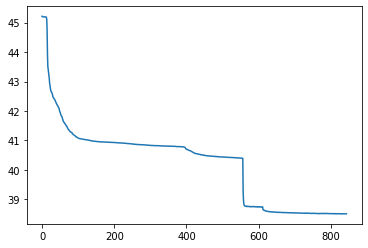

In [94]:
plt.plot(loss_hist_epoch[1:1420])


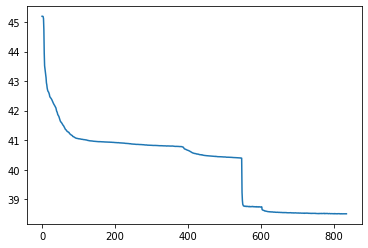

In [95]:
plt.plot(loss_hist_epoch[10:1800])

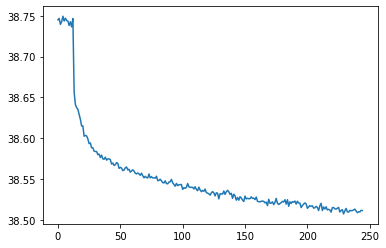

In [96]:
plt.plot(loss_hist_epoch[600:1200])

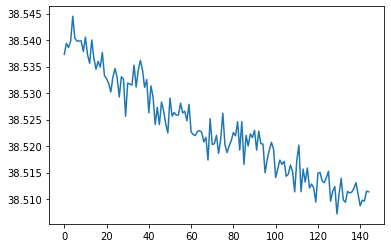

In [97]:
plt.plot(loss_hist_epoch[700:1200])

In [98]:
torch.save(model.state_dict(), 
           os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
print("Saving epoch {}".format(epoch))

Saving epoch 2


In [99]:
torch.save(loss_hist_epoch, os.path.join(model_dir, "hist.pt".format(epoch)))